---
title: "Single Cell Analysis Tutorial"
author:
    - name: Samuele Soraggi
      orcid: 0000-0002-1159-5535
      email: samuele@birc.au.dk
      
---

---
format:
  html:
   theme: default
   number-sections: true
   code-fold: false
   self-contained: true
   toc: true
   highlight-style: pygments
  pdf:
    toc: true
    highlight-style: pygments
    number-sections: true
  ipynb:
    toc: true
    number-sections: true
jupyter: R
bibliography: references.bib
---

This tutorial will give you the extensive basic commands and explanations for the single cell analysis of your own dataset. 

- The **first part of the tutorial** (@sec-preprocessing) is focused on **preprocessing** the data, which means primarily filtering and normalizing it.

- The **second part of the tutorial** (@sec-integration) is focused on **integrating** all sixteen datasets produced from the lab sessions (you will perform this integration analysis in groups), identifying cell types and find a population of cells expressing the HAR1 gene to analyze different conditions of mutant VS wild type Lotus japonicus.

- The **third part of the tutorial** (@sec-gene analysis) applies tipycal gene analysis to detect genes conserved and differentially expressed between conditions
  
- The **fourth part of the tutorial** (@sec-networks) pivots around the study of groups of genes co-expressed in the data and in specific clusters and conditions

The first two parts follow the phylosophy of the best practices explained in @luecken_current_2019 and @heumos_best_2023. The third part applies standard statistical tests on the average gene expressions in subsets of the data. The last part is based pulling cells transcripts together with different granularities to improve the statistical power of calculations based on their gene expression (as in @morabito_hdwgcna_2023).

The tutorial is based on four samples of Lotus Japonicus (two rhizobia-infected and two wild types) from [@frank_single-cell_2023](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10630511/pdf/41467_2023_Article_42911.pdf). The last section follows some of the [tutorials from hdWGCNA](https://smorabit.github.io/hdWGCNA/).

::: {.callout-note title="Learning outcomes" icon=false}
At the end of this tutorial **you will be able to use `R` to**

- Filter your data selecting specific criteria
- Preprocess your data for advanced analysis
- Merge datasets and perform cross-data analysis
- Identify potential cell types by markers and exploiting other datasets 
- Perform differential gene expression
- Infer gene modules from your data and isolate those related to a cell type
- Visualize gene modules and extract their gene ontology to draw biological conclusions
:::

# UMI-based single cell data from microdroplets



The dataset is based on a **microdroplet-based method from 10X chromium**. We remember that a microdroplet single cell sequencing protocol works as follow:

- each cell is isolated together with a barcode bead in a gel/oil droplet

![Isolation of cells and beads into microdroplets.](images/droplet.gif){#fig-beads width=600}

- each transcript in the cell is captured via the bead and assigned a cell barcode and a transcript unique molecular identifier (UMI)
- 3' reverse transcription of mRNA into cDNA is then performed in preparation to the PCR amplification
- the cDNA is amplified through PCR cycles
  
![steps for the microdroplet-based single cell RNA sequencing after isolation.](images/10X.png){#fig-steps width=600}



## The raw data in practice

Let's look at a specific read and its UMI and cell barcode. The data is organized in paired-end reads (written on `fastq` files), where the first `fastq` file contains reads in the following format 

```
@SRR8363305.1 1 length=26
NTGAAGTGTTAAGACAAGCGTGAACT
+SRR8363305.1 1 length=26
#AAFFJJJJJJJJJJJJJJJJFJJJJ
```

Here, the first 16 characters `NTGAAGTGTTAAGACA` represent the cell barcode, while the last 10 characters `AGCGTGAACT` are the transcript UMI tag. The last line represents the quality scores of the 26 characters of barcode+UMI.

The associated second `fastq` file contains reads of 98nt as the following
```
@SRR8363305.1 1 length=98
NCTAAAGATCACACTAAGGCAACTCATGGAGGGGTCTTCAAAGA
    CCTTGCAAGAAGTACTAACTATGGAGTATCGGCTAAGTCAANCN
    TGTATGAGAT
+SRR8363305.1 1 length=98
#A<77AFJJFAAAJJJ7-7-<7FJ-7----<77--7FAAA--
    <JFFF-7--7<<-F77---FF---7-7A-777777A-<
    -7---#-#A-7-7--7--
```
The 98nt-long string of characters in the second line is a partial sequence of the cDNA transcript. Specifically, the 10X chromium protocol used for sequencing the data is biased towards the 3' end, because the sequencing is oriented from the 3' to the 5' end of the transcripts. The last line contains the corresponding quality scores.

## Alignment and expression matrix

The data is aligned with `cellranger`, a completely automatized [pipeline implemented by 10X](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/what-is-cell-ranger) for 10X-genomics data.

Apart from the data, the output contains an interactive document reporting the quality of the data and a small preliminary UMAP plot and clustering. In this report it is especially instructive to look at the **knee plot**. 

The knee plot is created by plotting the number of unique molecular identifiers (UMIs) or reads against the number of cells sequenced, sorted in descending order. The UMIs or reads are a measure of the amount of RNA captured for each cell, and thus a measure of the quality of the data. The plot typically shows a **steep slope at the beginning, followed by a plateau, and then a gradual decrese into a second slope and a final plateau**. 

* The steep slope represents the initial cells that are of **high quality** and have the highest number of UMIs or reads. 
* The first plateau represents the cells that have **lower quality data**, and the gradual decrease represents the addition of droplets with even lower quality data. 
* Usually, beyond the first slope, you have droplets that are **either empty or of so poor quality**, that they are not worth keeping for analysis.
* The height of the last plateau gives you an idea of the **presence of ambient RNA** inside droplets. If the last plateau is located high up, then the corresponding amount of UMIs consist of background ambient RNA which likely pollutes all cells in your data.

Below, the knee plot from the `control 1` sample used in this analysis. You can see that around 10,000 cells with above ~1000 UMIs seems to be coinsidered of decent quality by `cellranger` (the part of line coloured in blue). Note that the last plateau is located at a very low amount of UMIs, meaning there is not really any relevant contamination from ambient RNA.

![Knee plot of the Control 1 sample of the tutorial. Note the lower plateau of ambient RNA](images/knee.png){width=600px #fig-knee}

::: {.callout-note title="Exercise" icon=false}

In this same folder you have the document `web_summary.html` that shows you the quality report of your own dataset. **Take some time to look at it and explore what it contains** (Click on `Trust HTML` on the top menu if the html remains blank after opening it). Get an idea of how many UMIs there are in cells of decent quality. We will work more on filtering out cells based on their quality in this tutorial.

:::

:::{.callout-tip title="Something more about knee plots" collapse="true"}

The background RNA (sequenced together with the transcript coming from the cell of interest) makes up the *ambient plateau*: the same background RNA is contained in empty droplets. If your dataset has extremely few UMI counts in empty droplets, then there is not much background RNA present - This is the best situation in which you can find yourself. See Exhibit A in @fig-bender.

If you have a dataset where you can identify an *empty droplet plateau* by eye (Exhibit B in @fig-bender), and these empty droplets have 50 or 100 or several hundred counts, theit can be advisable to use a specific software to remove the background transcripts (e.g. CellBender (@fleming_unsupervised_2023), SoupX (@young_soupx_2020)).

If you have a dataset with so much background RNA that you cannot identify the *empty droplet plateau* yourself by eye (Exhibit C in @fig-bender), then any software to remove background transcripts will also likely have a difficult time. Such the algorithms might be worth a try, but you should **strongly consider re-running the experiment, as the knee plot points to a real QC failure**

![Various cases of knee plot you can encounter from sequenced data. Figure from [the webpage of Cellbender.](https://cellbender.readthedocs.io/)](images/UMI_curve_tropes.png){width=600px #fig-bender}

:::

# Preprocessing {#sec-preprocessing}

::: {.callout-note title="Learning outcome"}
We will answer to the following questions:

* How can I **import single-cell data** into R?
* How are different types of data/information (e.g. cell information, gene information, etc.) **stored and manipulated**?
* How can I obtain basic **summary metrics** for cells and genes and **filter the data** accordingly?
* How can I **visually explore** these metrics?
:::

We start by loading all the packages necessary for the analysis and setup a few things

In [1]:
suppressPackageStartupMessages({ library(SeuratDisk); 
library(Seurat);
library(DoubletFinder);
library(parallel);
library(multtest);
library(metap);
library(purrr);
library(dplyr);
library(stringr);
library(tibble);
library(ggplot2);
library(MAST);
library(WGCNA);
library(hdWGCNA);
library(patchwork);})

In [2]:
options(future.seed=TRUE)

In [3]:
plan("multicore", workers = 8)
options(future.globals.maxSize = 8 * 1024^3)

## Import data

We import the data reading the matrix files aligned by 10X. Those are usually contained in a folder with a name of the type `aligned_dataset/outs/filtered_bc_matrix`, that 10X Cellranger creates automatically after the alignment. You will use such a folder when your own data is aligned. In this tutorial, the aligned data is in the folder used below. The command for reading the data is simply `Read10X`. 

::: {.callout-important}
When using your own data, you need to use the correct folder name below (for example `Aligned_Gifu_ctr_1/outs/filtered_bc_matrix`)
:::

In [4]:
WT_Control1_10dpi <- Read10X("../tutorial_data/control_1/")

Note that we are loading only one dataset (`control_1`, one of the two control replicates). Another control dataset, and two wild type datasets, have already been preprocessed and will be used later - so **we will now focus on the preprocessing of a single dataset**. In general, when you have multiple datasets, you must preprocess them one at a time before integrating them together.

What we obtain is a matrix created from some storage-saving matrix files which are quite obscure to read. Look at the first 10 rows and columns of the matrix (whose rows represent genes and columns droplets/cells) - the dots are zeros (they are not stored in the data, which has a compressed format called `dgCMatrix`), and **are the majority of the expression values obtained in scRNA data!**

In [5]:
WT_Control1_10dpi[1:10,1:10]

  [[ suppressing 10 column names ‘AAACCCAAGGGCAGTT-1’, ‘AAACCCAAGTCAGCGA-1’, ‘AAACCCACACTAACCA-1’ ... ]]



10 x 10 sparse Matrix of class "dgCMatrix"
                                         
LotjaGi0g1v0000100    . . . . . . . . . .
LotjaGi0g1v0000200    . . . . . . . . . .
LotjaGi0g1v0000300    . . . . . . . . . .
LotjaGi0g1v0000400    . . . . . . 1 1 . .
LotjaGi0g1v0000500    . . . . . . . . . .
LotjaGi0g1v0000600    . . . . . . . . . .
LotjaGi0g1v0000700    . . . . . . . . . .
LotjaGi0g1v0000800    . . . . 1 . . . . .
LotjaGi0g1v0000900_LC . . . . . . . . . .
LotjaGi0g1v0001000_LC . . . . . . . . . .

What is the percentage of zeros in this matrix? You can see it for yourself below - it is a lot, but quite surprisingly we can get a lot of information from the data!

In [6]:
cat("Number of zeros: ")
zeros <-  sum(WT_Control1_10dpi==0)
cat( zeros )

Number of zeros: 307060673

In [7]:
cat("Number of expression entries: ")
total <- dim(WT_Control1_10dpi)[1] * dim(WT_Control1_10dpi)[2]
cat( total )

Number of expression entries: 329798055

In [8]:
cat("Percentage of zeros: ")
cat( zeros / total * 100 )

Percentage of zeros: 93.10567

## Create a single cell object in Seurat

We use our count matrix to create a Seurat object. A Seurat object allows you to **store the count matrix** and future modifications of it (for example its normalized version), together with **information regarding cells and genes** (such as clusters of cell types) and their **projections** (such as PCA and tSNE). We will go through these elements, but first we create the object with `CreateSeuratObject`:

In [9]:
WT_Control1_10dpi_seurat <- CreateSeuratObject(counts = WT_Control1_10dpi, 
                                               project = "WT_Control1_10dpi_seurat", 
                                               min.cells = 3, 
                                               min.features = 200)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


The arguments of the command are 
* `counts`: the count matrix
* `project`: a project name
* `min.cells`: a minimum requirement for genes, in our case saying they must be expressed in at least 3 cells. If not, they are filtered out already now when creating the object.
* `min.features`: a minimum requirement for cells. Cells having less than 200 expressed genes are removed from the beginning from the data.

Values for the minimum requirements chosen above are standard checks when running the analysis. Droplets not satisfying those requirements are of extremely bad quality and not worth carrying on during the analysis (remember the knee plot). 

How many genes and cells have been filtered out?

In [10]:
cat("Starting Genes and Cells:\n")
cat( dim(WT_Control1_10dpi) )

cat("\nFiltered Genes and Cells:\n")
cat( dim(WT_Control1_10dpi) - dim(WT_Control1_10dpi_seurat) )

cat("\nRemaining Genes and Cells:\n")
cat( dim(WT_Control1_10dpi_seurat) )

Starting Genes and Cells:
30585 10783
Filtered Genes and Cells:
6747 11
Remaining Genes and Cells:
23838 10772

We want to use this data later in the analysis with other `Control` and `Wild Type` datasets. Therefore we add a `Condition` to the metadata table, and for this dataset we establish that each cell is `Control`.

::: {.callout-important}
When using your own data, do not forget to **write the correct metadata label**: state exactly either `Control` or `Wild Type` so that all datasets created during the course will match their metadata correctly.
:::

In [11]:
WT_Control1_10dpi_seurat <- AddMetaData(object = WT_Control1_10dpi_seurat, 
                                        metadata = "Control", 
                                        col.name = "Condition")

### Content of a Seurat Object
What is contained in the Seurat object? We can use the command `str` to list the various *slots* of the object.

In [12]:
str(WT_Control1_10dpi_seurat, max.level = 2)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  ..@ meta.data   :'data.frame':	10772 obs. of  4 variables:
  ..@ active.assay: chr "RNA"
  ..@ active.ident: Factor w/ 1 level "WT_Control1_10dpi_seurat": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..- attr(*, "names")= chr [1:10772] "AAACCCAAGGGCAGTT-1" "AAACCCAAGTCAGCGA-1" "AAACCCACACTAACCA-1" "AAACCCACATGATCTG-1" ...
  ..@ graphs      : list()
  ..@ neighbors   : list()
  ..@ reductions  : list()
  ..@ images      : list()
  ..@ project.name: chr "WT_Control1_10dpi_seurat"
  ..@ misc        : list()
  ..@ version     :Classes 'package_version', 'numeric_version'  hidden list of 1
  ..@ commands    : list()
  ..@ tools       : list()


The first slot is called `assays`, and it contains all the count matrices we have collected during our analysis when, for example, normalizing data or doing other transformations of it. Right now we only have the `RNA` assay with the raw counts:

In [13]:
WT_Control1_10dpi_seurat@assays

$RNA
Assay data with 23838 features for 10772 cells
First 10 features:
 LotjaGi0g1v0000100, LotjaGi0g1v0000200, LotjaGi0g1v0000300,
LotjaGi0g1v0000400, LotjaGi0g1v0000500, LotjaGi0g1v0000700,
LotjaGi0g1v0000800, LotjaGi0g1v0001100, LotjaGi0g1v0001200,
LotjaGi0g1v0001400 


You can always select which matrix is currently in use for the analysis by assigning it to `DefaultAssay()`. The default assay is often changed automatically by Seurat, for example the normalized assay is used as default after normalization is performed.

In [14]:
DefaultAssay(object = WT_Control1_10dpi_seurat) <- "RNA"

In [15]:
cat("Your default assay is ")
cat(DefaultAssay(object = WT_Control1_10dpi_seurat))

Your default assay is RNA

The second slot is the one that contains the metadata for each cell. It is easily visualized as a table (the command `head` shows only the first 6 rows of the table):

In [16]:
head( WT_Control1_10dpi_seurat@meta.data )

orig.ident               nCount_RNA nFeature_RNA Condition
AAACCCAAGGGCAGTT-1 WT_Control1_10dpi_seurat  3567      1919         Control  
AAACCCAAGTCAGCGA-1 WT_Control1_10dpi_seurat  7015      2751         Control  
AAACCCACACTAACCA-1 WT_Control1_10dpi_seurat  1484       828         Control  
AAACCCACATGATCTG-1 WT_Control1_10dpi_seurat 20942      4711         Control  
AAACCCAGTAGCTTGT-1 WT_Control1_10dpi_seurat 29105      5157         Control  
AAACCCAGTCTCTCAC-1 WT_Control1_10dpi_seurat  6115      2124         Control

The table contains a name for the dataset (`orig.ident`, useful to distinguish multiple datasets merged together), how many RNA transcripts are contained in each cell (`nCount_RNA`), the number of expressed genes in each cell (`nFeature_RNA`), and the `Condition` (added by us previously). More metadata can be added along the analysis, and some is added automatically by Seurat when running specific commands.

The `assays` and `meta.data` slots are the most relevant and useful to know - the other ones are mostly for internal use by Seurat and we do not go into detail with those.

## Finding filtering criteria

We want to look in depth at which droplets do not contain good quality data, so that we can filter them out. The standard approach - which works quite well - is to study the **distribution of various quality measures and remove doublets** (droplets containing more than one cell) which can confound the analysis results.

### Quality measure distributions

A first step is to calculate the percentage of mitochondrial and chloroplastic genes. A high percentage indicates the presence of spilled material from broken cells. We use the command `PercentageFeatureSet` and provide the pattern of the gene ID which corresponds to mitochondrial and ribosomal genes. The percentages are saved into the metadata simply by using the double squared brackets `[[`.

In [17]:
WT_Control1_10dpi_seurat[["percent.mt"]] <- PercentageFeatureSet(WT_Control1_10dpi_seurat, 
                                                                 pattern = "LotjaGiM1v")
WT_Control1_10dpi_seurat[["percent.chloroplast"]] <- PercentageFeatureSet(WT_Control1_10dpi_seurat, 
                                                                          pattern = "LotjaGiC1v")

You can see the new metadata is now added for each cell

In [18]:
head( WT_Control1_10dpi_seurat@meta.data )

orig.ident               nCount_RNA nFeature_RNA Condition
AAACCCAAGGGCAGTT-1 WT_Control1_10dpi_seurat  3567      1919         Control  
AAACCCAAGTCAGCGA-1 WT_Control1_10dpi_seurat  7015      2751         Control  
AAACCCACACTAACCA-1 WT_Control1_10dpi_seurat  1484       828         Control  
AAACCCACATGATCTG-1 WT_Control1_10dpi_seurat 20942      4711         Control  
AAACCCAGTAGCTTGT-1 WT_Control1_10dpi_seurat 29105      5157         Control  
AAACCCAGTCTCTCAC-1 WT_Control1_10dpi_seurat  6115      2124         Control  
                   percent.mt percent.chloroplast
AAACCCAAGGGCAGTT-1 4.6818054  0.02803476         
AAACCCAAGTCAGCGA-1 0.7127584  0.04276550         
AAACCCACACTAACCA-1 6.6037736  0.06738544         
AAACCCACATGATCTG-1 0.4775093  0.12415242         
AAACCCAGTAGCTTGT-1 0.2954819  0.05497337         
AAACCCAGTCTCTCAC-1 1.6026165  0.01635323

#### Number of transcripts per cell

We plot a histogram of the number of transcripts per cell in @fig-rnacount below. On the right, we zoom into the histogram. We want to **filter out the cells with the lowest number of transcripts** - often there is a peak we can identify with a group of low-quality cells. Here we can choose to remove cells with less than ~700 transcripts (some people prefere to do a lighter filtering, and would for example set a threshold to a lower value). We remove also **cells with too many transcripts** that might contain some weird transcripts - which is also helpful for normalization because it removes some outlying values. For those we can set a limit to 30000, where there is a very thin tail in the histogram.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 7668 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


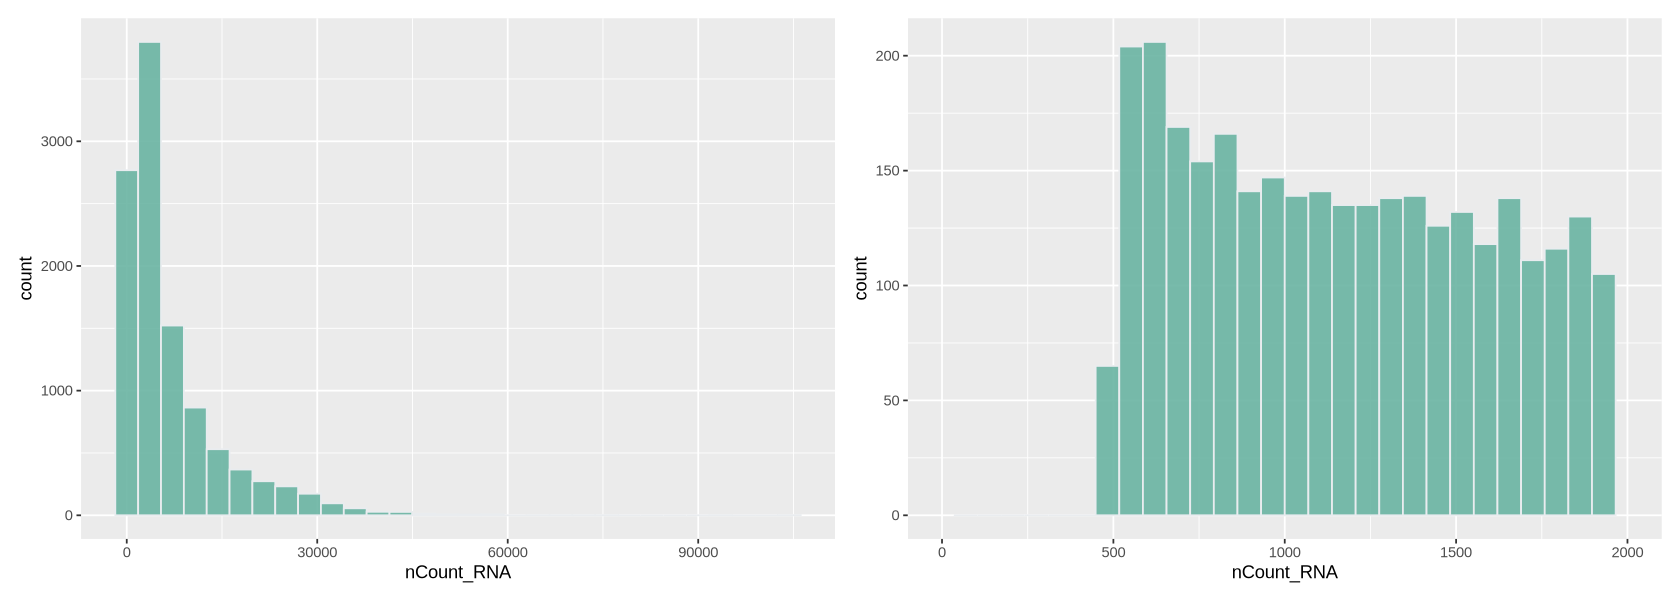

In [19]:
#| label: fig-rnacount
#| fig-cap: "Histogram of transcripts per cell (left) and a zoom onto the histogram (right)"

options(repr.plot.width=14, repr.plot.height=5)

plot1 <- ggplot(WT_Control1_10dpi_seurat@meta.data, aes(x=nCount_RNA)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9)

plot2 <- ggplot(WT_Control1_10dpi_seurat@meta.data, aes(x=nCount_RNA)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9) +
     xlim(0,2000)

plot1 + plot2

#### Number of detected genes per cell
Here we work similarly to filter out cells based on how many genes are detected (@fig-genecounts). The right-side plot is a zoom into the histogram. It seems easy to set the thresholds at ~400 and ~7000 detected genes.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 7793 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


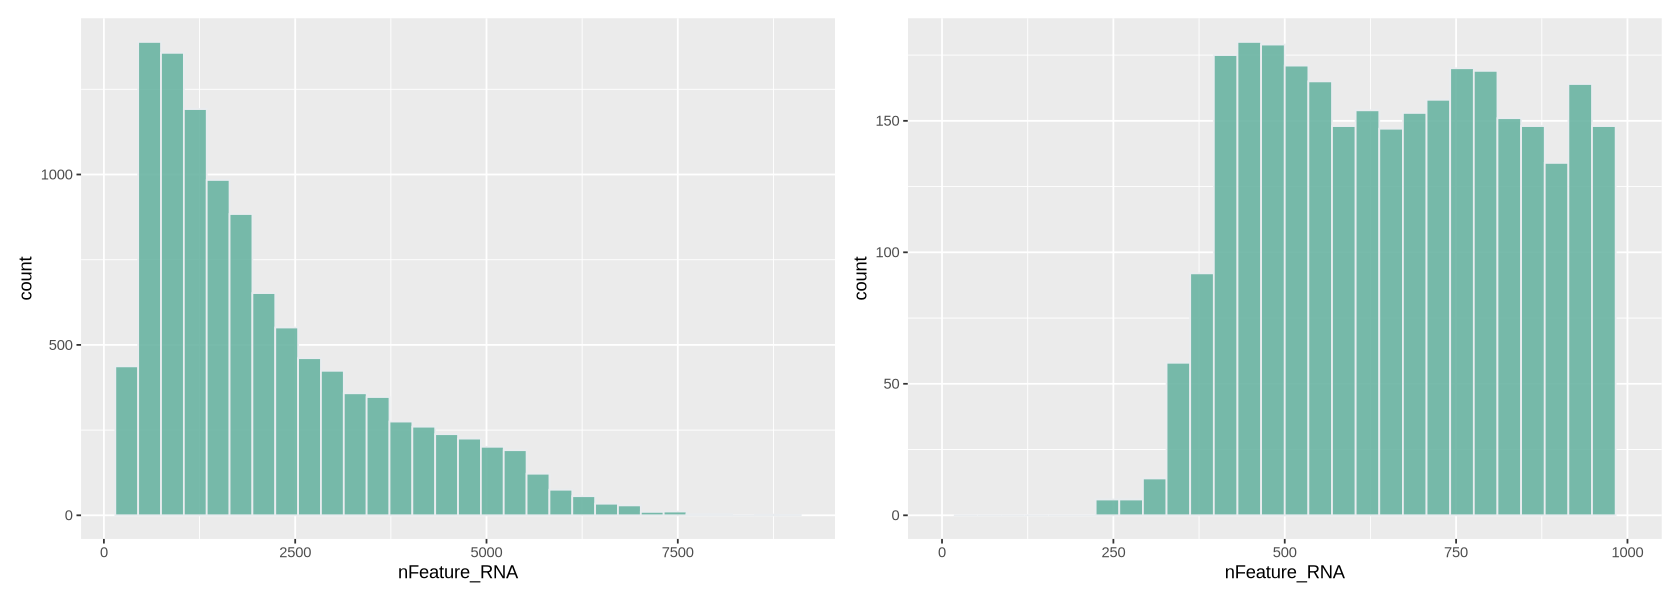

In [20]:
#| label: fig-genecounts
#| fig-cap: "Histogram of detected counts per cell (left) and a zoom onto the histogram (right)"


options(repr.plot.width=14, repr.plot.height=5)

plot1 <- ggplot(WT_Control1_10dpi_seurat@meta.data, aes(x=nFeature_RNA)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9)

plot2 <- ggplot(WT_Control1_10dpi_seurat@meta.data, aes(x=nFeature_RNA)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9) +
     xlim(0,1000)


plot1 + plot2

#### Mitochondrial and Chloroplast percentages

The percentages of mitochondrial and chloroplastic transcripts tells us the data is of good quality, since most cells have low values of those (@fig-mt). Thresholds are usually set between 5% and 20% in single cell data analysis. In the paper, thresholds were for example set at 20%.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


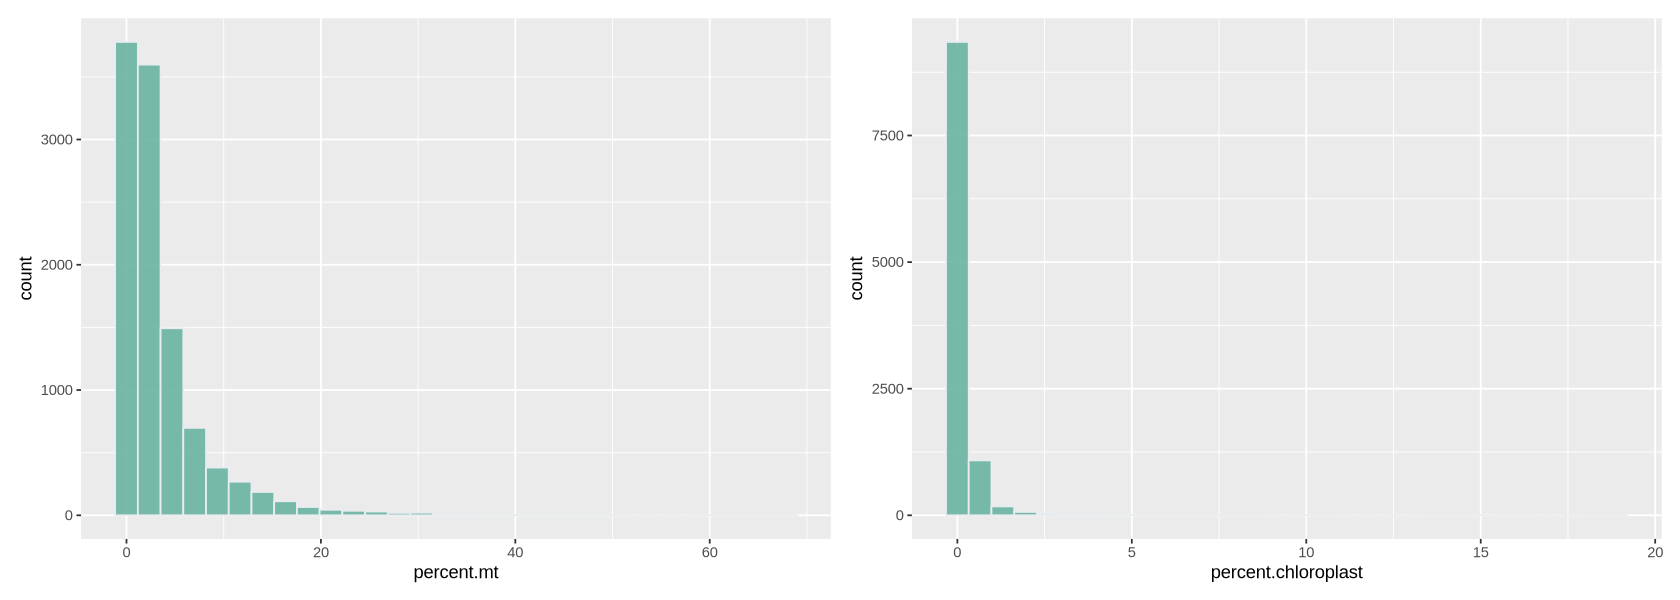

In [21]:
#| label: fig-mt
#| fig-cap: "Histogram of mitochondrial (left) and chloroplastic (right) percentage of transcripts in each cell"

options(repr.plot.width=14, repr.plot.height=5)

plot1 <- ggplot(WT_Control1_10dpi_seurat@meta.data, aes(x=percent.mt)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9)

plot2 <- ggplot(WT_Control1_10dpi_seurat@meta.data, aes(x=percent.chloroplast)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9)

plot1 + plot2

#### Counts-Features relationship

In @fig-gentra below, we look at the plot of the number of transcripts per cell vs the number of detected genes per cell. Usually, those two measure grow simultaneously. At lower counts the relationship is quite linear, then becomes a curve, typically bending in favour of the number of transcripts per cell. You can see below that each dot (representing a droplet) is coloured by percentage of mitochondria. Droplets with a high percentage of mitochondrial genes also have very low amount of transcripts and detected genes, **confirming that high mitochondrial content is a measure of low quality**.

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“The following aesthetics were dropped during statistical transformation: colour
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


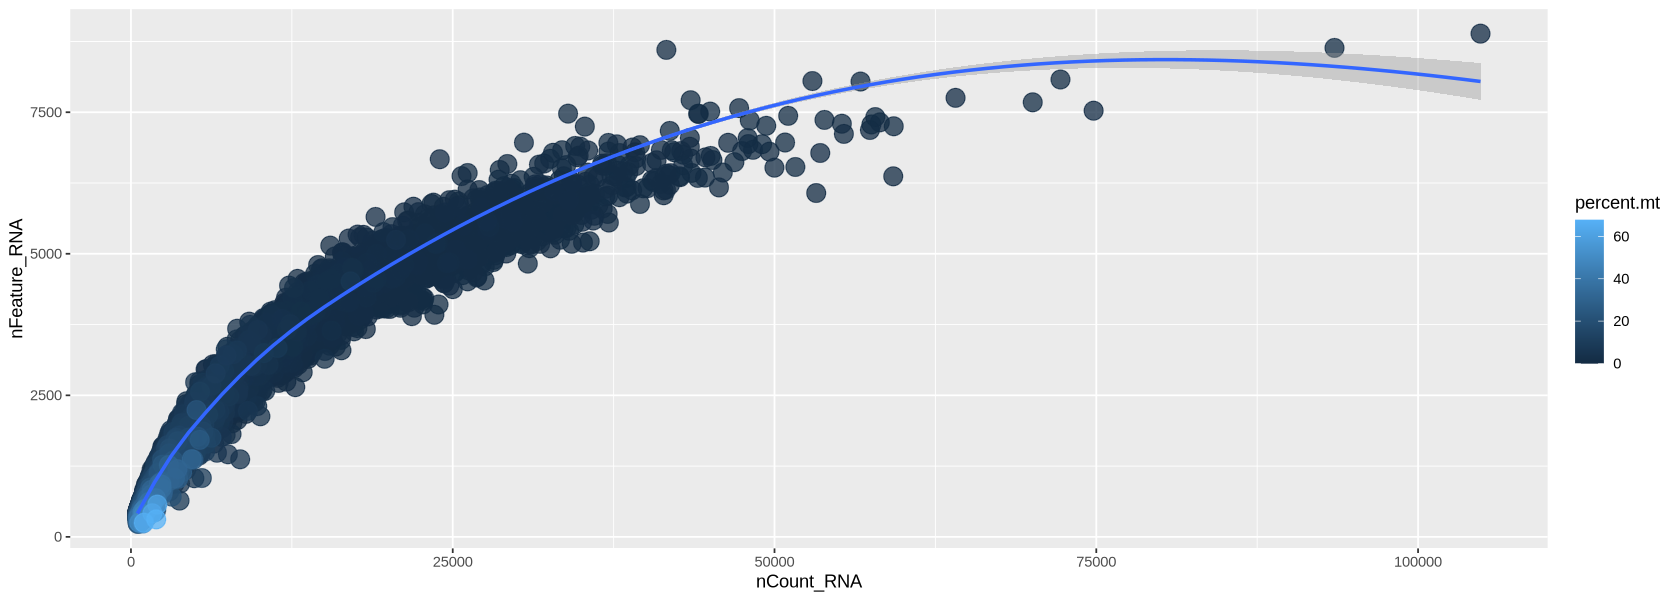

In [22]:
#| label: fig-gentra
#| fig-cap: "Histogram of the relationship between detected genes and transcripts per cell, coloured by mitochondrial content."


options(repr.plot.width=14, repr.plot.height=5)

meta <- WT_Control1_10dpi_seurat@meta.data %>% arrange(percent.mt)

plot1 <- ggplot( meta, aes(x=nCount_RNA, y=nFeature_RNA, colour=percent.mt)) + 
         geom_point(alpha=0.75, size=5)+
         geom_smooth(se=TRUE, method="loess")

plot1

In a similar way the chloroplastic genes confirm the pattern of low quality droplets.

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“The following aesthetics were dropped during statistical transformation: colour
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


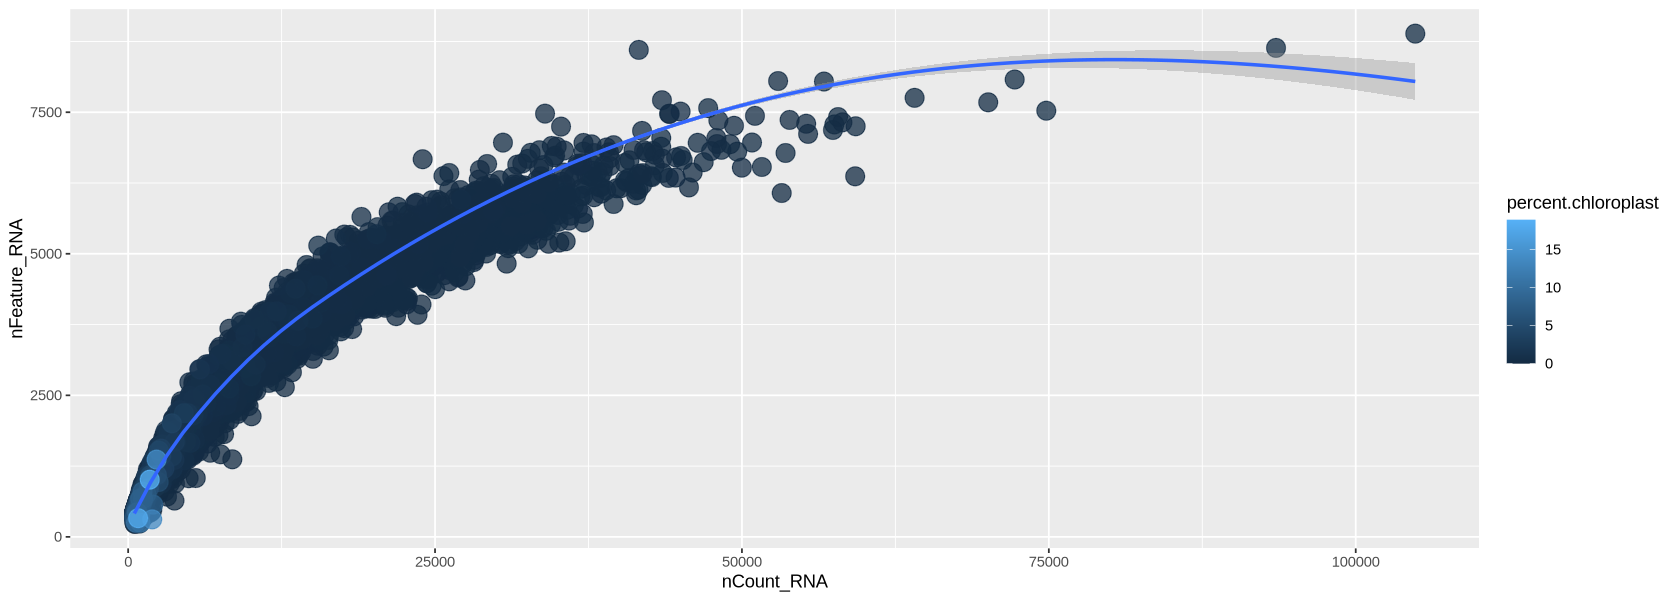

In [23]:
#| label: fig-gentrach
#| fig-cap: "Histogram of the relationship between detected genes and transcripts per cell, coloured by chloroplastic content."

options(repr.plot.width=14, repr.plot.height=5)

meta <- WT_Control1_10dpi_seurat@meta.data %>% arrange(percent.chloroplast)

plot1 <- ggplot( meta, aes(x=nCount_RNA, y=nFeature_RNA, colour=percent.chloroplast)) + 
         geom_point(alpha=0.75, size=5)+
         geom_smooth(se=TRUE, method="loess")

plot1

### Filtering with the chosen criteria

Here we use the command `subset` and impose the criteria we chose above looking at the histograms. We set each criteria for keeping cells of good quality using the names of the features in metadata. We print those names to remember them.

In [24]:
cat("Meta data names:\n")
cat( names(WT_Control1_10dpi_seurat@meta.data), sep='; ' )

Meta data names:
orig.ident; nCount_RNA; nFeature_RNA; Condition; percent.mt; percent.chloroplast

The filtered object is called `WT_Control1_10dpi_seurat_filt`

In [25]:
WT_Control1_10dpi_seurat_filt <- subset(x = WT_Control1_10dpi_seurat, 
                                        subset = nCount_RNA > 700 &
                                                 nCount_RNA < 35000 &
                                                 nFeature_RNA > 400 & 
                                                 nFeature_RNA < 7000 & 
                                                 percent.mt < 5 & 
                                                 percent.chloroplast < 5)

cat("Filtered Genes and Cells: ")
cat( dim(WT_Control1_10dpi_seurat) - dim(WT_Control1_10dpi_seurat_filt) )
cat("\nRemaining Genes and Cells: ")
cat( dim(WT_Control1_10dpi_seurat_filt) )

Filtered Genes and Cells: 0 2762
Remaining Genes and Cells: 23838 8010

Now the transcripts vs genes plot looks as below. The relationship is much more linear than previously after the removal of extreme values for transcripts and detected genes.

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“The following aesthetics were dropped during statistical transformation: colour
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?”


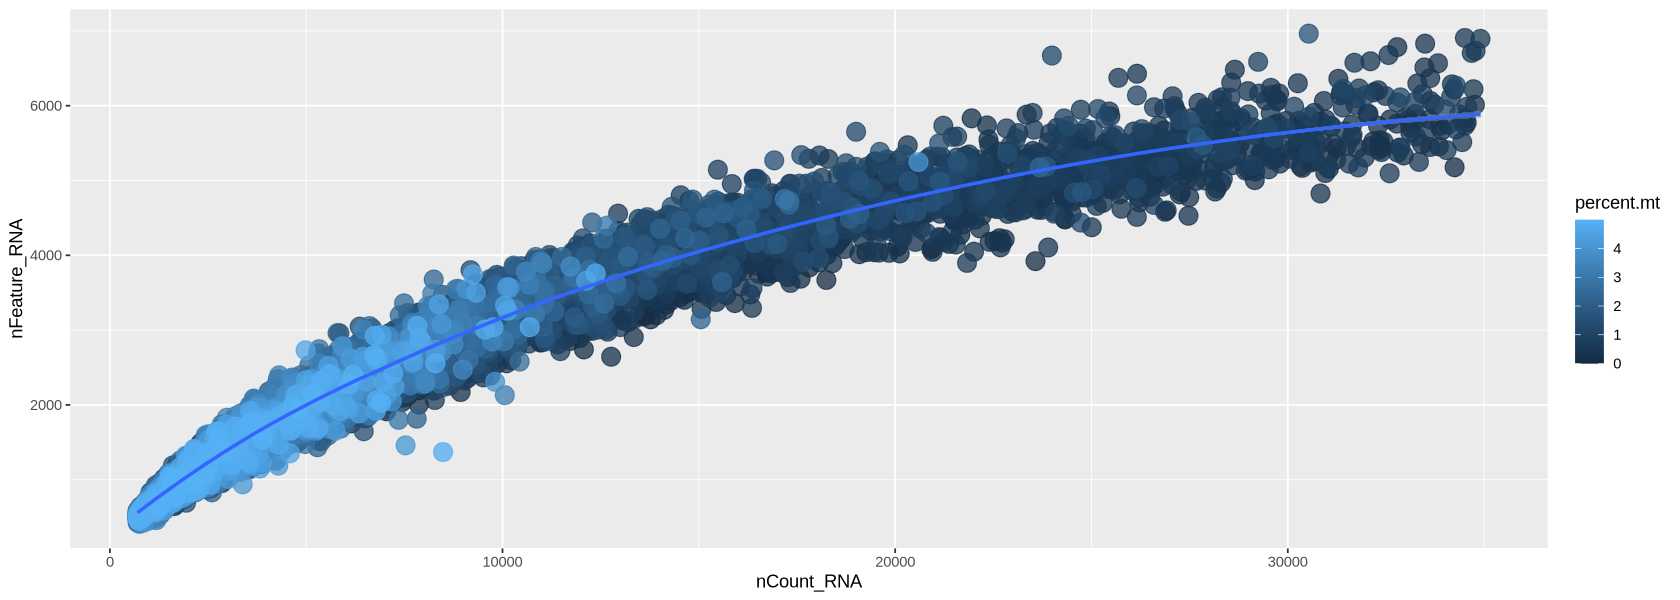

In [26]:
options(repr.plot.width=14, repr.plot.height=5)

meta <- WT_Control1_10dpi_seurat_filt@meta.data %>% arrange(percent.mt)

plot1 <- ggplot( meta, aes(x=nCount_RNA, y=nFeature_RNA, colour=percent.mt)) + 
         geom_point(alpha=0.75, size=5)+
         geom_smooth(se=TRUE, method="loess")

plot1

## Normalization

scRNA-seq data is **affected by highly variable RNA quantities and qualities** across different cells. Furthermore, it is often subject to **batch effects, sequencing depth differences, and other technical biases** that can confound downstream analyses.

Normalization methods are used to **adjust for these technical variations so that true biological differences between cells can be accurately identified**.

Some commonly used normalization methods in scRNA-seq data include the following:

* **Total count normalization**: Normalizing the read counts to the total number of transcripts in each sample
* **TPM (transcripts per million)** normalization: Normalizing the read counts to the total number of transcripts in each sample, scaled to a million
* **Library size normalization:** Normalizing the read counts to the total number of reads or transcripts in each sample, adjusted for sequencing depth

All the above suffer from distorting some gene expressions, especially if the data varies a lot in term of sequencing depth. A new and more advanced method, at the moment the state-of-the-art, is `SCTransform` (@hafemeister_normalization_2019), a software package that can **correct for technical sources of variation and remove batch effects**.

### Finding technical sources of variation

Before normalizing we want to check for technical sources of variation in the data. One of those is the total number of transcripts: two similar cells might be sequenced at different depth. This influences of course normalization. The influence of the number of transcripts per cell is however always removed by `SCtransform`. 

We want to look into other possible sources of variation. Those are usually quantities we calculate for each cell, for example the percentage of mitochondrial and chloroplastic genes. 

To see if those quantities actually influence our data a lot, we check how much is their highest correlation with the first 10 components of the PCA of the dataset. In short, **we see if any technical variation is such that it explains much of the variability of the data, covering possibly biological signal**.

Below, we define a function to look at those correlations and plotting them. Do not spend time reading the code, it is quite extensive and mostly contains things to calculate correlations and plot them. Just run it.

In [27]:
#a function to nicely plot correlations
plotCorrelations <- function(object, measures=c('nCount_RNA'), nfeatures=1000){
    options(repr.plot.width=14, repr.plot.height=5)
    obj <- FindVariableFeatures(object, nfeatures = nfeatures)
    var <- obj@assays$RNA@meta.features$vst.variable
    mat <- t( obj@assays$RNA@counts[var,] )
    pca <- prcomp(mat,  center = F, scale. = F)
    meta <- object@meta.data
    r2 <- matrix(0, nrow=length(measures), ncol=10)
    r2max <- c()
    for(ROW in 1:length(measures)){
        for(COL in 1:10){
            r2[ROW, COL] <- summary( lm( meta[, measures[ROW]] ~ pca$x[,COL]) )$r.squared
            }
        r2max <- c(r2max, which.max(r2[ROW,]))
        }
    
    plot_list = list()
    for(ROW in 1:length(measures)){
        p <- ggplot( meta, aes(x=pca$x[,r2max[ROW]], y=meta[,measures[ROW]])) + 
        geom_point(alpha=0.1, size=5)+
        geom_smooth(se=TRUE, method="lm") +
        ggtitle( paste("Regression of",measures[ROW],"~ PCA",r2max[ROW], "with maximum R^2",r2[ROW,r2max[ROW]]) ) + 
        xlab(paste("PCA",r2max[ROW])) + ylab(measures[ROW])

        print(p)
        }
    }
    

We now use the function to plot the highest correlation of three quantities with the PCA: number of transcripts, percent of mitochondrial genes and percent of chloroplastic genes. You will see in @fig-corr how **there is little correlation for the two percentages**, for which we do not need to worry about, while **there is correlation with the total number of transcripts per cell** (this is always expected and, as mentioned before, is removed automatically by the normalization process). 

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


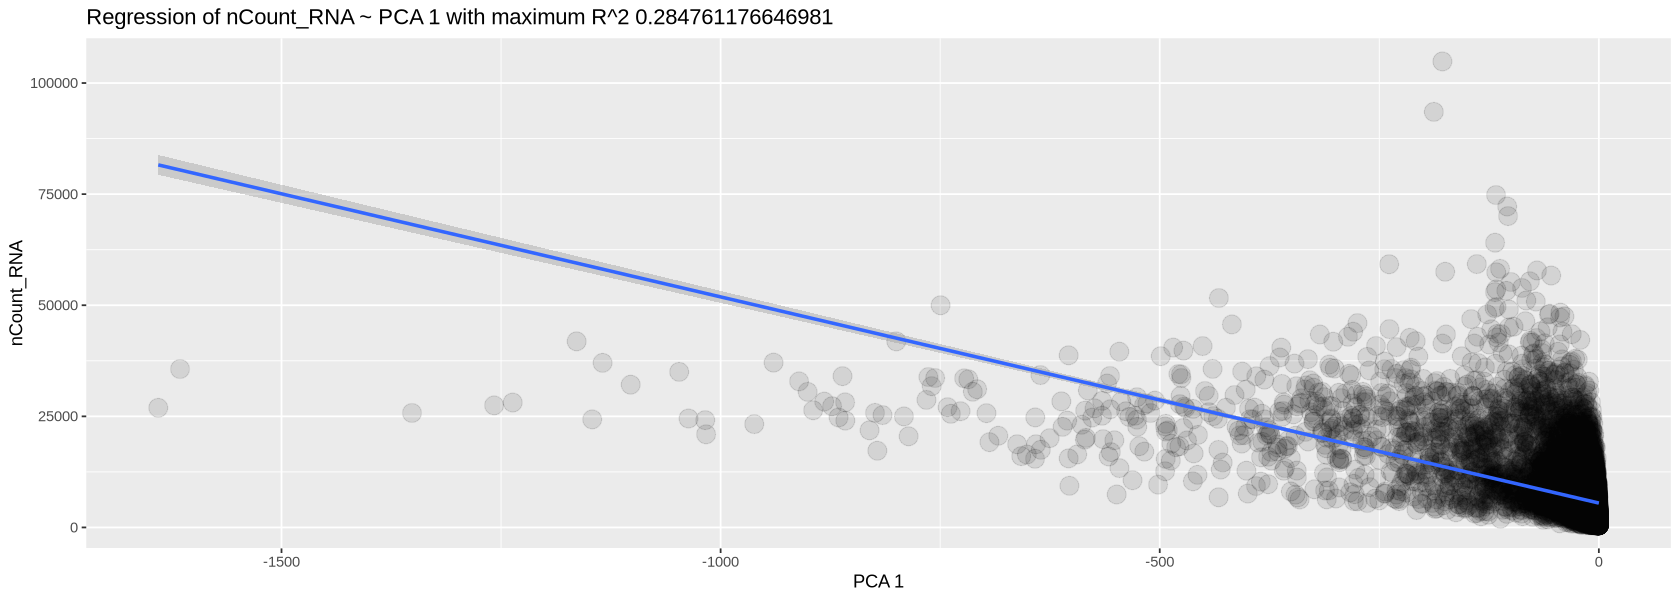

`geom_smooth()` using formula = 'y ~ x'


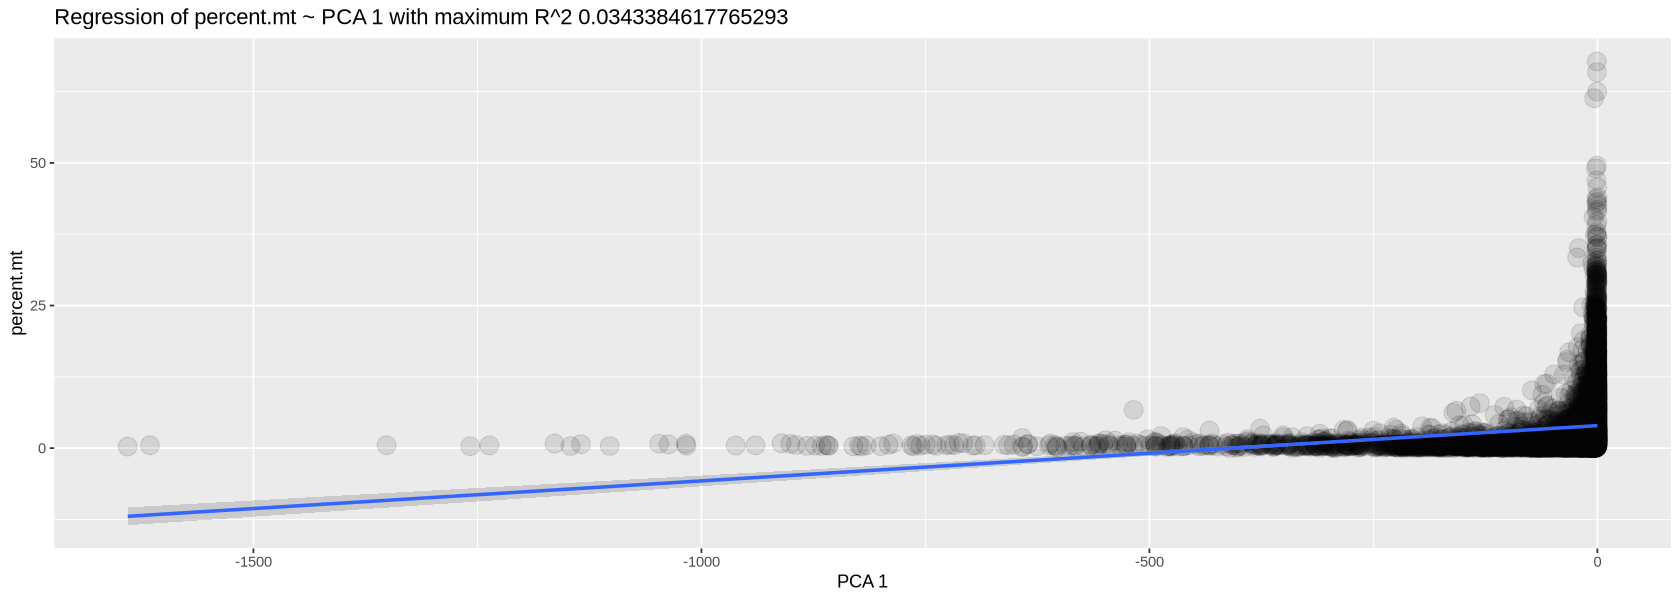

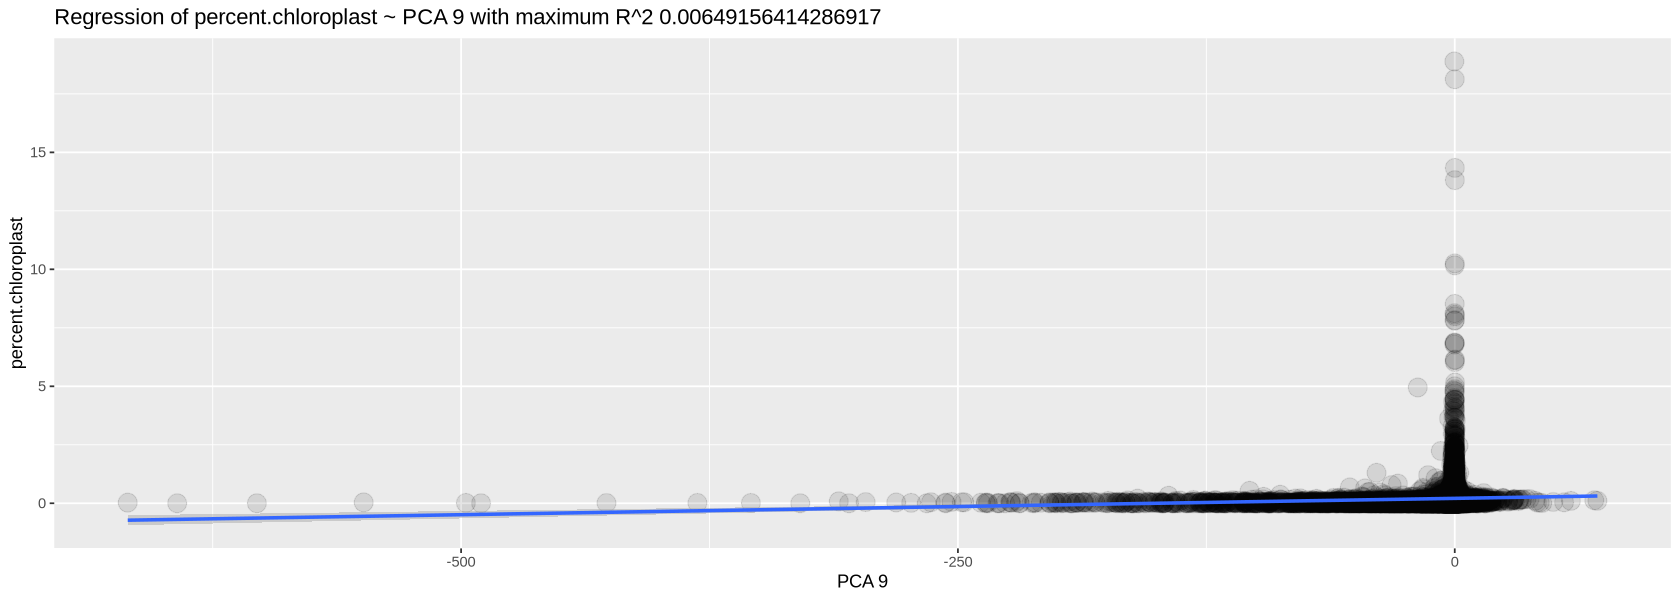

In [28]:
#| label: fig-corr
#| fig-cap: "Relationships of maximal correlation between cell quantities and principal components"
plotCorrelations( object=WT_Control1_10dpi_seurat, measures=c('nCount_RNA', 'percent.mt', 'percent.chloroplast') )

### Executing normalization

We run `SCtransform` normalization below. Here you can choose to subsample some cells to do the normalization (`ncells` option): this is **useful to avoid ending up waiting for a long time**. A few thousands cells is enough. 

You can also choose how many genes to consider for normalization (`variable.features.n` option): in this case it is best to **use the genes that vary the most their expression across cells**. We look at a histogram (@fig-hvg) of the variance of each gene to choose a threshold identify highly-variable genes.

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.4 GiB”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 3289 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


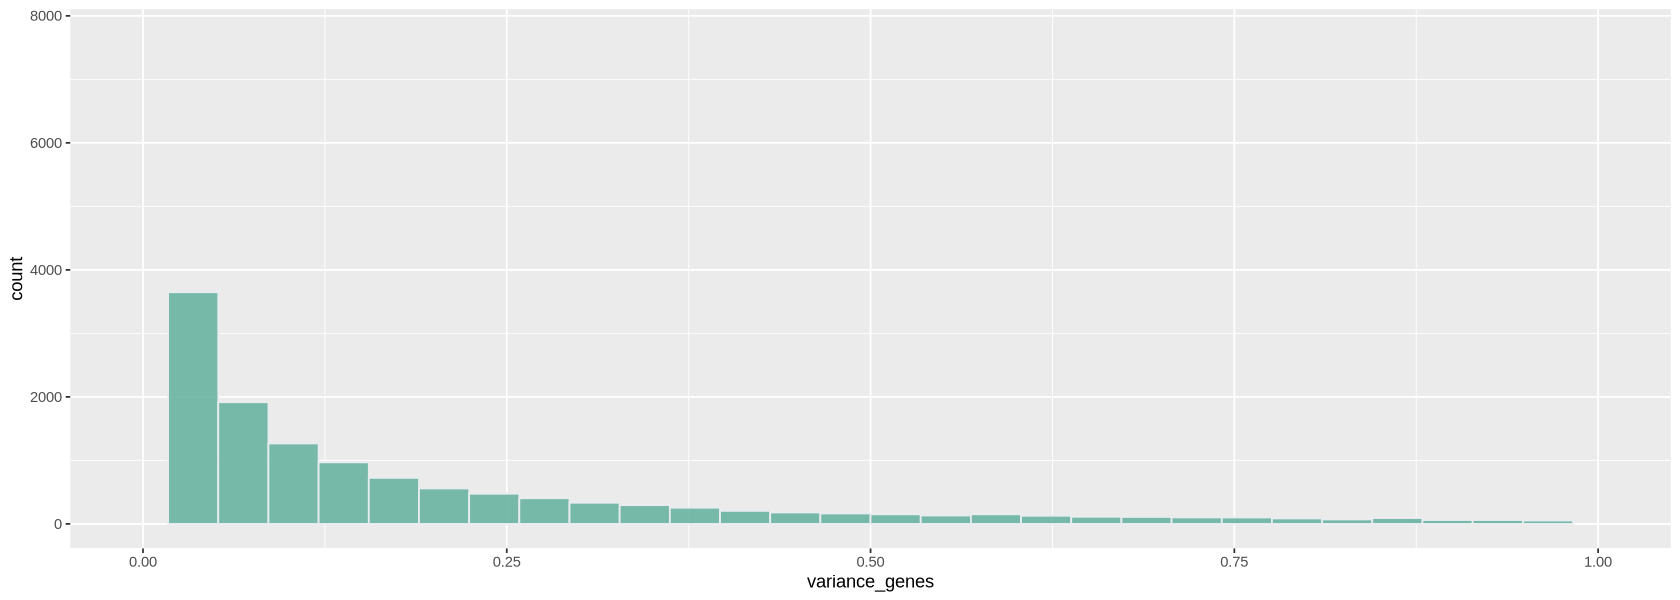

In [29]:
#| label: fig-hvg
#| fig-cap: "Histogram of genes variance. We choose the threshold 0.25 to identify highly variable genes."

variance_genes <- apply( as.matrix(WT_Control1_10dpi_seurat_filt[['RNA']]@counts), 1, var)

options(repr.plot.width=14, repr.plot.height=5)

plot1 <- ggplot(data.frame(variance_genes), aes(variance_genes)) + 
     geom_histogram(fill="#69b3a2", color="#e9ecef", alpha=0.9) + xlim(0,1)

plot1

In [30]:
hvighly_var_genes <- variance_genes > .25
cat("The total number of highly variable genes selected is: ")
cat(sum( hvighly_var_genes ))

The total number of highly variable genes selected is: 6652

In [31]:
WT_Control1_10dpi_seurat_norm <- SCTransform(WT_Control1_10dpi_seurat_filt, 
                                             return.only.var.genes = FALSE, 
                                             ncells = 3000, 
                                             variable.features.n = sum( hvighly_var_genes ))

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 22682 by 8010

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3000 cells



  |======================================================================| 100%


Found 88 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 22682 genes



  |======================================================================| 100%


Computing corrected count matrix for 22682 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.405852 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



Normalized data is now in the object `WT_Control1_10dpi_seurat_norm`, in a new assay called `SCT`. This assay is now the default used for data analysis: you can verify it very easily below:

In [32]:
cat("Your default assay is ")
cat(DefaultAssay(object = WT_Control1_10dpi_seurat_norm))

Your default assay is SCT

### Visualizing the result

Now we plot the UMAP plot of the data to have a first impression of how the data is structured (presence of clusters, how many, etc.). First of all, we create a PCA plot, which tells us how many PCA components are of relevance with the elbow plot of @fig-elbow. In the elbow plot, we see the variability of each component in descending order. Note how, after a few rapidly descending components, there is an elbow. We schoose a threshold just after the elbow (for example at 10), which means those components will be used to calculate some other things of relevance in the data, such as distance between cells and the UMAP projection of @fig-umap: specific commands using PCA allow to choose the components, and we will set 10 with the option `dims = 1:10`.

In [33]:
WT_Control1_10dpi_seurat_norm <- FindVariableFeatures(WT_Control1_10dpi_seurat_norm,
                                                     nfeatures = sum( hvighly_var_genes ))

In [34]:
WT_Control1_10dpi_seurat_norm <- RunPCA(object = WT_Control1_10dpi_seurat_norm, 
                                        verbose = FALSE, seed.use = 123)

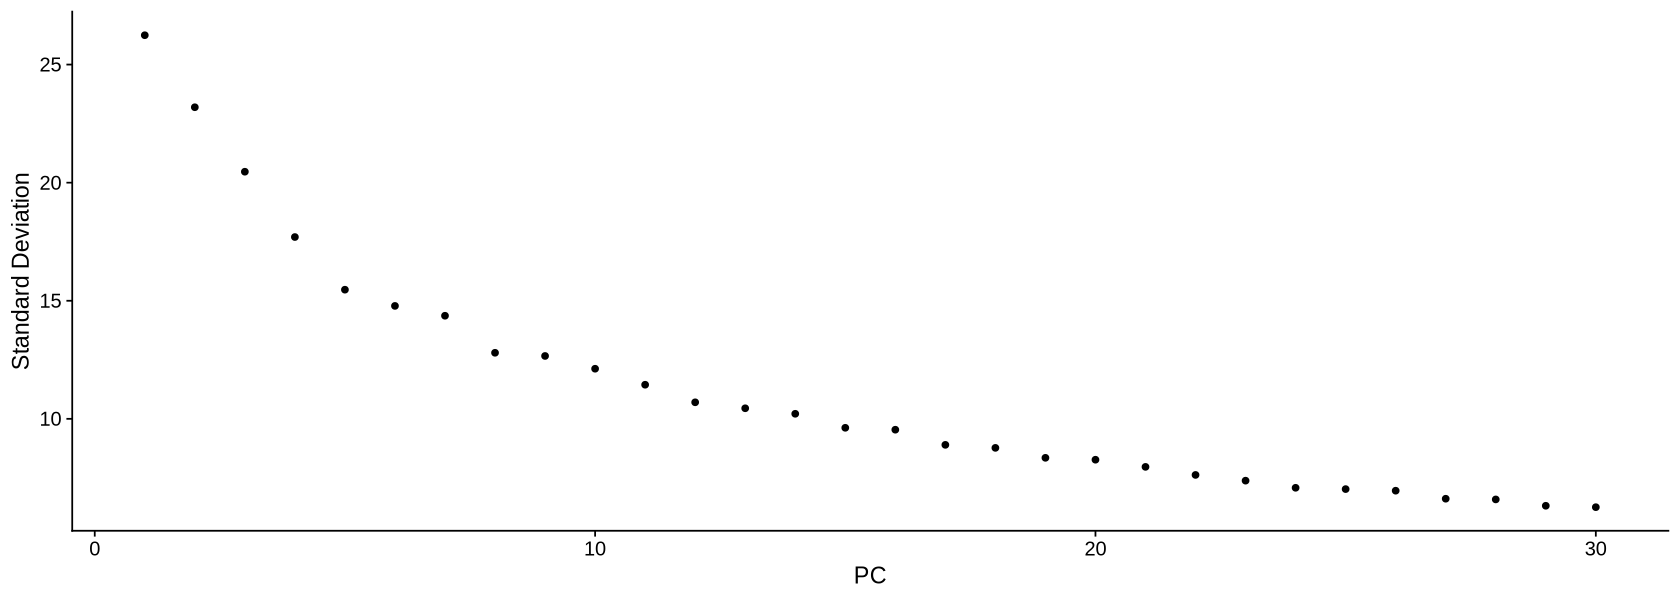

In [35]:
#| label: fig-elbow
#| fig-cap: "Elbow plot of the first 30 principal components calculated from the data"

ElbowPlot(WT_Control1_10dpi_seurat_norm, ndims = 30)

We calculate the projection using the UMAP algorithm (@mcinnes_umap_2018, @becht_dimensionality_2019). The parameters `a` and `b` will change how stretched or sparsed the data looks like. When you do your own UMAP projection, you can avoid setting `a` and `b`, and those will be chosen automatically by the command.

In [36]:
WT_Control1_10dpi_seurat_norm <- RunUMAP(object = WT_Control1_10dpi_seurat_norm, 
                                         a = .8, b=1,
                                         dims = 1:10, 
                                         verbose = FALSE, 
                                         seed.use = 123)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



In @fig-umap we can see the resulting projection. The result looks pretty neat and structured (we can clearly see there are various clusters).

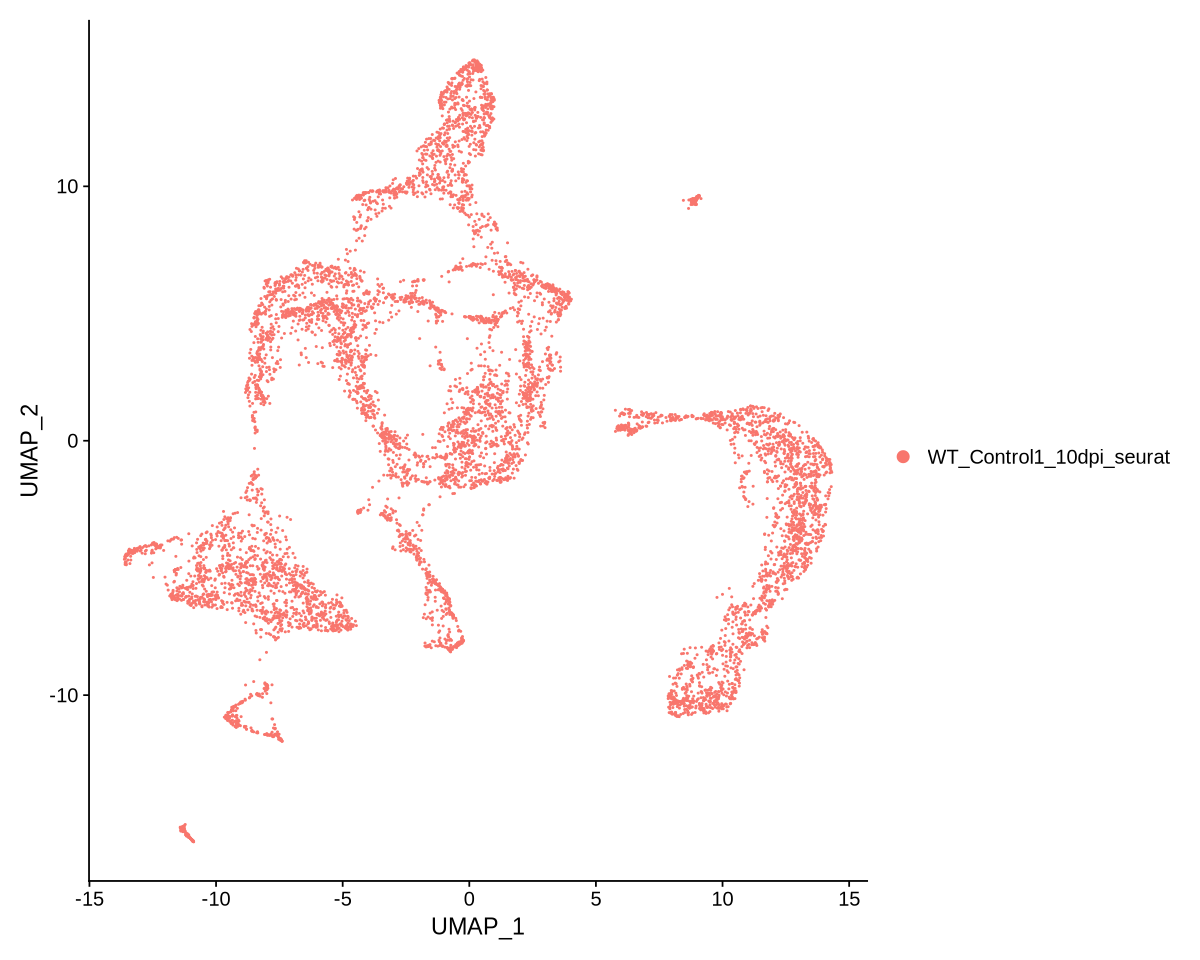

In [37]:
#| label: fig-umap
#| fig-cap: "UMAP projection of the data"

options(repr.plot.width=10, repr.plot.height=8)
UMAPPlot(object = WT_Control1_10dpi_seurat_norm)

## Removing doublets

Doublets removal is part of filtering, but it needs normalized data to work. This is why we do it after using `SCtransform`.

Doublets (and the very rare multiplets) refer to droplets that **contain the transcriptional profiles of two or more distinct cells**. Doublets can occur during the cell dissociation process or when two or more cells are captured in the same droplet during the library preparation step.

It is quite obvious that a doublet transcriptional profile can confound downstream analyses, such as cell clustering and differential gene expression analysis. Most doublet detectors, like `DoubletFinder` (@mcginnis_doubletfinder_2019) which we will use, ** simulates doublets and then finds cells in the data which are similar to the simulated doublets**. Most such packages need an idea of the number/proportion of expected doublets in the dataset. **As indicated from the Chromium user guide, expected doublet rates are about as follows:**

![Table of expected doublet rates based on the number of cells.](./images/doublet_rates.png){width=600, #fig-doubletrates}

The data we are using contained about 10000 cells per sample (as in the knee plot at the beginning), hence we can assume that it originates from around 18000 loaded cells and should have a doublet rate at about 7.6%.

::: {.callout-note}
Doublet prediction, like the rest of the filtering, **should be run on each sample separately**.
:::

Here, we apply `DoubletFinder` to predict doublet cells. Most parameters are quite standard, we mostly need to choose `nExp` (expected number of doublets), `PCs` (number of principal components to use), `sct` (use the normalized data). The last three option are not part of the package, but have been added by creating a slightly modified version ([here](https://github.com/SamueleSoraggi/DoubletFinder)) - they allow to use multiple cores and a subset of cells for calculations for a considerable speedup. However, the code takes some time to run, so be patient.

In [38]:
nExp <- round(ncol(WT_Control1_10dpi_seurat_norm) * 0.076)  # expected doublet rate

In [39]:
WT_Control1_10dpi_seurat_norm <- doubletFinder_v3(WT_Control1_10dpi_seurat_norm, 
                                                  pN = 0.25, #proportion of doublets to simulate)
                                                  pK = 0.09, 
                                                  nExp = nExp, 
                                                  PCs = 1:10, 
                                                  sct=TRUE, 
                                                  workers=8, 
                                                  future.globals.maxSize = 8*1024^13,
                                                  seurat.ncells=3000)

Loading required package: fields

Loading required package: spam

Spam version 2.10-0 (2023-10-23) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following object is masked from ‘package:stats4’:

    mle


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridisLite


Try help(fields) to get started.

Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: future



[1] "Creating 2670 artificial doublets..."


Loading required package: sctransform



[1] "Creating Seurat object..."
[1] "Running SCTransform..."


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 23388 by 10680

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3000 cells



  |======================================================================| 100%


Found 151 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 23388 genes



  |======================================================================| 100%


Computing corrected count matrix for 23388 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 2.026269 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



[1] "Running PCA..."


PC_ 1 
Positive:  LotjaGi2g1v0360900, LotjaGi5g1v0359500, LotjaGi6g1v0155900, LotjaGi6g1v0155800, LotjaGi3g1v0321700, LotjaGi3g1v0414900, LotjaGi3g1v0030500, LotjaGi5g1v0211100, LotjaGi3g1v0506700, LotjaGi4g1v0109600 
	   LotjaGi3g1v0009600, LotjaGi1g1v0539300, LotjaGi3g1v0450900, LotjaGi2g1v0269100, LotjaGi3g1v0010900, LotjaGi3g1v0530000, LotjaGi3g1v0373700, LotjaGi4g1v0137700, LotjaGi3g1v0380900, LotjaGi4g1v0309700 
	   LotjaGi1g1v0014300, LotjaGi5g1v0359400, LotjaGi6g1v0071000, LotjaGi3g1v0012400, LotjaGi3g1v0162300, LotjaGi3g1v0554100, LotjaGi1g1v0516900, LotjaGi2g1v0316800, LotjaGi2g1v0285600, LotjaGi2g1v0358600 
Negative:  LotjaGi6g1v0254300, LotjaGi3g1v0068000, LotjaGi6g1v0286800-LC, LotjaGi1g1v0080000, LotjaGi5g1v0005800, LotjaGi5g1v0269800-LC, LotjaGi5g1v0293100-LC, LotjaGi3g1v0222100, LotjaGi1g1v0006200, LotjaGi6g1v0254700 
	   LotjaGi3g1v0358300, LotjaGi3g1v0329100, LotjaGi3g1v0445300, LotjaGi1g1v0646500-LC, LotjaGi2g1v0157900, LotjaGi3g1v0505900, LotjaGi1g1v0022100, LotjaGi

[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


We visualize the UMAP plot and which cells are estimated doublets in @fig-doublets. Fortunately, there are only a few to discard.

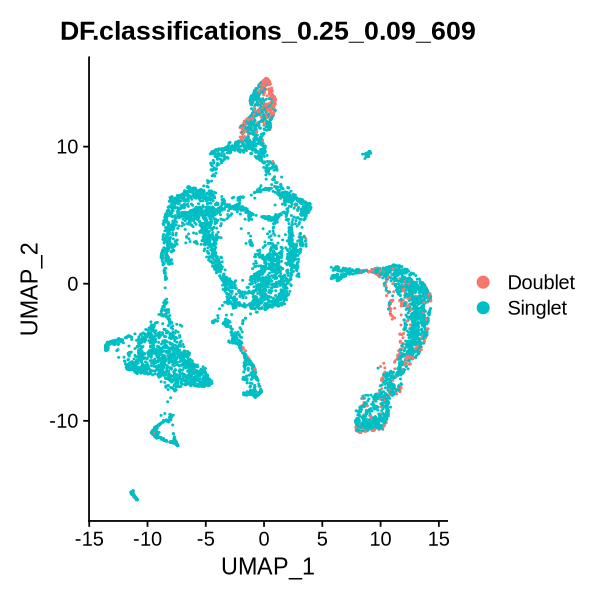

In [41]:
#| label: fig-doublets
#| fig-cap: "UMAP projection of the data coloured by doublet or singlet label"

options(repr.plot.width=5, repr.plot.height=5)

DF.name = colnames(WT_Control1_10dpi_seurat_norm@meta.data)[grepl("DF.classification", colnames(WT_Control1_10dpi_seurat_norm@meta.data))]

DimPlot(WT_Control1_10dpi_seurat_norm, group.by = DF.name)

Sometimes doublets have more detected genes than a single cell. In our case, some of the droplets have higher number of genes than the average (the red violin is large also above 3000 detected genes), so there is probably a portion of doublets. Of course we might remove some actual cells, but it is worth risking that and avoiding including the doublets.

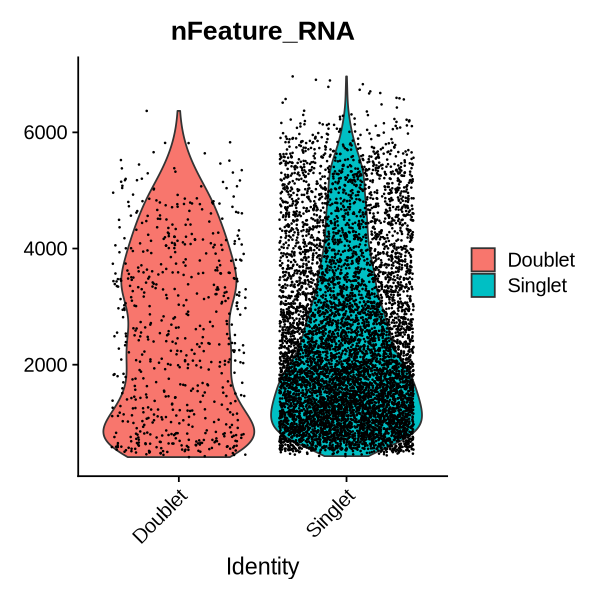

In [42]:
VlnPlot(WT_Control1_10dpi_seurat_norm, features = "nFeature_RNA", group.by = DF.name, pt.size = 0.1)

Here we keep only singlets:

In [43]:
WT_Control1_10dpi_seurat_norm = WT_Control1_10dpi_seurat_norm[, WT_Control1_10dpi_seurat_norm@meta.data[, DF.name] == "Singlet"]

We save our data after all the filtering work!

In [44]:
SaveH5Seurat(object = WT_Control1_10dpi_seurat_norm, 
             filename = "./Results/control1.normalized.h5Seurat", 
             overwrite = TRUE)

Warning message:
“Overwriting previous file control1.normalized.h5Seurat”
Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding data for RNA

No variable features found for RNA

No feature-level metadata found for RNA

Adding counts for SCT

Adding data for SCT

Adding scale.data for SCT

Adding variable features for SCT

No feature-level metadata found for SCT

Writing out SCTModel.list for SCT

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

No JackStraw data for pca

Adding cell embeddings for umap

No loadings for umap

No projected loadings for umap

No standard deviations for umap

No JackStraw data for umap



# Integration {#sec-integration}

Integration of scRNA-seq data is useful to combine datasets from different experimental conditions (in our case the wild-type vs infected) and sequencing runs, to gain a broader understanding of cellular processes. Integration is challenging due to technical variations and biological differences between the datasets (where we want to remove the formers to study correctly the latters).

Before integrating scRNA-seq datasets, we have applyed **quality control and normalization to each sample** to ensure consistency and accuracy of the data. Integration can happen using various methods (@adossa_computational_2021). Seurat uses **canonical correlation analysis (CCA)** (@stuart_comprehensive_2019, @xinming_seurat_2022) to integrate scRNA-seq datasets from different experimental conditions. CCA identifies shared variation between two datasets while accounting for technical differences, such as batch effects.

The shared covariance patterns **can represent biological signals that are common across the datasets**, such as cell types or signaling pathways.

We load another control dataset, and two wild types. Those have been previously preprocessed, so you will not need to. Remember again: each dataset must be preprocessed separately before integration.

In [45]:
WT_Control1_10dpi_seurat_norm <- LoadH5Seurat("./Results/control1.normalized.h5Seurat")

Validating h5Seurat file

Initializing RNA with data

Adding counts for RNA

Adding miscellaneous information for RNA

Initializing SCT with data

Adding counts for SCT

Adding scale.data for SCT

Adding variable feature information for SCT

Adding miscellaneous information for SCT

Adding reduction pca

Adding cell embeddings for pca

Adding feature loadings for pca

Adding miscellaneous information for pca

Adding reduction umap

Adding cell embeddings for umap

Adding miscellaneous information for umap

Adding command information

Adding cell-level metadata

Adding miscellaneous information

Adding tool-specific results



In [46]:
WT_Control2_10dpi_seurat_filt <- LoadH5Seurat("control2.normalized.h5Seurat")
WT_Mloti1_10dpi_seurat_filt <- LoadH5Seurat("wildtype1.normalized.h5Seurat")
WT_Mloti2_10dpi_seurat_filt <- LoadH5Seurat("wildtype2.normalized.h5Seurat")

Validating h5Seurat file

Initializing RNA with data

Adding counts for RNA

Adding miscellaneous information for RNA

Initializing SCT with data

Adding counts for SCT

Adding scale.data for SCT

Adding variable feature information for SCT

Adding miscellaneous information for SCT

Adding reduction pca

Adding cell embeddings for pca

Adding feature loadings for pca

Adding miscellaneous information for pca

Adding reduction umap

Adding cell embeddings for umap

Adding miscellaneous information for umap

Adding command information

Adding cell-level metadata

Adding miscellaneous information

Adding tool-specific results

Validating h5Seurat file

Initializing RNA with data

Adding counts for RNA

Adding miscellaneous information for RNA

Initializing SCT with data

Adding counts for SCT

Adding scale.data for SCT

Adding variable feature information for SCT

Adding miscellaneous information for SCT

Adding reduction pca

Adding cell embeddings for pca

Adding feature loadings for pc

To integrate the datasets, we need to start creating a list with all datasets.

In [47]:
Gifu.list <- list(WT_Control1_10dpi_seurat_norm, 
                  WT_Control2_10dpi_seurat_filt, 
                  WT_Mloti1_10dpi_seurat_filt, 
                  WT_Mloti2_10dpi_seurat_filt)

We then start by normalizing each dataset of the list with `SCtransform`. Here we also have a commented command (with the symbol `#`) that is not executed, to show how you add technical variations to remove, if necessary (this is not the case of the tutorial).

In [48]:
Gifu.list <- lapply(X = Gifu.list, FUN = function(x) {
  #x <- SCTransform(x, vars.to.regress = c("percent.mt",  "percent.chloroplast"), verbose = TRUE)
  x <- SCTransform(x, verbose = TRUE, ncells=3000)
})

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 22528 by 7401

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3000 cells



  |======================================================================| 100%


Found 125 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 22528 genes



  |======================================================================| 100%


Computing corrected count matrix for 22528 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.1102 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21689 by 4005

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3000 cells



  |======================================================================| 100%


Found 114 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 21689 genes



  |======================================================================| 100%


Computing corrected count matrix for 21689 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 43.20294 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21520 by 6407

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3000 cells



  |======================================================================| 100%


Found 131 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 21520 genes



  |======================================================================| 100%


Computing corrected count matrix for 21520 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 48.8333 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 20089 by 3556

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3000 cells



  |======================================================================| 100%


Found 139 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 20089 genes



  |======================================================================| 100%


Computing corrected count matrix for 20089 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 38.20611 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



Now we apply the CCA (Canonical Correlation Analysis) to put datasets together according to their similarities, while removing differences. The number of genes to use during integration is expressed below as `nfeatures`. We choose a reasonable number of features: the highest top decile of the variance amongst the datasets to integrate.

In [60]:
quartiles <- c()
for(x in Gifu.list){
  variances <- apply(x[['RNA']]@counts, 1, var)
  cat('N genes with top quantile in dataset: ')
  cat( sum(variances>quantile(variances, .75)) )
  cat('\n')
  quartiles <- c(quartiles, sum(variances>quantile(variances, .75)))
}
cat('Chosen value: ')
cat(max(quartiles))

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”


N genes with top quantile in dataset: 5960
N genes with top quantile in dataset: 5803


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.1 GiB”


N genes with top quantile in dataset: 5735
N genes with top quantile in dataset: 5458
Chosen value: 5960

In [61]:
Gifu.features <- SelectIntegrationFeatures(object.list = Gifu.list, nfeatures = max(quartiles))

Gifu.list <- PrepSCTIntegration(object.list = Gifu.list, anchor.features = Gifu.features)

In [62]:
Gifu.anchors <- FindIntegrationAnchors(object.list = Gifu.list, normalization.method = "SCT", 
                                       anchor.features = Gifu.features, reference = c(1,2))

seurat.integrated <- IntegrateData(anchorset = Gifu.anchors, normalization.method = "SCT")

Warning message in CheckDuplicateCellNames(object.list = object.list):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Finding anchors between all query and reference datasets

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 12625 anchors

Filtering anchors

	Retained 12528 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 12780 anchors

Filtering anchors

	Retained 12141 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 10035 anchors

Filtering anchors

	Retained 9460 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 10362 anchors

Filtering anchors

	Retained 10181 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 8765 anchors

Filtering anchors

	Retained 8610 anchors

Building integrated reference

Merging dataset 2 into 1

Extracting anchors for merged samples

F

Now the default assay used for analysis has changed into `integrated`:

In [63]:
cat("The default assay of the data is now called: ")
cat(DefaultAssay(seurat.integrated))

The default assay of the data is now called: integrated

We need to recalculate PCA and UMAP to look at all datasets integrated together. We choose again 10 principal components from the elbow plot.

In [64]:
seurat.integrated <- RunPCA(object = seurat.integrated, verbose = FALSE)

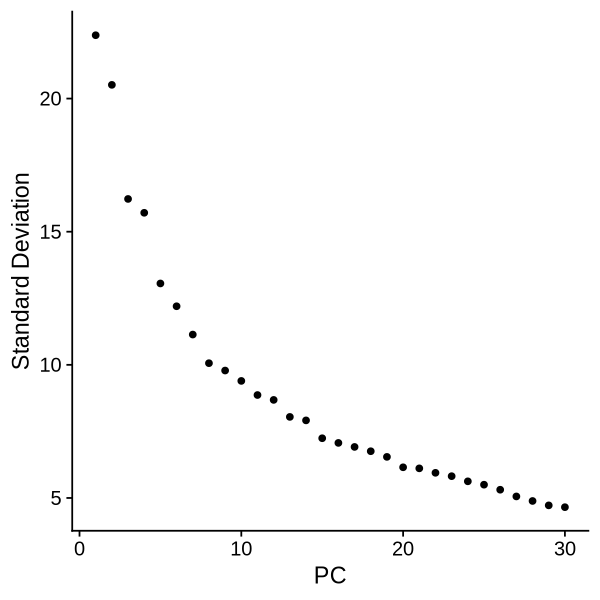

In [65]:
#| label: fig-elbowint
#| fig-cap: "Elbow plot of integrated datasets"

ElbowPlot(seurat.integrated, ndims = 30)

In [66]:
seurat.integrated <- FindNeighbors(object = seurat.integrated, dims = 1:10, k.param = 5)

Computing nearest neighbor graph

Computing SNN



In [67]:
seurat.integrated <- RunUMAP(object = seurat.integrated, dims = 1:10)

13:51:31 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

13:51:31 Read 21369 rows and found 10 numeric columns

13:51:31 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

13:51:31 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:51:35 Writing NN index file to temp file /tmp/Rtmpkm90yH/file9e550d567ee

13:51:35 Searching Annoy index using 8 threads, search_k = 3000

13:51:37 Annoy recall = 100%

13:51:38 Commencing smooth kNN distance calibration using 8 threads
 with target n_neighbors = 30

13:51:40 Initializing from normalized Laplacian +

We save our integrated data

In [68]:
SaveH5Seurat(object = seurat.integrated, filename = "./Results/seurat.integrated.h5Seurat", overwrite=TRUE)

Warning message:
“Overwriting previous file seurat.integrated.h5Seurat”
Creating h5Seurat file for version 3.1.5.9900

Adding counts for SCT

Adding data for SCT

Adding scale.data for SCT

No variable features found for SCT

No feature-level metadata found for SCT

Writing out SCTModel.list for SCT

Adding counts for RNA

Adding data for RNA

No variable features found for RNA

No feature-level metadata found for RNA

Adding data for integrated

Adding scale.data for integrated

Adding variable features for integrated

No feature-level metadata found for integrated

Writing out SCTModel.list for integrated

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

No JackStraw data for pca

Adding cell embeddings for umap

No loadings for umap

No projected loadings for umap

No standard deviations for umap

No JackStraw data for umap



## Clustering and cell type assignment

We perform clustering on the data using the leiden algorithm (blondel_fast_2008, @traag_louvain_2019). Then, we look at the usual strategy of naming clusters using markers. Since this is very subjective and biased, we then resort to naming cell types using a reference annotated dataset. We will also briefly look into the use fo gene ontologies to name clusters. An overview of cell type assignment procedures can be found at @cheng_review_2023.

In [5]:
seurat.integrated <-  LoadH5Seurat("./Results/seurat.integrated.h5Seurat")

Validating h5Seurat file

Initializing RNA with data

Adding counts for RNA

Adding miscellaneous information for RNA

Initializing SCT with data

Adding counts for SCT

Adding scale.data for SCT

Adding miscellaneous information for SCT

Initializing integrated with data

Adding scale.data for integrated

Adding variable feature information for integrated

Adding miscellaneous information for integrated

Adding reduction pca

Adding cell embeddings for pca

Adding feature loadings for pca

Adding miscellaneous information for pca

Adding reduction umap

Adding cell embeddings for umap

Adding miscellaneous information for umap

Adding graph integrated_nn

Adding graph integrated_snn

Adding command information

Adding cell-level metadata

Adding miscellaneous information

Adding tool-specific results

Adding data that was not associated with an assay

Warning message:
“Adding a command log without an assay associated with it”


Clustering. The resolution is used to change the number of clusters. We do not need many, so we set on to 0.25. Usual values range between 0.1 and 1.

In [6]:
seurat.integrated <- FindClusters(object = seurat.integrated, resolution = .25)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 21369
Number of edges: 180442

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9628
Number of communities: 19
Elapsed time: 0 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


The clusters are saved in the meta data table as `integrated_snn_res.0.25`. Note that the name changes with the resolution. Also observe how much metadata we have: many columns come from tools we have applied, such as doubletfinder (DF) and nearest neighbor distances (snn).

In [7]:
head( seurat.integrated@meta.data )

nCount_RNA nFeature_RNA nCount_SCT nFeature_SCT
AAACCCAAGGGCAGTT-1_1  3567      1919         4618       1919        
AAACCCACATGATCTG-1_1 20942      4711         4990       2158        
AAACCCAGTAGCTTGT-1_1 29105      5157         4988       2134        
AAACCCAGTCTCTCAC-1_1  6115      2124         5624       2124        
AAACCCATCACCTTGC-1_1  7410      2988         5891       2986        
AAACGAAAGTCCTGTA-1_1  5616      2034         5501       2034        
                     orig.ident               Condition percent.mt
AAACCCAAGGGCAGTT-1_1 WT_Control1_10dpi_seurat Control   4.6818054 
AAACCCACATGATCTG-1_1 WT_Control1_10dpi_seurat Control   0.4775093 
AAACCCAGTAGCTTGT-1_1 WT_Control1_10dpi_seurat Control   0.2954819 
AAACCCAGTCTCTCAC-1_1 WT_Control1_10dpi_seurat Control   1.6026165 
AAACCCATCACCTTGC-1_1 WT_Control1_10dpi_seurat Control   0.5263158 
AAACGAAAGTCCTGTA-1_1 WT_Control1_10dpi_seurat Control   0.7122507 
                     percent.chloroplast pANN_0.25_0.09_609
AAACCCAAGGGCAGTT-1_1 0.02803476          0.1810614         
AAACCCACATGATCTG-1_1 0.12415242          0.2278876         
AAACCCAGTAGCTTGT-1_1 0.05497337          0.2601457         
AAACCCAGTCTCTCAC-1_1 0.01635323          0.1841831         
AAACCCATCACCTTGC-1_1 0.09446694          0.2455775         
AAACGAAAGTCCTGTA-1_1 0.10683761          0.2133195         
                     DF.classifications_0.25_0.09_609 pANN_0.25_0.09_329
AAACCCAAGGGCAGTT-1_1 Singlet                          NA                
AAACCCACATGATCTG-1_1 Singlet                          NA                
AAACCCAGTAGCTTGT-1_1 Singlet                          NA                
AAACCCAGTCTCTCAC-1_1 Singlet                          NA                
AAACCCATCACCTTGC-1_1 Singlet                          NA                
AAACGAAAGTCCTGTA-1_1 Singlet                          NA                
                     DF.classifications_0.25_0.09_329 pANN_0.25_0.09_309
AAACCCAAGGGCAGTT-1_1 NA                               NA                
AAACCCACATGATCTG-1_1 NA                               NA                
AAACCCAGTAGCTTGT-1_1 NA                               NA                
AAACCCAGTCTCTCAC-1_1 NA                               NA                
AAACCCATCACCTTGC-1_1 NA                               NA                
AAACGAAAGTCCTGTA-1_1 NA                               NA                
                     DF.classifications_0.25_0.09_309 pANN_0.25_0.09_110
AAACCCAAGGGCAGTT-1_1 NA                               NA                
AAACCCACATGATCTG-1_1 NA                               NA                
AAACCCAGTAGCTTGT-1_1 NA                               NA                
AAACCCAGTCTCTCAC-1_1 NA                               NA                
AAACCCATCACCTTGC-1_1 NA                               NA                
AAACGAAAGTCCTGTA-1_1 NA                               NA                
                     DF.classifications_0.25_0.09_110 integrated_snn_res.0.25
AAACCCAAGGGCAGTT-1_1 NA                               0                      
AAACCCACATGATCTG-1_1 NA                               7                      
AAACCCAGTAGCTTGT-1_1 NA                               9                      
AAACCCAGTCTCTCAC-1_1 NA                               1                      
AAACCCATCACCTTGC-1_1 NA                               12                     
AAACGAAAGTCCTGTA-1_1 NA                               15                     
                     seurat_clusters
AAACCCAAGGGCAGTT-1_1 0              
AAACCCACATGATCTG-1_1 7              
AAACCCAGTAGCTTGT-1_1 9              
AAACCCAGTCTCTCAC-1_1 1              
AAACCCATCACCTTGC-1_1 12             
AAACGAAAGTCCTGTA-1_1 15

We can plot the clusters in the UMAP plot

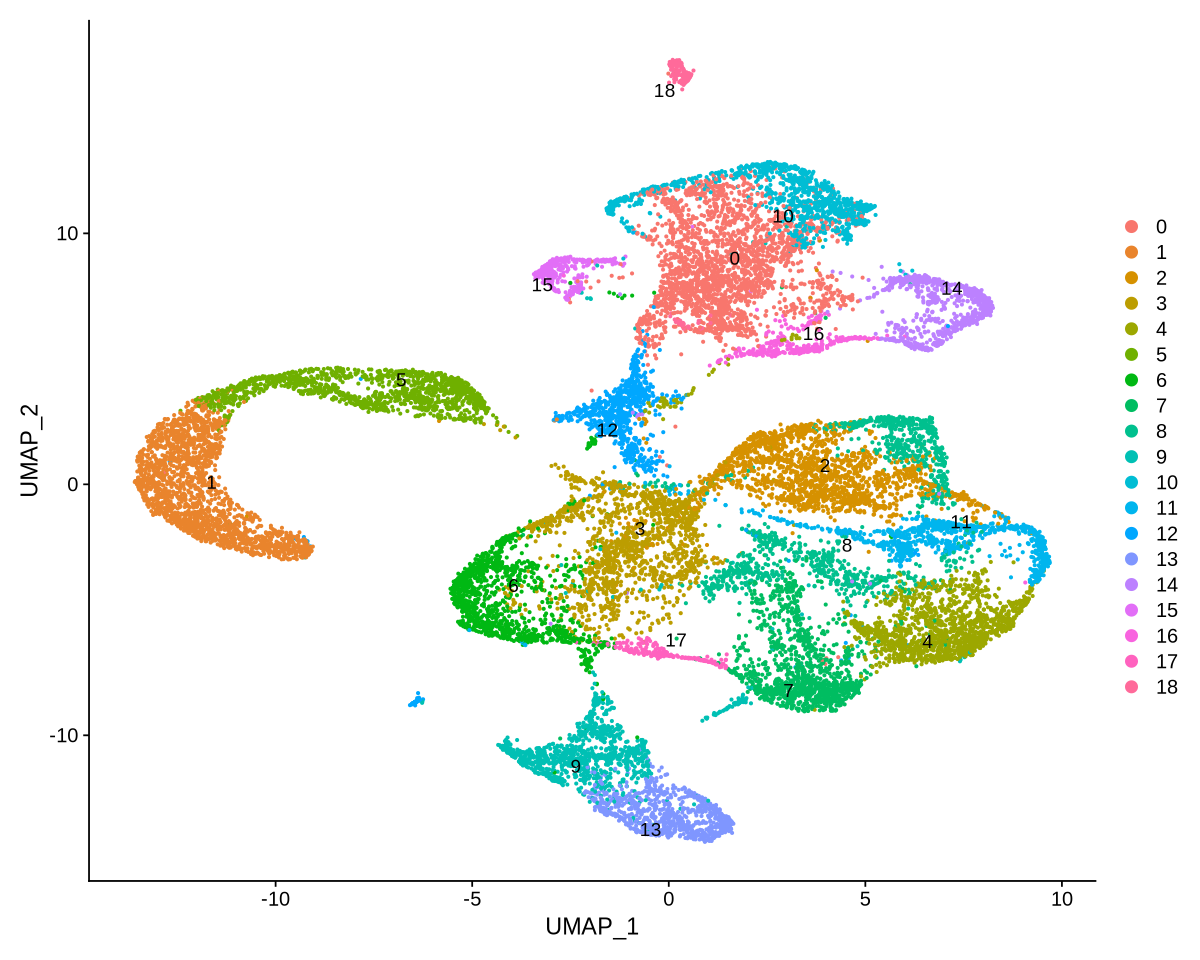

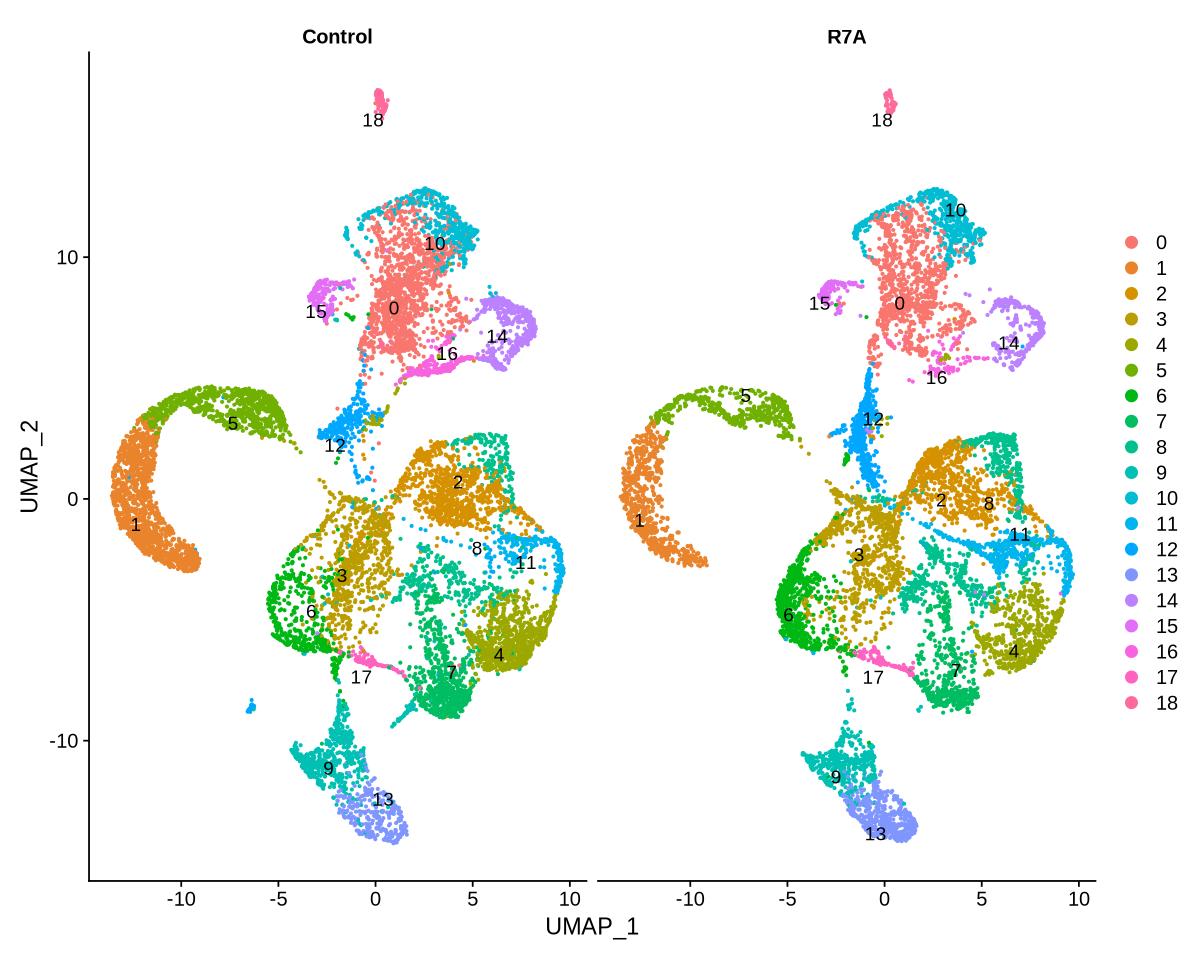

In [8]:
options(repr.plot.width=10, repr.plot.height=8)
DimPlot(object = seurat.integrated, reduction = "umap",  label = T, repel = TRUE, pt.size = 0.5)
DimPlot(object = seurat.integrated, reduction = "umap",  label = T, repel = TRUE, pt.size = 0.5, split.by = "Condition")

### Cluster assignment from visualized marker scores

Here, we look at how to assign names based on known markers. In this procedure, biological knowledge of the cell types is needed. Below, there is a list of known markers for each cell type, extracted from the supplementary data of @frank_single-cell_2023.

In [9]:
features_list <- list(
    'Cortex_scoring' = c("LotjaGi1g1v0006200",
                 "LotjaGi1g1v0022100",
                 "LotjaGi1g1v0261700",
                 "LotjaGi1g1v0348000",
                 "LotjaGi2g1v0303000",
                 "LotjaGi3g1v0505900"),
    'Epidermis_scoring' = c("LotjaGi1g1v0080000",
                    "LotjaGi1g1v0377600",
                    "LotjaGi1g1v0613100",
                    "LotjaGi3g1v0070500"),
    'Endodermis_scoring' = c("LotjaGi1g1v0114400",
                     "LotjaGi1g1v0221300",
                     "LotjaGi1g1v0240900-LC",
                     "LotjaGi1g1v0707500"), 
    'RootCap_scoring' = c("LotjaGi1g1v0020900",
                   "LotjaGi1g1v0039700-LC",
                   "LotjaGi1g1v0040300",
                   "LotjaGi1g1v0147500"),  
    'Meristem_scoring'= c("LotjaGi4g1v0300900",
                         "LotjaGi6g1v0056500",
                         "LotjaGi1g1v0594200"),
    'Phloem_scoring'= c("LotjaGi1g1v0028800",
                "LotjaGi1g1v0085900",
                "LotjaGi1g1v0119300",
                "LotjaGi1g1v0149100"),
    'QuiescentCenter_scoring' = c("LotjaGi1g1v0004300",
                           "LotjaGi1g1v0021400",
                           "LotjaGi1g1v0052700",
                           "LotjaGi1g1v0084000"),
    'RootHair_scoring'= c("LotjaGi1g1v0014300",
                   "LotjaGi1g1v0109000",
                   "LotjaGi1g1v0109100",
                   "LLotjaGi1g1v0143900"),  
    'Pericycle_scoring'= c("LotjaGi3g1v0222100",
                   "LotjaGi3g1v0395900-LC",
                   "LotjaGi5g1v0166000-LC",
                   "LotjaGi3g1v0395500-LC",
                   "LotjaGi1g1v0783700-LC",
                   "LotjaGi2g1v0333200",
                   "LotjaGi4g1v0293000-LC"),     
    'Stele_scoring' = c("LotjaGi2g1v0126700",
                "LotjaGi1g1v0558200",
                "LotjaGi4g1v0215500",
                "LotjaGi3g1v0174100",
                "LotjaGi5g1v0288600",
                "LotjaGi3g1v0129700"),
    'Xylem_scoring' = c("LotjaGi1g1v0623100",
                "LotjaGi1g1v0569300",
                "LotjaGi1g1v0443000",
                "LotjaGi1g1v0428800")
    )

Here, we need a function calculating the scores for each cell type. This is the average expression of the markers in the list, from which we remove the average expression of some control genes, which are supposed not to be specific for the cell type of interest. The cells matching the desired type should retain a high score.

In [10]:
seurat.clustered <- AddModuleScore(
  object = seurat.integrated,
  features = features_list,
  ctrl = 5,
  name = 'LJ_scores'
)

Warning message:
“The following features are not present in the object: LLotjaGi1g1v0143900, not searching for symbol synonyms”


We create a simple function to plot nicely all the scores on the UMAP plot. Again, this is mostly rearrangine names and plotting stuff, so do not look at the code

In [41]:
plotScoresUMAP <- function(markers_list, 
                           seurat_data, 
                           repr.plot.width=20,
                           repr.plot.height=18){
    L <- length(names(seurat_data@meta.data))
    F <- length(names(markers_list))-1
    newnames <- names(seurat_data@meta.data)
    newnames[(L-F):L] <- names(markers_list)
    names(seurat_data@meta.data) <- newnames
    for(N in names(seurat_data@meta.data)[(L-F):L])
        seurat_data@meta.data[N] <- seurat_data@meta.data[N] / 
                                            max(seurat_data@meta.data[N])
    options(repr.plot.width=repr.plot.width, repr.plot.height=repr.plot.height)

    FeaturePlot(seurat_data, 
            reduction = "umap", 
            features = names(markers_list), 
            order = TRUE,
            min.cutoff = 0,
            label = TRUE, 
            label.size = 7) + theme(legend.position = "right")

    return(seurat_data)
    }

Now we run the function. In @fig-scores we can see that some clusters are easy to classify (phloem and xylem), but many others are not. This is mainly due to the fact that many cell types change across a continuum, and this manual annotation is very subjective.

In [12]:
#| label: fig-scores
#| fig-cap: "Scores of the list of markers for the Lotus Japonicus clusters"

seurat.clustered = plotScoresUMAP(markers_list = features_list,
              seurat_data = seurat.clustered)

Just for the sake of the exercise, we set some names to the clusters below, at least for those ones that are well identifiable. Note that we use `idents` to define which is the clustering to be considered in use in the data.

In [13]:
Idents(seurat.clustered) <- 'integrated_snn_res.0.25'

seurat.clustered <- RenameIdents(object = seurat.clustered,
                               "2"="Cortex", "8"="Cortex", "4"="Cortex", "11"="Cortex",
                               "6"="Epidermis",
                               "14"="Endodermis",  
                               "1"="Root_Cap", "5"="Root_Cap",
                               "15"="Phloem",
                               "9"="Root_Hair", "13"="Root_Hair",
                               "0"="Pericycle_Stele", "10"="Pericycle",
                               "16"="Stele",
                               "18"="Xylem")

we saved the renamed clusters in the metadata under `Cell_types`

In [14]:
seurat.clustered@meta.data$Cell_types <- Idents(seurat.clustered)

It seems we named most clusters. For some others we could not really be sure of the markers, and we will use the reference-based assignment.

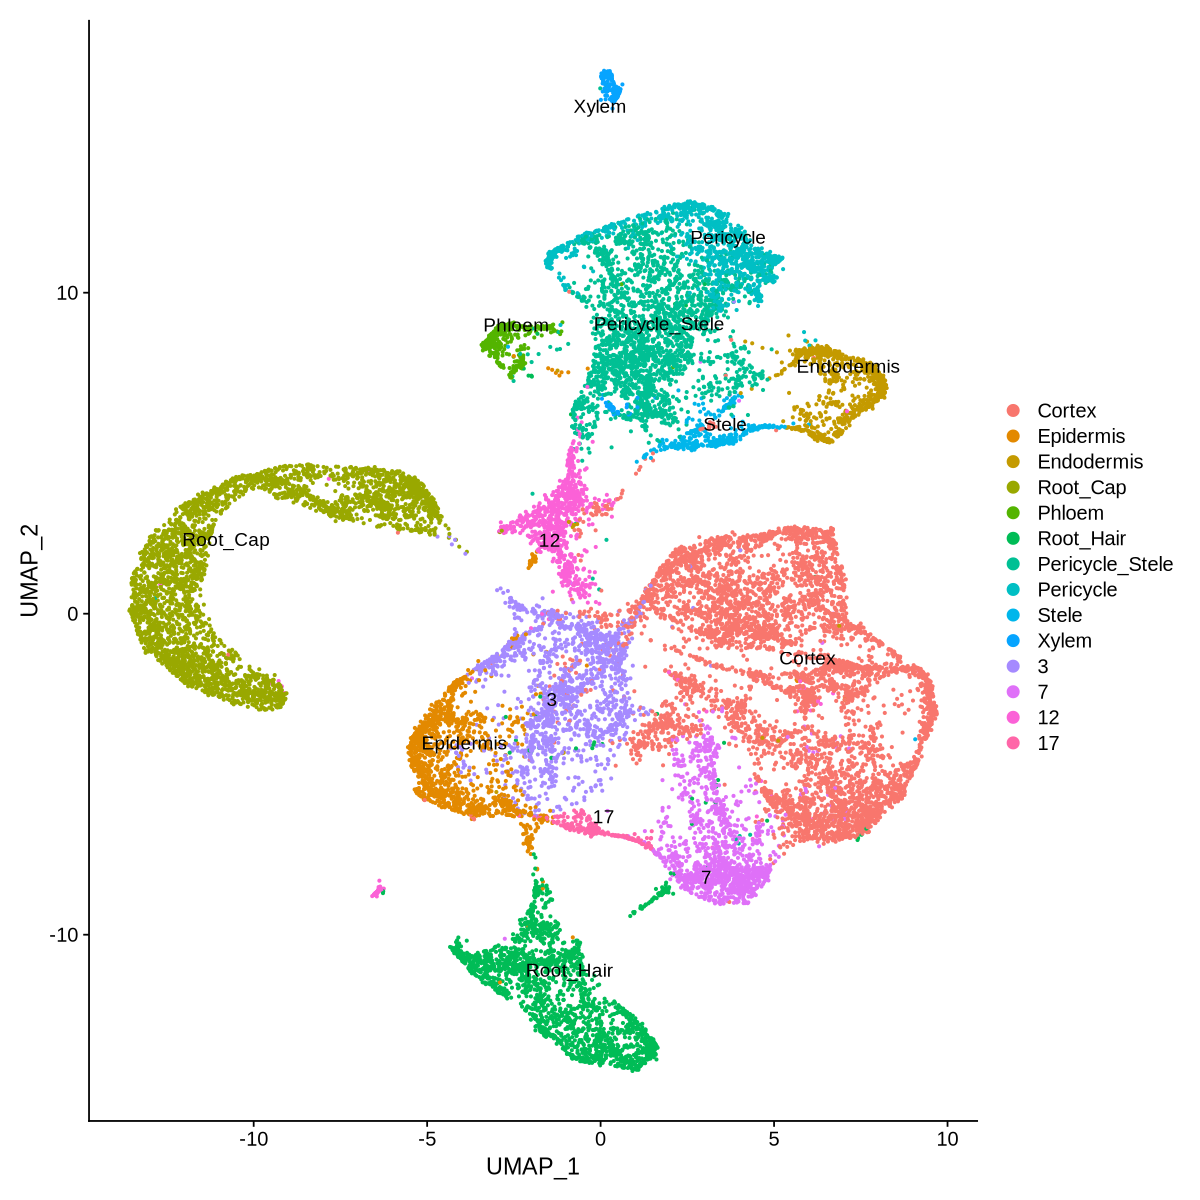

In [15]:
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(object = seurat.clustered, reduction = "umap", repel = TRUE, label=T, pt.size = 0.5)

#### Optional: assigning a mixed cluster

The cluster `Pericycle_Stele` is probably a mix of the Pericycle and Stele, because it shows markers from both. We can assign at each cell of the cluster one of the cell types based on which marker score is highest. First we save the old clustering in the metadata to avoid losing it

In [16]:
seurat.clustered@meta.data$Cell_types_old <- Idents(seurat.clustered)

and then reassign the name to the cluster `Pericycle_Stele` checking the markers score of each cell.

In [17]:
peri = seurat.clustered@meta.data$Pericycle_scoring[seurat.clustered@meta.data$Cell_types == 'Pericycle_Stele']
stel = seurat.clustered@meta.data$Stele_scoring[seurat.clustered@meta.data$Cell_types == 'Pericycle_Stele']
peri_stele = peri>=stel
finalcl = c()
for(i in peri_stele)
    finalcl = c(finalcl, ifelse(i, "Pericycle", "Stele"))

seurat.clustered@meta.data$Cell_types[seurat.clustered@meta.data$Cell_types == 'Pericycle_Stele'] = finalcl
Idents(seurat.clustered) <- seurat.clustered@meta.data$Cell_types

We managed to get a meaningful separation between the two clusters!

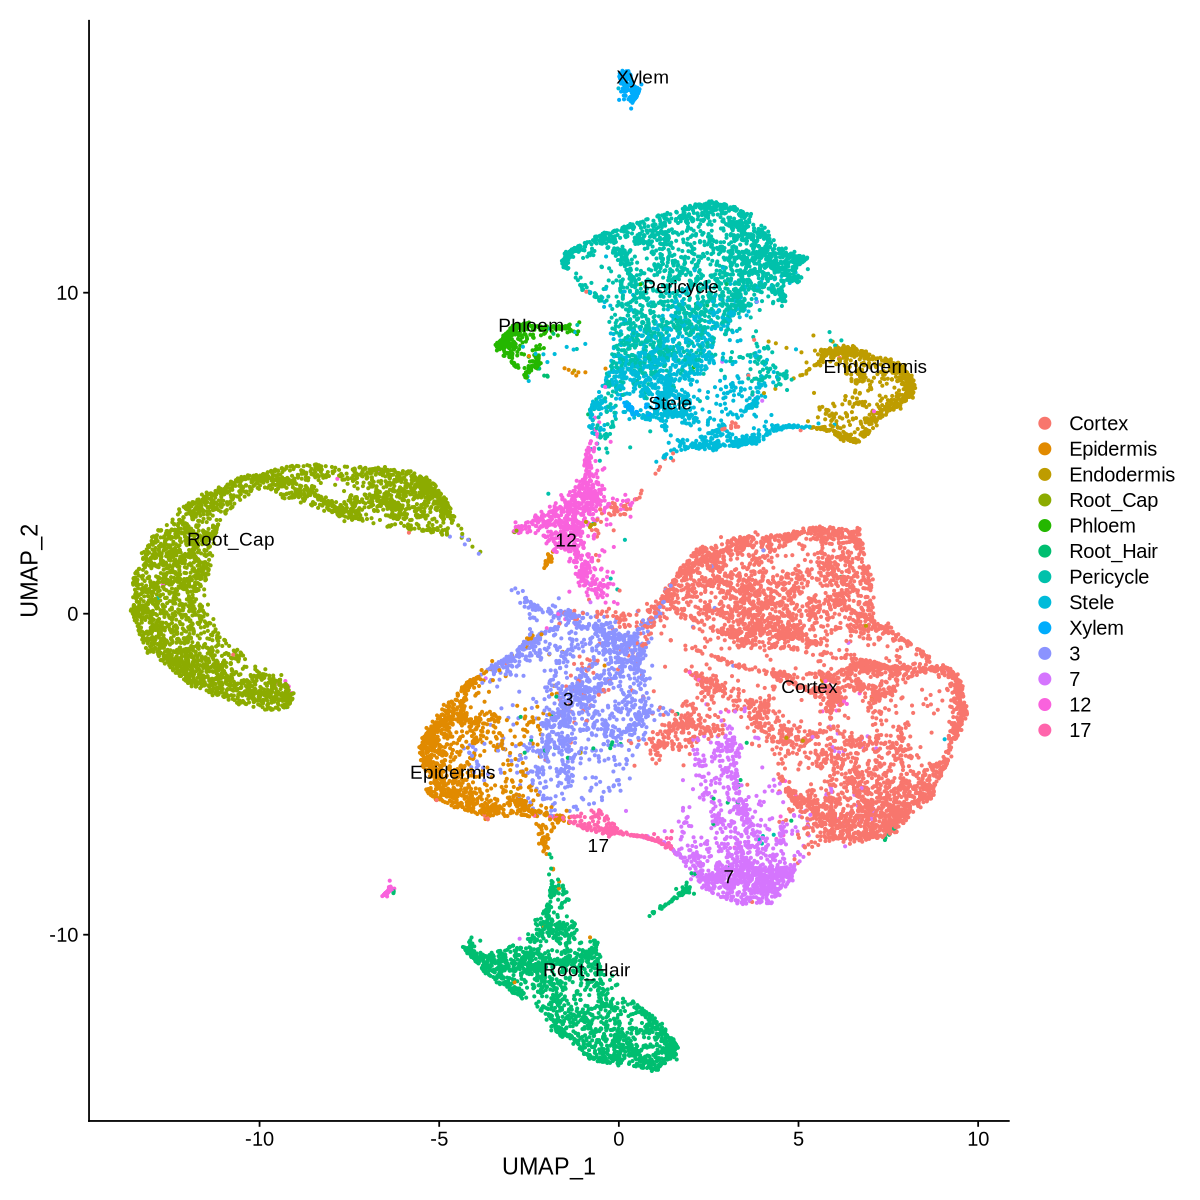

In [18]:
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(object = seurat.clustered, reduction = "umap", repel = TRUE, label=T, pt.size = 0.5)

### Cluster assignment from an annotated dataset

We now use the annotated data from @frank_single-cell_2023 (which is the same we are using in the tutorial) to transfer data labels to our own processed data. More about label transfer can be read at @stuart_comprehensive_2019. We load the data from the paper and define reference and query data. 

In [20]:
seurat.reference <- readRDS("data_lavinia.RDS")

In [21]:
seurat.query <- seurat.clustered

We have to define the data integration between query and reference before we can transfer the cluster names. For the algorithm to work, we need to use the "RNA" assay, which contains raw expression values.

In [23]:
DefaultAssay(seurat.query) <- "RNA"

In [24]:
lotusjaponicus.anchors <- FindTransferAnchors(reference = seurat.reference, 
                                        features = intersect( rownames(seurat.query), 
                                                   rownames( seurat.reference[['SCT']]@scale.data ) ),
                                        query = seurat.query, dims = 1:10, 
                                        reference.reduction = "pca",
                                        reference.assay='RNA')
#predictions <- TransferData(anchorset = lotusjaponicus.anchors, refdata = Idents(seurat.reference), dims = 1:10)
#seurat.clustered <- AddMetaData(seurat.clustered, metadata = predictions)

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 33531 anchors

Filtering anchors

	Retained 11781 anchors



Calculating the integration takes time. So we save the calculated anchors for the integration. If you need to rerun the code, skip the command above and instead load the data with `readRDS` below.

In [25]:
saveRDS(lotusjaponicus.anchors, file = "./Results/anchors.RDS")

In [26]:
lotusjaponicus.anchors <- readRDS("./Results/anchors.RDS")

Now it is finally time to transfer the labels and add them to the metadata under the column `predicted.id`.

In [27]:
predictions <- TransferData(anchorset = lotusjaponicus.anchors, 
                            refdata = Idents(seurat.reference), 
                            dims = 1:10)

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [28]:
seurat.clustered <- AddMetaData(seurat.clustered, metadata = predictions['predicted.id'])

Just as a reminder of what is in the metadata, we can quickly look at the column names. Those are ordered by when we added things along the analysis. If you read the names, you can recognize part of the analysis steps until now.

In [29]:
names( seurat.clustered@meta.data )

[1] "nCount_RNA"                       "nFeature_RNA"                    
 [3] "nCount_SCT"                       "nFeature_SCT"                    
 [5] "orig.ident"                       "Condition"                       
 [7] "percent.mt"                       "percent.chloroplast"             
 [9] "pANN_0.25_0.09_609"               "DF.classifications_0.25_0.09_609"
[11] "pANN_0.25_0.09_329"               "DF.classifications_0.25_0.09_329"
[13] "pANN_0.25_0.09_309"               "DF.classifications_0.25_0.09_309"
[15] "pANN_0.25_0.09_110"               "DF.classifications_0.25_0.09_110"
[17] "integrated_snn_res.0.25"          "seurat_clusters"                 
[19] "Cortex_scoring"                   "Epidermis_scoring"               
[21] "Endodermis_scoring"               "RootCap_scoring"                 
[23] "Meristem_scoring"                 "Phloem_scoring"                  
[25] "QuiescentCenter_scoring"          "RootHair_scoring"                
[27] "Pericycle_scoring"                "Stele_scoring"                   
[29] "Xylem_scoring"                    "Cell_types"                      
[31] "Cell_types_old"                   "predicted.id"

Here we define as clustering for the data and the plots, the one transfered just before. We then have a look at @fig-transfer to observe that the labels look fine.

In [30]:
Idents(seurat.clustered) <- 'predicted.id'

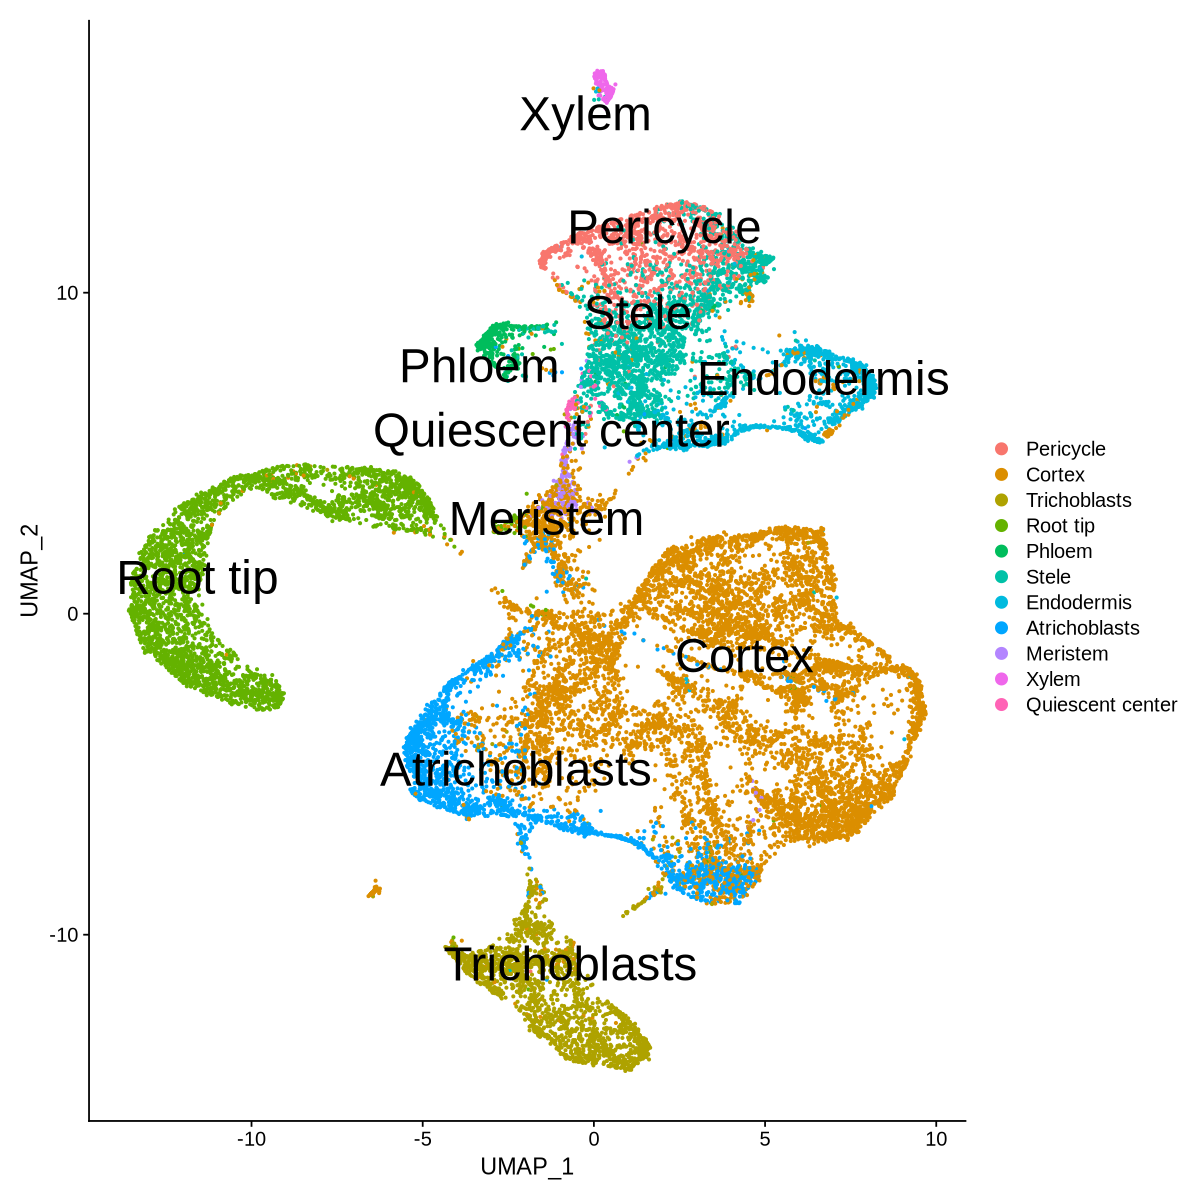

In [31]:
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(object = seurat.clustered, 
        reduction = "umap", 
        repel = TRUE, label=T, 
        pt.size = 0.5, label.size = 10, )

We save the data

In [32]:
SaveH5Seurat(object = seurat.clustered, 
             filename = "seurat.clustered.h5Seurat", 
             overwrite = TRUE)

Warning message:
“Overwriting previous file seurat.clustered.h5Seurat”
Creating h5Seurat file for version 3.1.5.9900

Adding data for integrated

Adding scale.data for integrated

Adding variable features for integrated

No feature-level metadata found for integrated

Writing out SCTModel.list for integrated

Adding counts for RNA

Adding data for RNA

No variable features found for RNA

No feature-level metadata found for RNA

Adding counts for SCT

Adding data for SCT

Adding scale.data for SCT

No variable features found for SCT

No feature-level metadata found for SCT

Writing out SCTModel.list for SCT

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

No JackStraw data for pca

Adding cell embeddings for umap

No loadings for umap

No projected loadings for umap

No standard deviations for umap

No JackStraw data for umap



# Gene Expression Analysis {#sec-geneanalysis}

In this section we explore the gene expression through

- inferring **conserved genes** across all treatments in the integrated dataset. Conserved genes are the ones preserving their expression across the grouping of interest.
- determining **differentially expressed genes** for the infected sample against the wild type. Differentially expressed genes are significantly more epressed in one of the two groups used for the comparison. Usually the wild type is used as query for the comparison, such that differentially expressed genes are referred to the perturbated condition (infection, knock-out, illness, ...)
- studying **coexpression modules** to find if
    - any of them contains the gene of interest,
    - they are significantly more expressed in specific cell groups (**Differential module expression**)
    - if there are specific known functions associated to some modules

A module is a group of gene similarly expressed across cells in the data.

## Conserved markers

We detect **conserved markers** across wildtype and infected datasets. Below, we define a function that detect the conserved markers for each cell type, and calculates the average log-fold change of each conserved gene. The log-fold change is the magnitude of change of the gene expression in the cluster of interest against the rest of the data. This means that a marker with a high log-fold change and a significant p-value is also **differentially expressed in a specific cluster across the two conditions**.

In [5]:
seurat.clustered <- LoadH5Seurat("seurat.clustered.h5Seurat")

Validating h5Seurat file

Initializing RNA with data

Adding counts for RNA

Adding miscellaneous information for RNA

Initializing SCT with data

Adding counts for SCT

Adding scale.data for SCT

Adding miscellaneous information for SCT

Initializing integrated with data

Adding scale.data for integrated

Adding variable feature information for integrated

Adding miscellaneous information for integrated

Adding reduction pca

Adding cell embeddings for pca

Adding feature loadings for pca

Adding miscellaneous information for pca

Adding reduction umap

Adding cell embeddings for umap

Adding miscellaneous information for umap

Adding graph integrated_nn

Adding graph integrated_snn

Adding command information

Adding cell-level metadata

Adding miscellaneous information

Adding tool-specific results

Adding data that was not associated with an assay

Warning message:
“Adding a command log without an assay associated with it”


In [5]:
get_conserved <- function(cluster){
  FindConservedMarkers(seurat.clustered, 
                       ident.1 = cluster,
                       grouping.var = "Condition",
                       only.pos = TRUE,
                       verbose=TRUE) %>%
    rownames_to_column(var = "gene") %>%
    cbind(cluster_id = cluster, .)
}

clusters <- levels(seurat.clustered@active.ident)
conserved_markers <- map_dfr(c(clusters), get_conserved)
conserved_markers$Average_log2FC <- (conserved_markers$Control_avg_log2FC + conserved_markers$R7A_avg_log2FC) /2
conserved_markers$Max_p_val_adj <- apply(conserved_markers[, c('Control_p_val_adj', 'R7A_p_val_adj')], 1, max)

Testing group R7A: (Pericycle) vs (Cortex, Root tip, Trichoblasts, Endodermis, Atrichoblasts, Meristem, Stele, Quiescent center, Xylem, Phloem)

Testing group Control: (Pericycle) vs (Cortex, Trichoblasts, Root tip, Phloem, Stele, Endodermis, Atrichoblasts, Meristem, Xylem, Quiescent center)

Testing group R7A: (Cortex) vs (Root tip, Trichoblasts, Pericycle, Endodermis, Atrichoblasts, Meristem, Stele, Quiescent center, Xylem, Phloem)

Testing group Control: (Cortex) vs (Pericycle, Trichoblasts, Root tip, Phloem, Stele, Endodermis, Atrichoblasts, Meristem, Xylem, Quiescent center)

Testing group R7A: (Trichoblasts) vs (Cortex, Root tip, Pericycle, Endodermis, Atrichoblasts, Meristem, Stele, Quiescent center, Xylem, Phloem)

Testing group Control: (Trichoblasts) vs (Pericycle, Cortex, Root tip, Phloem, Stele, Endodermis, Atrichoblasts, Meristem, Xylem, Quiescent center)

Testing group R7A: (Root tip) vs (Cortex, Trichoblasts, Pericycle, Endodermis, Atrichoblasts, Meristem, Stele, Quiesce

We can save conserved markers in a csv file. It can be downloaded and opened like a normal excel table to consult it, for example when writing an article or a report.

In [35]:
write.csv(conserved_markers, "conserved_markers.csv")

You can load the table in `R` with `read.csv`

In [36]:
conserved_markers <- read.csv("conserved_markers.csv")

The table contains, for each cluster, the genes that are conserved, the cluster they refer to, the mean log-fold change of the gene compared to the rest of the data, and the maximum p-value (adjusted). There are many other values, which are not of interest for interpreting results: 

In [37]:
head(conserved_markers)

X.2 X.1 X cluster_id gene               R7A_p_val R7A_avg_log2FC R7A_pct.1
1 1   1   1 Pericycle  LotjaGi1g1v0160700 0         1.6520538      0.496    
2 2   2   2 Pericycle  LotjaGi1g1v0258700 0         1.2756727      0.329    
3 3   3   3 Pericycle  LotjaGi1g1v0258800 0         1.3639683      0.443    
4 4   4   4 Pericycle  LotjaGi1g1v0281200 0         0.7617147      0.250    
5 5   5   5 Pericycle  LotjaGi1g1v0481200 0         1.6170327      0.528    
6 6   6   6 Pericycle  LotjaGi1g1v0577300 0         3.1402005      0.406    
  R7A_pct.2 R7A_p_val_adj Control_p_val Control_avg_log2FC Control_pct.1
1 0.013     0              0.000000e+00 1.834959           0.570        
2 0.005     0              0.000000e+00 1.622315           0.318        
3 0.014     0              0.000000e+00 1.900560           0.503        
4 0.007     0              0.000000e+00 1.396615           0.521        
5 0.055     0             2.724667e-250 1.272569           0.610        
6 0.020     0              0.000000e+00 3.539052           0.557        
  Control_pct.2 Control_p_val_adj max_pval      minimump_p_val Average_log2FC
1 0.033          0.000000e+00      0.000000e+00 0              1.743507      
2 0.011          0.000000e+00      0.000000e+00 0              1.448994      
3 0.030          0.000000e+00      0.000000e+00 0              1.632264      
4 0.050          0.000000e+00      0.000000e+00 0              1.079165      
5 0.096         6.650367e-246     2.724667e-250 0              1.444801      
6 0.058          0.000000e+00      0.000000e+00 0              3.339626      
  Max_p_val_adj
1  0.000000e+00
2  0.000000e+00
3  0.000000e+00
4  0.000000e+00
5 6.650367e-246
6  0.000000e+00

We can easily look at the interesting columns:

In [38]:
head( conserved_markers[,c('cluster_id', 'gene', 'Average_log2FC', 'Max_p_val_adj')] )

cluster_id       gene                  Average_log2FC Max_p_val_adj
1    Pericycle        LotjaGi1g1v0160700    1.7435065       0.000000e+00
2    Pericycle        LotjaGi1g1v0258700    1.4489938       0.000000e+00
3    Pericycle        LotjaGi1g1v0258800    1.6322642       0.000000e+00
4    Pericycle        LotjaGi1g1v0281200    1.0791648       0.000000e+00
5    Pericycle        LotjaGi1g1v0481200    1.4448007      6.650367e-246
6    Pericycle        LotjaGi1g1v0577300    3.3396264       0.000000e+00
7    Pericycle        LotjaGi1g1v0601200    0.7432623      2.326566e-118
8    Pericycle        LotjaGi1g1v0657700    1.0277054       0.000000e+00
9    Pericycle        LotjaGi1g1v0698100    0.6776549       0.000000e+00
10   Pericycle        LotjaGi1g1v0783700-LC 2.4837284       0.000000e+00
11   Pericycle        LotjaGi2g1v0008900    1.3958268       0.000000e+00
12   Pericycle        LotjaGi2g1v0252200    0.7862912      1.048405e-283
13   Pericycle        LotjaGi2g1v0333100-LC 1.1792639      5.862321e-210
14   Pericycle        LotjaGi2g1v0361300    0.5619744      7.041613e-146
15   Pericycle        LotjaGi2g1v0379900    0.6228556      2.514982e-100
16   Pericycle        LotjaGi3g1v0162000    1.0909489      1.734752e-191
17   Pericycle        LotjaGi3g1v0222100    4.3552442       0.000000e+00
18   Pericycle        LotjaGi3g1v0395500-LC 1.8980284      2.801535e-160
19   Pericycle        LotjaGi3g1v0395900-LC 2.5929540      1.087998e-194
20   Pericycle        LotjaGi4g1v0030500    0.6637986      8.846777e-287
21   Pericycle        LotjaGi4g1v0056200    1.6359684       0.000000e+00
22   Pericycle        LotjaGi4g1v0189600    0.8260387       3.527467e-82
23   Pericycle        LotjaGi4g1v0241200    0.5522431      8.553612e-293
24   Pericycle        LotjaGi4g1v0293000-LC 2.7832888       0.000000e+00
25   Pericycle        LotjaGi4g1v0304700    0.5641155      1.082158e-202
26   Pericycle        LotjaGi5g1v0047400    1.3133836       0.000000e+00
27   Pericycle        LotjaGi5g1v0184000    0.6229607       0.000000e+00
28   Pericycle        LotjaGi5g1v0188800    1.1725186       0.000000e+00
29   Pericycle        LotjaGi5g1v0280600    2.0001494      6.273285e-197
30   Pericycle        LotjaGi5g1v0288600    1.2828718      8.815610e-240
⋮    ⋮                ⋮                     ⋮              ⋮            
5647 Quiescent center LotjaGi3g1v0345100    0.3792407      1            
5648 Quiescent center LotjaGi4g1v0109200    0.6503627      1            
5649 Quiescent center LotjaGi4g1v0272500    0.3163412      1            
5650 Quiescent center LotjaGi1g1v0348900    0.4605062      1            
5651 Quiescent center LotjaGi5g1v0073200    0.5738059      1            
5652 Quiescent center LotjaGi1g1v0200100    0.3775255      1            
5653 Quiescent center LotjaGi5g1v0248200    0.3664815      1            
5654 Quiescent center LotjaGi4g1v0463800    0.4588116      1            
5655 Quiescent center LotjaGi3g1v0550300    0.3940773      1            
5656 Quiescent center LotjaGi3g1v0434000    0.3493755      1            
5657 Quiescent center LotjaGi4g1v0074000    0.5192816      1            
5658 Quiescent center LotjaGi4g1v0424400    0.2953115      1            
5659 Quiescent center LotjaGi1g1v0474100    0.3065414      1            
5660 Quiescent center LotjaGi3g1v0016300    0.4378166      1            
5661 Quiescent center LotjaGi3g1v0254400    0.3616434      1            
5662 Quiescent center LotjaGi2g1v0454400    0.4382386      1            
5663 Quiescent center LotjaGi4g1v0007900    0.6390662      1            
5664 Quiescent center LotjaGi4g1v0310600    0.3411337      1            
5665 Quiescent center LotjaGi5g1v0186800    0.4621090      1            
5666 Quiescent center LotjaGi3g1v0078400    0.3904661      1            
5667 Quiescent center LotjaGi6g1v0330100    0.3787121      1            
5668 Quiescent center LotjaGi6g1v0190900    0.3385471      1            
5669 Quiescent center LotjaGi4g1v0091500    0.3177958      1   

So many of those columns are not significant in term of differential gene expression! This means that their expression is conserved across conditions, but they are **not specific to any cluster**. Rather, they are found with the same expression everywhere. It is definitely more interesting to look at the genes that are specific of some clusters. We define the table with only our columns of interest, and then we filter the non-significant genes. Also, we can filter by requiring that the log fold-change is above 1.5, so that we do not have too many genes to look at in each cluster. Remember we are using logarithms, so it means the expression is larger by a factor > $2^{1.5}$, or > $2^{1.5}=2.83$.

In [44]:
conserved_filtered <- conserved_markers %>%
        select(cluster_id, gene, Average_log2FC, Max_p_val_adj) %>%
        filter(Max_p_val_adj < .001 & Average_log2FC>1.5 )

In [45]:
conserved_filtered

cluster_id       gene                  Average_log2FC Max_p_val_adj
1   Pericycle        LotjaGi1g1v0160700    1.743507        0.000000e+00
2   Pericycle        LotjaGi1g1v0258800    1.632264        0.000000e+00
3   Pericycle        LotjaGi1g1v0577300    3.339626        0.000000e+00
4   Pericycle        LotjaGi1g1v0783700-LC 2.483728        0.000000e+00
5   Pericycle        LotjaGi3g1v0222100    4.355244        0.000000e+00
6   Pericycle        LotjaGi3g1v0395500-LC 1.898028       2.801535e-160
7   Pericycle        LotjaGi3g1v0395900-LC 2.592954       1.087998e-194
8   Pericycle        LotjaGi4g1v0056200    1.635968        0.000000e+00
9   Pericycle        LotjaGi4g1v0293000-LC 2.783289        0.000000e+00
10  Pericycle        LotjaGi5g1v0280600    2.000149       6.273285e-197
11  Pericycle        LotjaGi5g1v0357900    1.600660       2.778870e-216
12  Pericycle        LotjaGi6g1v0003600    2.094008        0.000000e+00
13  Pericycle        LotjaGi6g1v0170000    1.680326       4.860223e-166
14  Pericycle        LotjaGi5g1v0166000-LC 1.724681       9.430623e-121
15  Pericycle        LotjaGi3g1v0431800    1.705069       1.751150e-146
16  Cortex           LotjaGi1g1v0022100    2.524543        0.000000e+00
17  Cortex           LotjaGi2g1v0303000    2.053398        0.000000e+00
18  Cortex           LotjaGi3g1v0505900    3.049591        0.000000e+00
19  Cortex           LotjaGi4g1v0207600    1.981808        0.000000e+00
20  Cortex           LotjaGi4g1v0208100    1.686653        0.000000e+00
21  Cortex           LotjaGi6g1v0028000-LC 1.804098        0.000000e+00
22  Cortex           LotjaGi6g1v0254700    2.511718        0.000000e+00
23  Cortex           LotjaGi1g1v0515200    1.578694       3.214495e-294
24  Cortex           LotjaGi6g1v0253800    2.099426       1.771552e-285
25  Cortex           LotjaGi4g1v0275500    1.909294       3.521506e-267
26  Cortex           LotjaGi1g1v0594900    2.422067       2.692559e-230
27  Cortex           LotjaGi2g1v0157900    1.543006       3.213560e-226
28  Cortex           LotjaGi6g1v0151500    1.700464       1.573404e-187
29  Cortex           LotjaGi3g1v0445300    1.979818       2.026840e-146
30  Cortex           LotjaGi1g1v0646500-LC 1.514783       9.582184e-123
⋮   ⋮                ⋮                     ⋮              ⋮            
583 Xylem            LotjaGi6g1v0220900    2.447076        1.137365e-10
584 Xylem            LotjaGi2g1v0302900    2.590106        2.550664e-09
585 Xylem            LotjaGi3g1v0444300    1.595840        6.356920e-10
586 Xylem            LotjaGi1g1v0331500    1.508129        2.778122e-09
587 Xylem            LotjaGi4g1v0320300    1.818766        3.614929e-06
588 Quiescent center LotjaGi3g1v0013100    1.828493       3.344291e-111
589 Quiescent center LotjaGi2g1v0356100    1.884347        7.003787e-87
590 Quiescent center LotjaGi4g1v0325200    1.867373       6.281543e-109
591 Quiescent center LotjaGi6g1v0143000    2.190879       1.663149e-118
592 Quiescent center LotjaGi1g1v0215900    1.869577        5.709818e-62
593 Quiescent center LotjaGi1g1v0488300    2.734368        1.192333e-92
594 Quiescent center LotjaGi1g1v0052700    1.788520       7.389731e-117
595 Quiescent center LotjaGi5g1v0158900    1.821542        1.392210e-58
596 Quiescent center LotjaGi3g1v0534800    3.174447        2.445746e-41
597 Quiescent center LotjaGi1g1v0659100    1.631067        4.076695e-45
598 Quiescent center LotjaGi2g1v0104900    1.542445       1.658588e-124
599 Quiescent center LotjaGi1g1v0021400    1.814124        3.714303e-42
600 Quiescent center LotjaGi6g1v0344800    1.503559        1.661181e-18
601 Quiescent center LotjaGi4g1v0371700    2.038291        2.173170e-71
602 Quiescent center LotjaGi4g1v0433300    2.234072        1.264429e-54
603 Quiescent center LotjaGi1g1v0377200    1.789424        7.595939e-45
604 Quiescent center LotjaGi2g1v0219200    1.721644        4.167287e-30
605 Quiescent center LotjaGi4g1v0127700    1.787164        8.975592e-35
606 Quiescent center LotjaGi3g1v0094400    2

We can use our list in combination witht he gene ontology table, so that we can find out the relevant go-terms for each cluster and the genes we have found.

We open the gene ontology table

In [46]:
go_table <- read.table("./LJ_GO_terms.gaf", skip=6, sep='\t', fill=TRUE, quote = "\"")

This contains genes and ontology descriptions that can be useful for identifying functions of conserved markers. 

In [56]:
go_table$V2[1]

[1] "protein kinase family protein; TAIR: AT5G19450.1 calcium-dependent protein kinase 19; Swiss-Prot: sp|Q84SL0|CDPKK_ORYSJ Calcium-dependent protein kinase 20; TrEMBL-Plants: tr|A0A151TU37|A0A151TU37_CAJCA Calcium-dependent protein kinase 32; Found in the gene: LotjaGi0g1v0000400"

In [47]:
head( go_table )

V1                  
1 LotjaGi0g1v0000400.1
2 LotjaGi0g1v0000400.1
3 LotjaGi0g1v0000400.1
4 LotjaGi0g1v0000400.1
5 LotjaGi0g1v0000400.2
6 LotjaGi0g1v0000400.2
  V2                                                                                                                                                                                                                                                                                   
1 protein kinase family protein; TAIR: AT5G19450.1 calcium-dependent protein kinase 19; Swiss-Prot: sp|Q84SL0|CDPKK_ORYSJ Calcium-dependent protein kinase 20; TrEMBL-Plants: tr|A0A151TU37|A0A151TU37_CAJCA Calcium-dependent protein kinase 32; Found in the gene: LotjaGi0g1v0000400
2 protein kinase family protein; TAIR: AT5G19450.1 calcium-dependent protein kinase 19; Swiss-Prot: sp|Q84SL0|CDPKK_ORYSJ Calcium-dependent protein kinase 20; TrEMBL-Plants: tr|A0A151TU37|A0A151TU37_CAJCA Calcium-dependent protein kinase 32; Found in the gene: LotjaGi0g1v0000400
3 protein kinase family protein; TAIR: AT5G19450.1 calcium-dependent protein kinase 19; Swiss-Prot: sp|Q84SL0|CDPKK_ORYSJ Calcium-dependent protein kinase 20; TrEMBL-Plants: tr|A0A151TU37|A0A151TU37_CAJCA Calcium-dependent protein kinase 32; Found in the gene: LotjaGi0g1v0000400
4 protein kinase family protein; TAIR: AT5G19450.1 calcium-dependent protein kinase 19; Swiss-Prot: sp|Q84SL0|CDPKK_ORYSJ Calcium-dependent protein kinase 20; TrEMBL-Plants: tr|A0A151TU37|A0A151TU37_CAJCA Calcium-dependent protein kinase 32; Found in the gene: LotjaGi0g1v0000400
5 protein kinase family protein; TAIR: AT3G57530.1 calcium-dependent protein kinase 32; Swiss-Prot: sp|Q84SL0|CDPKK_ORYSJ Calcium-dependent protein kinase 20; TrEMBL-Plants: tr|V7CVU7|V7CVU7_PHAVU Uncharacterized protein; Found in the gene: LotjaGi0g1v0000400                    
6 protein kinase family protein; TAIR: AT3G57530.1 calcium-dependent protein kinase 32; Swiss-Prot: sp|Q84SL0|CDPKK_ORYSJ Calcium-dependent protein kinase 20; TrEMBL-Plants: tr|V7CVU7|V7CVU7_PHAVU Uncharacterized protein; Found in the gene: LotjaGi0g1v0000400

The code below adds the GO terms to our filtered table of conserved markers. We parse from the go table the terms from the TAIR ([arabidopsis protein archive](https://www.arabidopsis.org/index.jsp)) and the reviewed  `swiss-uniprotKB` [protein archive for plants](https://www.uniprot.org/uniprotkb?query=*&facets=reviewed%3Atrue%2Cmodel_organism%3A3702) for the arabidopsis thaliana. It takes some time to run.

In [123]:
goterms_vector <- c()

for(j in conserved_filtered$gene){
    goterms <- go_table[ grepl(j, go_table[,2]), ]$V2
    if(length(goterms)>0){  
        split_goterms <- sapply( goterms, function(x) strsplit(x, split = '\\|')[[1]][1] )
        unique_goterms <- unique( unlist(split_goterms) )
        goterms_vector <- c(goterms_vector, paste(unique_goterms, collapse=' '))
        }
    else{
            goterms_vector <- c(goterms_vector, 'Undefined')
        }
    }
conserved_filtered$GO <- goterms_vector

You can choose any cluster and see its GO terms. We do not look at undefined GO terms.

In [128]:
conserved_filtered %>% filter(cluster_id=='Phloem' & GO!='Undefined')

cluster_id gene               Average_log2FC Max_p_val_adj
1  Phloem     LotjaGi1g1v0028800 2.656725       5.559662e-292
2  Phloem     LotjaGi1g1v0119300 2.268281        0.000000e+00
3  Phloem     LotjaGi1g1v0544200 3.157773        0.000000e+00
4  Phloem     LotjaGi1g1v0555000 3.054320       1.549592e-209
5  Phloem     LotjaGi1g1v0560400 1.790228        0.000000e+00
6  Phloem     LotjaGi1g1v0696900 1.728112        0.000000e+00
7  Phloem     LotjaGi1g1v0768600 2.612104        0.000000e+00
8  Phloem     LotjaGi2g1v0061300 3.565442        0.000000e+00
9  Phloem     LotjaGi2g1v0102600 1.636301        0.000000e+00
10 Phloem     LotjaGi2g1v0210200 1.879727        0.000000e+00
11 Phloem     LotjaGi2g1v0309900 3.275857        0.000000e+00
12 Phloem     LotjaGi2g1v0310000 1.712248        0.000000e+00
13 Phloem     LotjaGi2g1v0400500 2.095867        0.000000e+00
14 Phloem     LotjaGi3g1v0039400 1.684464       3.051069e-211
15 Phloem     LotjaGi3g1v0089200 3.594199        0.000000e+00
16 Phloem     LotjaGi3g1v0176800 1.535141        0.000000e+00
17 Phloem     LotjaGi3g1v0532700 2.393802        0.000000e+00
18 Phloem     LotjaGi4g1v0012200 1.725392        0.000000e+00
19 Phloem     LotjaGi4g1v0164700 2.129288       1.980099e-280
20 Phloem     LotjaGi4g1v0267000 1.971709        0.000000e+00
21 Phloem     LotjaGi5g1v0073000 2.127703       5.670769e-219
22 Phloem     LotjaGi5g1v0084800 2.151782        0.000000e+00
23 Phloem     LotjaGi5g1v0095500 1.705390        0.000000e+00
24 Phloem     LotjaGi6g1v0289000 4.941297       1.866566e-218
25 Phloem     LotjaGi5g1v0003000 1.584250       5.134610e-293
26 Phloem     LotjaGi2g1v0386600 2.646406       3.182853e-275
27 Phloem     LotjaGi3g1v0237700 1.645531       2.691018e-103
28 Phloem     LotjaGi1g1v0594300 2.816364       8.420156e-229
29 Phloem     LotjaGi3g1v0046500 2.639905       6.256557e-231
30 Phloem     LotjaGi5g1v0184300 1.604166        1.501656e-91
31 Phloem     LotjaGi3g1v0149300 1.976158        1.516021e-42
32 Phloem     LotjaGi1g1v0393600 3.487451       1.278243e-216
33 Phloem     LotjaGi1g1v0172500 2.292415        2.039016e-37
34 Phloem     LotjaGi3g1v0463000 1.543680        8.975980e-47
35 Phloem     LotjaGi4g1v0369600 1.833217        2.438596e-76
36 Phloem     LotjaGi1g1v0662000 1.534239        9.797733e-33
37 Phloem     LotjaGi3g1v0136900 1.576481        9.301853e-51
38 Phloem     LotjaGi3g1v0522700 1.705695        1.511675e-39
39 Phloem     LotjaGi2g1v0082500 1.734378        2.881208e-65
40 Phloem     LotjaGi1g1v0386600 1.844046        2.154284e-49
41 Phloem     LotjaGi2g1v0286300 2.190074        1.013266e-58
42 Phloem     LotjaGi3g1v0224500 3.189127        2.464676e-36
43 Phloem     LotjaGi3g1v0520900 1.507610        1.893268e-38
44 Phloem     LotjaGi1g1v0386300 1.646251        6.729901e-32
45 Phloem     LotjaGi6g1v0234000 1.540937        1.415607e-11
46 Phloem     LotjaGi3g1v0530900 1.643999        1.919689e-25
47 Phloem     LotjaGi6g1v0220900 1.784233        2.338397e-24
   GO                                                                                                                                                                                                                                           
1  Translation factor SUI1; TAIR: AT5G54940.1 Translation initiation factor SUI1 family protein; Swiss-Prot: sp                                                                                                                                 
2  Jacalin lectin family protein; TAIR: AT1G19715.1 Mannose-binding lectin superfamily protein; Swiss-Prot: sp                                                                                                                                  
3  Heavy-metal-associated domain-containing family protein; TAIR: AT5G17450.1 Heavy metal transport/detoxification superfamily protein; Swiss-Prot: sp                                                                                          
4  Bidirectional sugar transporter SWEET; TAIR: AT5G13170.1 sen

As a last check, we can see if the gene RINRK1 is in the table. The gene ID we need for RINCR1 is `LotjaGi1g1v0732500`. Since this gene should be expressed only within the infected samples, we expect not to find it in the table of conserved genes:

In [132]:
RINRK1.id <- 'LotjaGi1g1v0182900'

In [133]:
conserved_filtered %>% filter(gene==RINRK1.id)

cluster_id gene Average_log2FC Max_p_val_adj GO

Again, we saved the filtered table of conserved genes with the GO terms, so it can be downloaded and used outside the programming environment.

In [129]:
write.csv(conserved_filtered, "conserved_GO.csv")

## Differential Gene Expression (DGE)

Here we test each cluster to see which are significantly more expressed genes in the infected samples compared to the wild-type samples. We also see if we find the gene RINRK1 as being significant. Again, the resulting genes can be useful to be integrated with the GO terms as we did before.

We first have a quick look to see how much the RINRK1 gene is expressed in the data. We use the `RNA` assay to plot the true expression values. The UMAP plot shows few cells expressing the genes, meaning its average expression is going to be very low, so it is likely we will not find the gene to be differentially expressed anywhere.

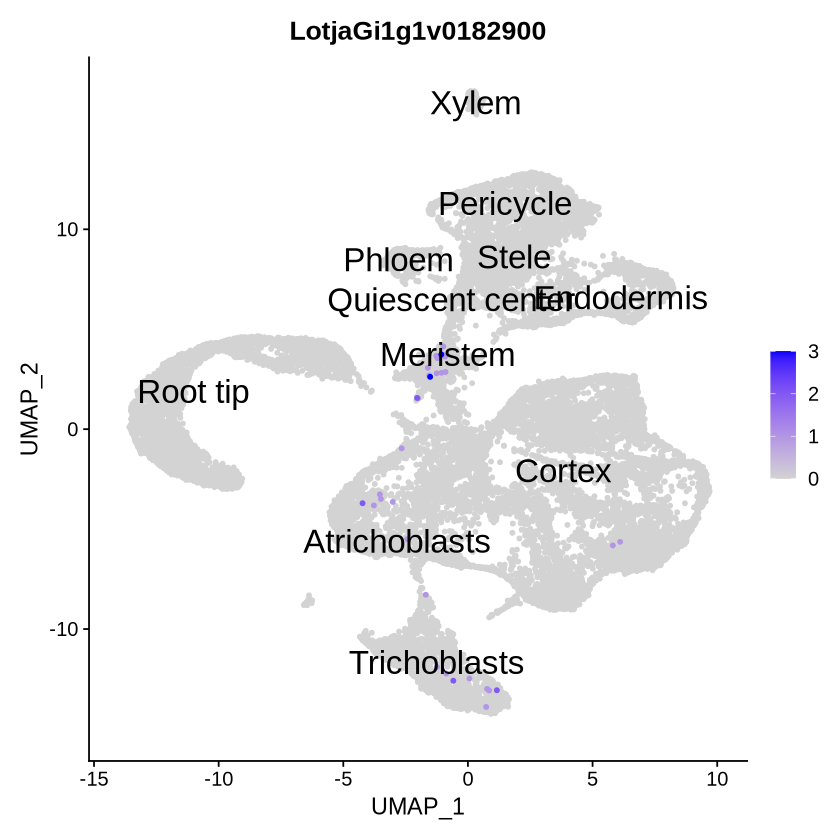

In [6]:
#| label: fig-rinrk
#| fig-cap: UMAP plot for the expression of gene RINRK1 in the data

RINRK1.id <- 'LotjaGi1g1v0182900'

DefaultAssay(seurat.clustered) <- "RNA"

FeaturePlot(seurat.clustered,
            reduction = "umap", 
            features = c(RINRK1.id), 
            order = TRUE,
            min.cutoff = 0, 
            pt.size = 1,
            label = TRUE,
            label.size = 7) + theme(legend.position = "right")

From biological knowledge, we expect the gene mostly expressed in the cortex and trichoblasts upon inoculation with rhizobia, and that is what happens in our data as well. We can see it in the code and violin plot of @fig-vln

In [7]:
cat("Cells in inoculated L.J. expressing", RINRK1.id, "\n")

cat( sum( as.numeric(GetAssayData(seurat.clustered[RINRK1.id,]))>0 & 
     seurat.clustered@meta.data$Condition=="R7A" ) )

cat("\nCells in control L.J. expressing", RINRK1.id, "\n")

cat( sum( as.numeric(GetAssayData(seurat.clustered[RINRK1.id,]))>0 & 
    seurat.clustered@meta.data$Condition=="Control" ) )

Cells in inoculated L.J. expressing LotjaGi1g1v0182900 
32
Cells in control L.J. expressing LotjaGi1g1v0182900 
0

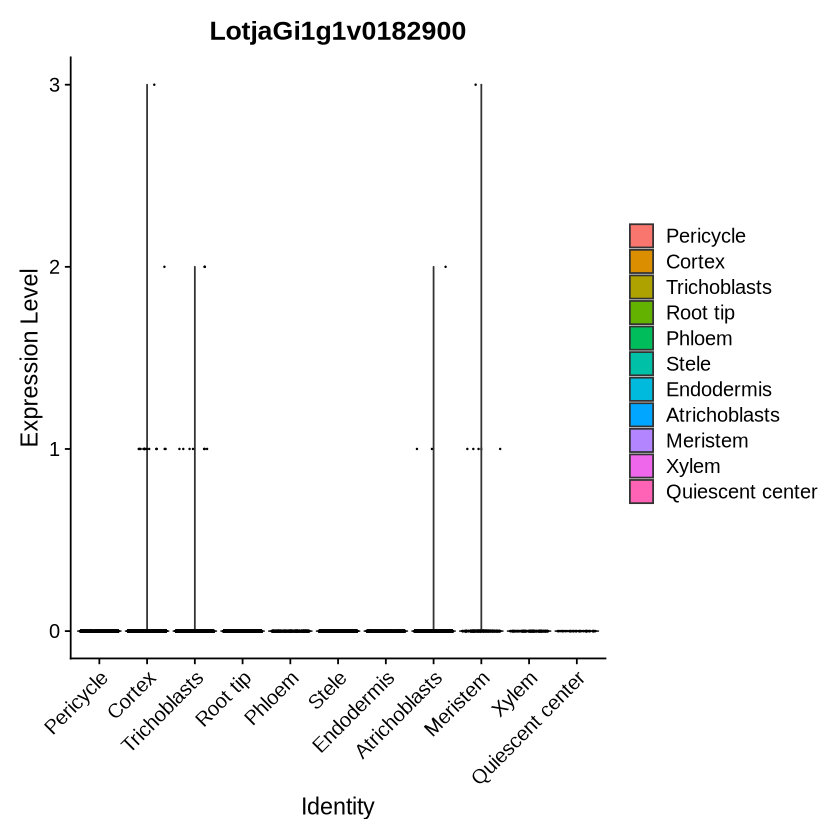

In [10]:
#| label: fig-vln
#| fig-cap: Violin plot for the expression of gene RINRK1 in various clusters

VlnPlot(seurat.clustered, 
        features = RINRK1.id)



The code below uses `FindMarkers` to compare `R7A` condition against `Wild Type` for each cluster, with a filter to remove non-singnificant genes (keeping p-value below 0.001). The final result is a table, where we will integrate the GO terms.

In [31]:
DefaultAssay(seurat.clustered) <- "integrated"
Idents(seurat.clustered) <- seurat.clustered@meta.data$Condition #use conditions as cell identities
DEG <- DataFrame() #empty dataframe

for (CLUSTER in unique(seurat.clustered@meta.data$predicted.id)){
    DEG_table <- FindMarkers(seurat.clustered[, seurat.clustered@meta.data$predicted.id == CLUSTER],
                             assay='integrated',
                             ident.1 = "R7A",
                             ident.2 = "Control", 
                             verbose = TRUE, 
                             DE_result.use = "MAST") %>%
                             filter(p_val_adj <= 0.001) # & abs(avg_log2FC)>1
    
    DEG_table$'cluster' <- CLUSTER
    DEG <- rbind(DEG, DEG_table %>% select(-p_val))
    cat("Done with cluster",CLUSTER,"\n")
    }

DEG <- as.data.frame(DEG)
Idents(seurat.clustered) <- seurat.clustered@meta.data$Cell_types
DEG$gene <- rownames(DEG)

The table looks like this. Columns represent: 

* average logfoldchange between R7A and Control
* percentage of cells in R7A expressing the gene
* percentage of cells in Control expressing the gene
* adjusted p-value
* cluster
* gene

In [40]:
head(DEG)

avg_log2FC pct.1 pct.2 p_val_adj    cluster  
LotjaGi2g1v0209000 2.304088   0.460 0.096 2.692814e-72 Pericycle
LotjaGi4g1v0241000 1.818426   0.794 0.192 3.057573e-60 Pericycle
LotjaGi4g1v0419800 3.196445   0.709 0.209 9.414111e-53 Pericycle
LotjaGi1g1v0644200 2.582328   0.288 0.029 2.757637e-48 Pericycle
LotjaGi1g1v0539500 1.513522   0.584 0.225 4.918110e-48 Pericycle
LotjaGi2g1v0409600 2.349838   0.660 0.176 6.483291e-47 Pericycle
                   gene              
LotjaGi2g1v0209000 LotjaGi2g1v0209000
LotjaGi4g1v0241000 LotjaGi4g1v0241000
LotjaGi4g1v0419800 LotjaGi4g1v0419800
LotjaGi1g1v0644200 LotjaGi1g1v0644200
LotjaGi1g1v0539500 LotjaGi1g1v0539500
LotjaGi2g1v0409600 LotjaGi2g1v0409600
                   GO                                                                                                                                                  
LotjaGi2g1v0209000 Undefined                                                                                                                                           
LotjaGi4g1v0241000 DNA-directed RNA polymerase II subunit RPB1-like protein; TAIR: AT3G50610.2 DNA-directed RNA polymerase II subunit RPB1-like protein; Swiss-Prot: sp
LotjaGi4g1v0419800 NAC domain-containing protein, putative; TAIR: AT5G13180.1 NAC domain containing protein 83; Swiss-Prot: sp                                         
LotjaGi1g1v0644200 Hydroxycinnamoyl-CoA shikimate/quinate hydroxycinnamoyltransferase; TAIR: AT2G19070.1 spermidine hydroxycinnamoyl transferase; Swiss-Prot: sp       
LotjaGi1g1v0539500 Calcium-binding EF-hand protein; TAIR: AT2G44310.1 Calcium-binding EF-hand family protein; Swiss-Prot: sp                                           
LotjaGi2g1v0409600 Adenylyl-sulfate kinase; TAIR: AT2G14750.1 APS kinase; Swiss-Prot: sp

There are a lot of genes

In [41]:
dim(DEG)[1]

[1] 1928

but we want to keep the ones changing their expression by at least a factor 2

In [34]:
DEG <- DEG %>% filter( avg_log2FC >1)

So we are left with less genes which are relevant

In [ ]:
dim(DEG)[1]

We now integrate GO terms

In [37]:
go_table <- read.table("./LJ_GO_terms.gaf", skip=6, sep='\t', fill=TRUE, quote = "\"")

In [38]:
goterms_vector <- c()

for(j in DEG$gene){
    goterms <- go_table[ grepl(j, go_table[,2]), ]$V2
    if(length(goterms)>0){  
        split_goterms <- sapply( goterms, function(x) strsplit(x, split = '\\|')[[1]][1] )
        unique_goterms <- unique( unlist(split_goterms) )
        goterms_vector <- c(goterms_vector, paste(unique_goterms, collapse=' '))
        }
    else{
            goterms_vector <- c(goterms_vector, 'Undefined')
        }
    }
DEG$GO <- goterms_vector

So we can see which GO terms are relevant in each cluster for the infected samples against the wild type:

In [48]:
DEG %>% filter(cluster=="Pericycle" & GO!="Undefined")

avg_log2FC pct.1 pct.2 p_val_adj    cluster  
LotjaGi4g1v0241000 1.818426   0.794 0.192 3.057573e-60 Pericycle
LotjaGi4g1v0419800 3.196445   0.709 0.209 9.414111e-53 Pericycle
LotjaGi1g1v0644200 2.582328   0.288 0.029 2.757637e-48 Pericycle
LotjaGi1g1v0539500 1.513522   0.584 0.225 4.918110e-48 Pericycle
LotjaGi2g1v0409600 2.349838   0.660 0.176 6.483291e-47 Pericycle
LotjaGi1g1v0623200 1.525119   0.346 0.073 3.264323e-45 Pericycle
LotjaGi1g1v0199500 1.410634   0.701 0.274 5.379101e-44 Pericycle
LotjaGi1g1v0784600 8.478837   0.513 0.176 8.503106e-43 Pericycle
LotjaGi1g1v0645200 1.950909   0.415 0.118 5.271569e-42 Pericycle
LotjaGi1g1v0647000 5.238652   0.504 0.125 5.394874e-42 Pericycle
LotjaGi1g1v0623300 2.211514   0.621 0.189 1.117525e-41 Pericycle
LotjaGi3g1v0344100 2.081218   0.532 0.131 1.775153e-41 Pericycle
LotjaGi3g1v0426600 3.389247   0.614 0.207 5.347631e-41 Pericycle
LotjaGi6g1v0247900 2.520124   0.725 0.247 1.127412e-38 Pericycle
LotjaGi4g1v0191100 3.981741   0.543 0.180 7.879583e-38 Pericycle
LotjaGi4g1v0399100 5.523372   0.481 0.236 1.335195e-37 Pericycle
LotjaGi3g1v0288200 3.355962   0.425 0.145 5.663378e-37 Pericycle
LotjaGi6g1v0226600 4.504178   0.130 0.187 3.629710e-36 Pericycle
LotjaGi1g1v0777900 1.295306   0.468 0.151 2.260382e-35 Pericycle
LotjaGi1g1v0417400 1.653293   0.268 0.194 7.686149e-34 Pericycle
LotjaGi5g1v0364400 3.418601   0.793 0.290 1.377889e-33 Pericycle
LotjaGi1g1v0504700 3.583198   0.573 0.241 6.123365e-33 Pericycle
LotjaGi6g1v0244600 2.277244   0.457 0.129 9.893661e-30 Pericycle
LotjaGi3g1v0206000 5.482537   0.303 0.129 2.752526e-29 Pericycle
LotjaGi3g1v0455500 1.607920   0.836 0.334 2.380861e-28 Pericycle
LotjaGi6g1v0049600 8.501145   0.511 0.232 5.571321e-28 Pericycle
LotjaGi6g1v0005400 4.130006   0.384 0.185 2.266855e-27 Pericycle
LotjaGi1g1v0069200 2.601303   0.344 0.051 4.732581e-27 Pericycle
LotjaGi2g1v0362400 4.432714   0.133 0.004 6.688594e-26 Pericycle
LotjaGi3g1v0034500 6.816546   0.417 0.163 7.928415e-26 Pericycle
⋮                  ⋮          ⋮     ⋮     ⋮            ⋮        
LotjaGi2g1v0339200 10.833196  0.298 0.076 1.480899e-07 Pericycle
LotjaGi4g1v0395300  1.296389  0.870 0.501 1.650502e-07 Pericycle
LotjaGi3g1v0490800  1.585869  0.556 0.461 1.685000e-07 Pericycle
LotjaGi6g1v0353500  2.170891  0.512 0.245 2.262352e-07 Pericycle
LotjaGi1g1v0556100  4.197035  0.372 0.089 5.187986e-07 Pericycle
LotjaGi5g1v0095500  5.789348  0.388 0.145 9.800705e-07 Pericycle
LotjaGi1g1v0019200  5.260339  0.124 0.016 1.035407e-06 Pericycle
LotjaGi4g1v0105200  1.209181  0.221 0.171 1.059871e-06 Pericycle
LotjaGi2g1v0369800  6.084200  0.275 0.051 5.028320e-06 Pericycle
LotjaGi3g1v0462100  2.537705  0.403 0.274 5.154179e-06 Pericycle
LotjaGi5g1v0002500  9.905817  0.295 0.049 5.265339e-06 Pericycle
LotjaGi2g1v0260800  1.285124  0.887 0.506 6.915714e-06 Pericycle
LotjaGi5g1v0221100  3.041133  0.310 0.120 1.354761e-05 Pericycle
LotjaGi6g1v0315600  4.190465  0.224 0.060 4.797712e-05 Pericycle
LotjaGi3g1v0062900  2.652580  0.303 0.156 6.526496e-05 Pericycle
LotjaGi3g1v0149500  2.317235  0.451 0.312 7.660121e-05 Pericycle
LotjaGi3g1v0210100  1.147083  0.162 0.065 9.611532e-05 Pericycle
LotjaGi5g1v0236500  1.759684  0.738 0.428 1.048536e-04 Pericycle
LotjaGi2g1v0225600  5.764788  0.337 0.145 1.322413e-04 Pericycle
LotjaGi4g1v0308800  2.985054  0.135 0.011 1.601741e-04 Pericycle
LotjaGi3g1v0506600  2.000591  0.520 0.350 1.969678e-04 Pericycle
LotjaGi1g1v0100500  2.677338  0.378 0.067 2.160070e-04 Pericycle
LotjaGi4g1v0131800  1.420829  0.269 0.158 2.688854e-04 Pericycle
LotjaGi5g1v0180400  2.464438  0.181 0.156 3.502620e-04 Pericycle
LotjaGi3g1v0039400  3.672552  0.667 0.399 3.685236e-04 Pericycle
LotjaGi1g1v0454500  4.152473  0.324 0.127 5.120103e-04 Pericycle
LotjaGi5g1v0069100  3.436984  0.182 0.223 5.968460e-04 Pericycle
LotjaGi4g1v0085800  6.027108  0.104 0.004 6.379423e-04 Pericycle
LotjaGi3g1v0341000  2.334884  0.436 0.176 7.285004e-04 Pericycle
LotjaGi1g1v0483800  2.416107  0.385 0.167 7.603728e-04

Finally, we do not expect to find the RINRK1 gene as differentially expressed, because its expression is on average too low.

In [49]:
DEG %>% filter(gene==RINRK1.id)

avg_log2FC pct.1 pct.2 p_val_adj cluster gene GO

We save the table:

In [50]:
write.csv(DEG_table, "DEG_HAR1_table.csv")

# Coexpression analysis {#sec-netorks}

We use the package hdWGCNA to detect groups of cells expressed simultaneously, and we find which modules are differentially expressed in specific clusters. We look at the GO terms to gain biological insight in the data.

::: {.callout-note}

Before running hdWGCNA, we first have to set up the Seurat object. Most of the information computed by hdWGCNA will be stored in the Seurat object’s `@misc` slot. 

:::

Here we will set up the Seurat object using the `SetupForWGCNA` function, specifying the name of the `hdWGNCA` experiment. This function also selects the genes that will be used for WGCNA. The user can select genes using three different approaches using the posse gene_select parameter:

- variable: use the genes stored in the Seurat object’s VariableFeatures.
- fraction: use genes that are expressed in a certain fraction of cells for in the whole dataset or in each group of cells, specified by `group.by`.
- custom: use genes that are specified in a custom list.

In this example, we will select genes that are expressed in at least 5% of cells in this dataset, and we will name our `hdWGCNA` experiment “tutorial”.

In [22]:
seurat.clustered <- LoadH5Seurat("seurat.clustered.h5Seurat")

Validating h5Seurat file

Initializing RNA with data

Adding counts for RNA

Adding miscellaneous information for RNA

Initializing SCT with data

Adding counts for SCT

Adding scale.data for SCT

Adding miscellaneous information for SCT

Initializing integrated with data

Adding scale.data for integrated

Adding variable feature information for integrated

Adding miscellaneous information for integrated

Adding reduction pca

Adding cell embeddings for pca

Adding feature loadings for pca

Adding miscellaneous information for pca

Adding reduction umap

Adding cell embeddings for umap

Adding miscellaneous information for umap

Adding graph integrated_nn

Adding graph integrated_snn

Adding command information

Adding cell-level metadata

Adding miscellaneous information

Adding tool-specific results

Adding data that was not associated with an assay

Warning message:
“Adding a command log without an assay associated with it”


In [23]:
seurat.clustered <- SetupForWGCNA(
  seurat.clustered,
  gene_select = "variable",
  #gene_select = "fraction", # the gene selection approach
  fraction = 0.05, # fraction of cells that a gene needs to be expressed in order to be included
  wgcna_name = "tutorial" # the name of the hdWGCNA experiment
)

## Construct metacells

After we have set up our Seurat object, the first step in running the hdWGCNA pipeline is to construct metacells from the single-cell dataset. Briefly, metacells are **aggregates of small groups of similar cells originating from the same biological sample of origin**. 

![Workflow of hdWGCNA. Similar cells are summed or averaged together to form metacells. The resulting matrix is then used as the basis for inferring modules of coexpressed genes. The metacells expression matrix is the base for all the downstream analysis, such as differential expression of genes modules in specific clusters](./images/hdwgcna.jpg) {#fig-hdwgcna, width=800}

::: {.callout-tip title="Something more about hdWGCNA" collapse="true"}

The k-Nearest Neighbors (KNN) algorithm is used to identify groups of similar cells to aggregate, and then the average or summed expression of these cells is computed, thus yielding a metacell gene expression matrix (**as if you had many bulk samples**). The **sparsity of the metacell expression matrix is considerably reduced** when compared to the original expression matrix, and therefore it is preferable to use. We were originally motivated to use metacells in place of the original single cells because correlation **network approaches such as WGCNA are sensitive to data sparsity**.

`hdWGCNA` includes a function `MetacellsByGroups` to construct metacell expression matrices given a single-cell dataset. This function constructs a new Seurat object for the metacell dataset which is stored internally in the `hdWGCNA` experiment. The `group.by` parameter determines which groups metacells will be constructed in. We only want to construct metacells from cells that came from the same biological sample of origin, so it is critical to pass that information to `hdWGCNA` via the `group.by` parameter. Additionally, we usually construct metacells for each cell type separately. Thus, in this example, we are **grouping by Sample and cell type** to achieve the desired result.

**The number of cells to be aggregated `k` should be tuned based on the size of the input dataset**, in general a lower number for `k` can be used for small datasets. We generally use `k` values between 20 and 75. The dataset used for this tutorial has 21,369 cells, and here we use `k=20`. The amount of allowable overlap between metacells can be tuned using the `max_shared` argument. There should be a range of `k` values that are suitable for reducing the sparsity while retaining cellular heterogeneity for a given dataset, rather than a single optimal value.

Note: the authors of `hdWGCNA` have found that the metacell aggregation approach does not yield good results for extremely underrepresented cell types. For example, in this dataset, the `Meristem` and `Xylem` are the least represented, and will be excluded them from this analysis. `MetacellsByGroups` has a parameter `min_cells` to exclude groups that are smaller than a specified number of cells. **Errors are likely to arise if the selected value for `min_cells` is too low**.

:::

Here **we construct metacells and normalize the resulting expression matrix** using the following code (read the additional text in the box above to understand the parameters):

In [24]:
# construct metacells  in each group
seurat.clustered <- MetacellsByGroups(
  seurat_obj = seurat.clustered,
  group.by = c("predicted.id", "Condition"), # specify metadata to split by samples and condition
  reduction = 'pca', # select the dimensionality reduction to perform KNN on
  k = 30, # nearest-neighbors parameter
  max_shared = 10, # maximum number of shared cells between two metacells
  ident.group = 'predicted.id', # set the Idents of the metacell seurat object
  assay = "integrated",
  slot = "scale.data",
  min_cells = 100,
  wgcna_name = "tutorial",
  verbose=TRUE
)

Warning message in MetacellsByGroups(seurat_obj = seurat.clustered, group.by = c("predicted.id", :
“Removing the following groups that did not meet min_cells: Meristem#Control, Quiescent center#Control, Quiescent center#R7A, Xylem#R7A”
Overlap QC metrics:
Cells per bin: 30
Maximum shared cells bin-bin: 10
Mean shared cells bin-bin: 0.901449275362319
Median shared cells bin-bin: 0

Overlap QC metrics:
Cells per bin: 30
Maximum shared cells bin-bin: 10
Mean shared cells bin-bin: 0.583544303797468
Median shared cells bin-bin: 0

Overlap QC metrics:
Cells per bin: 30
Maximum shared cells bin-bin: 10
Mean shared cells bin-bin: 0.243935323738803
Median shared cells bin-bin: 0

Overlap QC metrics:
Cells per bin: 30
Maximum shared cells bin-bin: 10
Mean shared cells bin-bin: 0.190798577845905
Median shared cells bin-bin: 0

Overlap QC metrics:
Cells per bin: 30
Maximum shared cells bin-bin: 10
Mean shared cells bin-bin: 1.06060606060606
Median shared cells bin-bin: 0

Overlap QC metrics:
Cells

In [25]:
#normalize metacell expression matrix:
seurat.clustered <- NormalizeMetacells(seurat.clustered)

Warning message:
“Cannot find a parent environment called Seurat”



Here we specify the expression matrix that we will use for network analysis. Fr example, we can choose the Cortex, which is important also because it expresses RINRK1.

In [26]:
seurat.clustered <- SetDatExpr(
  seurat.clustered,
  group_name = "Cortex", # the name of the group of interest in the group.by column
  group.by='predicted.id', # the metadata column containing the cell type info. This same column should have also been used in MetacellsByGroups
  assay = 'integrated', # using integrated assay
  slot = 'counts' # using count data
)

## Select soft-power threshold

Next we will select the soft power threshold. This is an extremely important step in the pipeline. `hdWGCNA` constructs a gene-gene correlation adjacency matrix to infer co-expression relationships between genes. The correlations are **raised to a power to reduce the amount of noise present in the correlation matrix**, thereby **retaining the strong connections and removing the weak connections**. Therefore, it is critical to determine a proper value for the soft power threshold.

We use the function `TestSoftPowers` to perform a parameter sweep for different soft power thresholds. This function helps us to guide our choice in a soft power threshold for constructing the co-expression network by inspecting the resulting network topology for different power values.
The following code performs the parameter sweep and outputs a summary figure.

pickSoftThreshold: will use block size 4085.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 4085 of 4085


Warning message:
“executing %dopar% sequentially: no parallel backend registered”


    Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k. max.k.
1       1   0.7740  5.490          0.982 2400.000  2.43e+03 2850.0
2       2   0.4200  1.520          0.921 1480.000  1.50e+03 2100.0
3       3   0.0136  0.146          0.861  951.000  9.50e+02 1610.0
4       4   0.2780 -0.553          0.894  634.000  6.15e+02 1270.0
5       5   0.6240 -0.892          0.960  436.000  4.08e+02 1040.0
6       6   0.7600 -1.080          0.966  309.000  2.73e+02  865.0
7       7   0.8230 -1.180          0.974  225.000  1.86e+02  734.0
8       8   0.8680 -1.220          0.988  168.000  1.27e+02  633.0
9       9   0.9020 -1.270          0.993  128.000  8.83e+01  553.0
10     10   0.9200 -1.310          0.991   99.000  6.20e+01  488.0
11     11   0.9360 -1.340          0.991   78.200  4.40e+01  435.0
12     12   0.9380 -1.370          0.981   62.700  3.15e+01  391.0
13     13   0.9430 -1.380          0.978   50.900  2.29e+01  354.0
14     14   0.9400 -1.380          0.970   41.900  1.68e+01  3

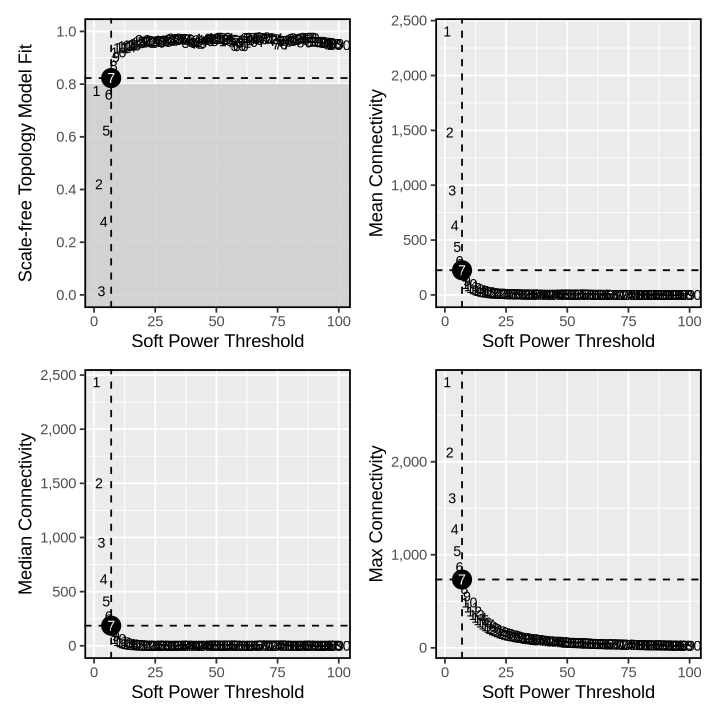

In [27]:
#| label: fig-sweep
#| fig-cap: Parameter sweep to choose the soft power threshold

# Test different soft powers:
seurat.clustered <- TestSoftPowers(powers = 1:100,
  seurat.clustered,
  networkType = 'signed'
)

# plot the results:
plot_list <- PlotSoftPowers(seurat.clustered)

# assemble with patchwork
wrap_plots(plot_list, ncol=2)

The general guidance for `hdWGCNA` is to pick the lowest soft power threshold that has Model Fit greater than or equal to 0.8, so in this case we would select our soft power threshold to be 7 following the illustration fo @fig-sweep. Later on, the `ConstructNetwork` command will automatically select the soft power threshold if the user does not provide one.

## Construction of co-expression network

We now have everything that we need to construct our co-expression network. Here we use the `hdWGCNA` function `ConstructNetwork`. This function has quite a few parameters to play with if you are an advanced user (read [this manual](https://rdrr.io/github/smorabit/hdWGCNA/man/ConstructNetwork.html) and the function `ConstructNetwork` is based on [here](https://www.rdocumentation.org/packages/WGCNA/versions/1.72-5/topics/blockwiseConsensusModules)), but we use default parameters that work well with many single-cell datasets. 

The following code constructs the co-expression network using the soft power threshold selected before:

In [28]:
# construct co-expression network:
seurat.clustered <- ConstructNetwork(na.rm=TRUE,
  seurat.clustered,
  soft_power=7,                                   
  setDatExpr=FALSE,
  tom_name = 'Cortex', # name of the topoligical overlap matrix written to disk
  overwrite_tom = TRUE
)

Warning message in ConstructNetwork(na.rm = TRUE, seurat.clustered, soft_power = 7, :
“Overwriting TOM TOM/Cortex_TOM.rda”


 Calculating consensus modules and module eigengenes block-wise from all genes
 Calculating topological overlaps block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ..Working on block 1 .
 ..Working on block 1 .
 ..merging consensus modules that are too close..


We can plot the network dendrogram in @fig-dendro. Each leaf on the dendrogram represents a single gene, and the color at the bottom indicates the co-expression module assignment.

**Note: the “gray” module consists of genes that were not grouped into any co-expression module. The gray module is to be ignored for all downstream analysis and interpretation.**

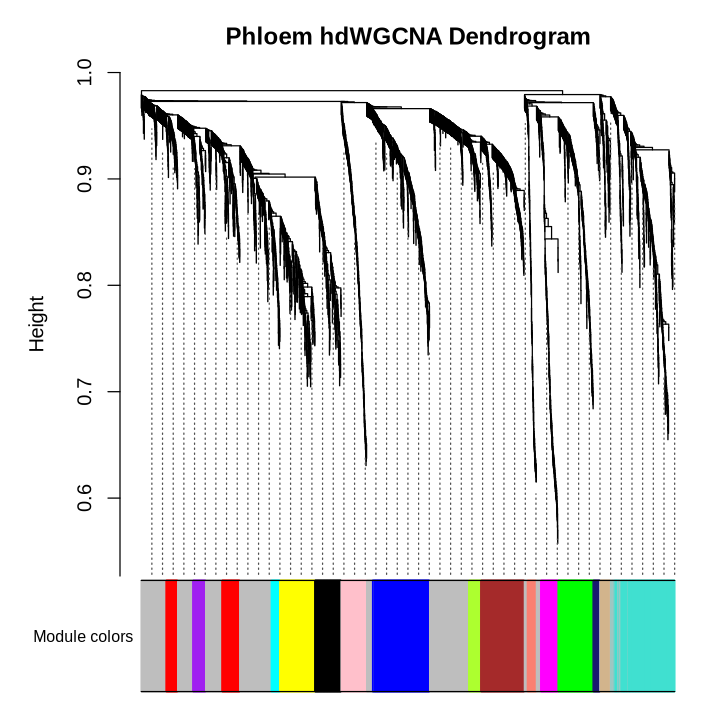

In [29]:
#| label: fig-dendro
#| fig-cap: Dendrogram of the genes coexpression network. Leaves at the bottom are genes, and the colours represent a module of coexpression for the corresponding genes.

PlotDendrogram(seurat.clustered, main='Phloem hdWGCNA Dendrogram')

### Module Eigengenes (MEs)

We calculate harmonized module eigengenes. This is a way of doing PCA of the expression matrix of metacells including the genes of one coexpression module at a time. Thus we have a PCA of the data for each module. The first principal component of each PCA is called module eigengene: it is enough to distinguish one module from all the others and characterize the expression pattern of the module (@langfelder_eigengene_2007)!

Dimensionality reduction techniques are a very hot topic in single-cell genomics (@xiang_comparison_2021). It is well known that technical artifacts can muddy the analysis of single-cell datasets, and over the years there have been many methods that aim to reduce the effects of these artifacts. Therefore it stands to reason that MEs would be subject to these technical artifacts as well, and `hdWGCNA` seeks to alleviate these effects by using the integration software `Harmony` (@korsunsky_fast_2019).

The following code performs the module eigengene computation harmonizing by the Sample of origin using the `group.by.vars` parameter.

In [30]:
# need to run ScaleData first or else harmony throws an error:
seurat.clustered <- ScaleData(seurat.clustered, 
                              features=VariableFeatures(seurat.clustered), 
                              verbose = FALSE)

In [31]:
# compute all MEs in the full single-cell dataset
seurat.clustered <- ModuleEigengenes( 
 seurat.clustered,
 group.by.vars="orig.ident",
 verbose = FALSE
)

[1] "brown"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcabrown to pcabrown_”


[1] "turquoise"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcaturquoise to pcaturquoise_”
Warning message:
“Key ‘harmony_’ taken, using ‘lpkti_’ instead”


[1] "red"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcared to pcared_”


[1] "grey"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagrey to pcagrey_”
Warning message:
“Key ‘harmony_’ taken, using ‘anmxs_’ instead”


[1] "blue"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcablue to pcablue_”


[1] "tan"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcatan to pcatan_”
Warning message:
“Key ‘harmony_’ taken, using ‘umrai_’ instead”


[1] "greenyellow"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagreenyellow to pcagreenyellow_”


[1] "magenta"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcamagenta to pcamagenta_”
Warning message:
“Key ‘harmony_’ taken, using ‘vnafw_’ instead”


[1] "yellow"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcayellow to pcayellow_”


[1] "purple"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcapurple to pcapurple_”
Warning message:
“Key ‘harmony_’ taken, using ‘pqyax_’ instead”


[1] "pink"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcapink to pcapink_”


[1] "green"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagreen to pcagreen_”
Warning message:
“Key ‘harmony_’ taken, using ‘vnltp_’ instead”


[1] "salmon"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcasalmon to pcasalmon_”


[1] "black"


Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcablack to pcablack_”
Warning message:
“Key ‘harmony_’ taken, using ‘mbzkf_’ instead”


[1] "cyan"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcacyan to pcacyan_”


[1] "midnightblue"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“did not converge--results might be invalid!; try increasing work or maxit”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcamidnightblue to pcamidnightblue_”
Warning message:
“Key ‘harmony_’ taken, using ‘esfhp_’ instead”


### Compute module connectivity

In co-expression network analysis, we often want to focus on the **hub genes, those which are highly connected within each module**. Therefore we wish to determine the eigengene-based connectivity, also known as kME, of each gene. The `ModuleConnectivity` function computes the kMEs in the single-cell dataset (rather than the metacell dataset). This function essentially computes pairwise correlations between genes and module eigengenes. 
kME can be computed for all cells in the dataset, but it is recommended computing kMEs in the cell type or group that was previously used to run ConstructNetwork.

In [32]:
# compute eigengene-based connectivity (kME):
seurat.clustered <- ModuleConnectivity(
  seurat.clustered,
  group.by = 'predicted.id', 
  group_name = 'Cortex'
)

For convenience, we re-name the hdWGCNA modules to indicate that they are from the Cortex cluster.

In [33]:
# rename the modules
seurat.clustered <- ResetModuleNames(
  seurat.clustered,
  new_name = "Cortex-Mod"
)

We can visualize the genes in each module ranked by kME using the PlotKMEs function.

[1] "Cortex-Mod1"
[1] "Cortex-Mod2"
[1] "Cortex-Mod3"
[1] "Cortex-Mod4"
[1] "Cortex-Mod5"
[1] "Cortex-Mod6"
[1] "Cortex-Mod7"
[1] "Cortex-Mod8"
[1] "Cortex-Mod9"
[1] "Cortex-Mod10"
[1] "Cortex-Mod11"
[1] "Cortex-Mod12"
[1] "Cortex-Mod13"
[1] "Cortex-Mod14"
[1] "Cortex-Mod15"
[1] "Cortex-Mod1"
[1] "Cortex-Mod2"
[1] "Cortex-Mod3"
[1] "Cortex-Mod4"
[1] "Cortex-Mod5"
[1] "Cortex-Mod6"
[1] "Cortex-Mod7"
[1] "Cortex-Mod8"
[1] "Cortex-Mod9"
[1] "Cortex-Mod10"
[1] "Cortex-Mod11"
[1] "Cortex-Mod12"
[1] "Cortex-Mod13"
[1] "Cortex-Mod14"
[1] "Cortex-Mod15"


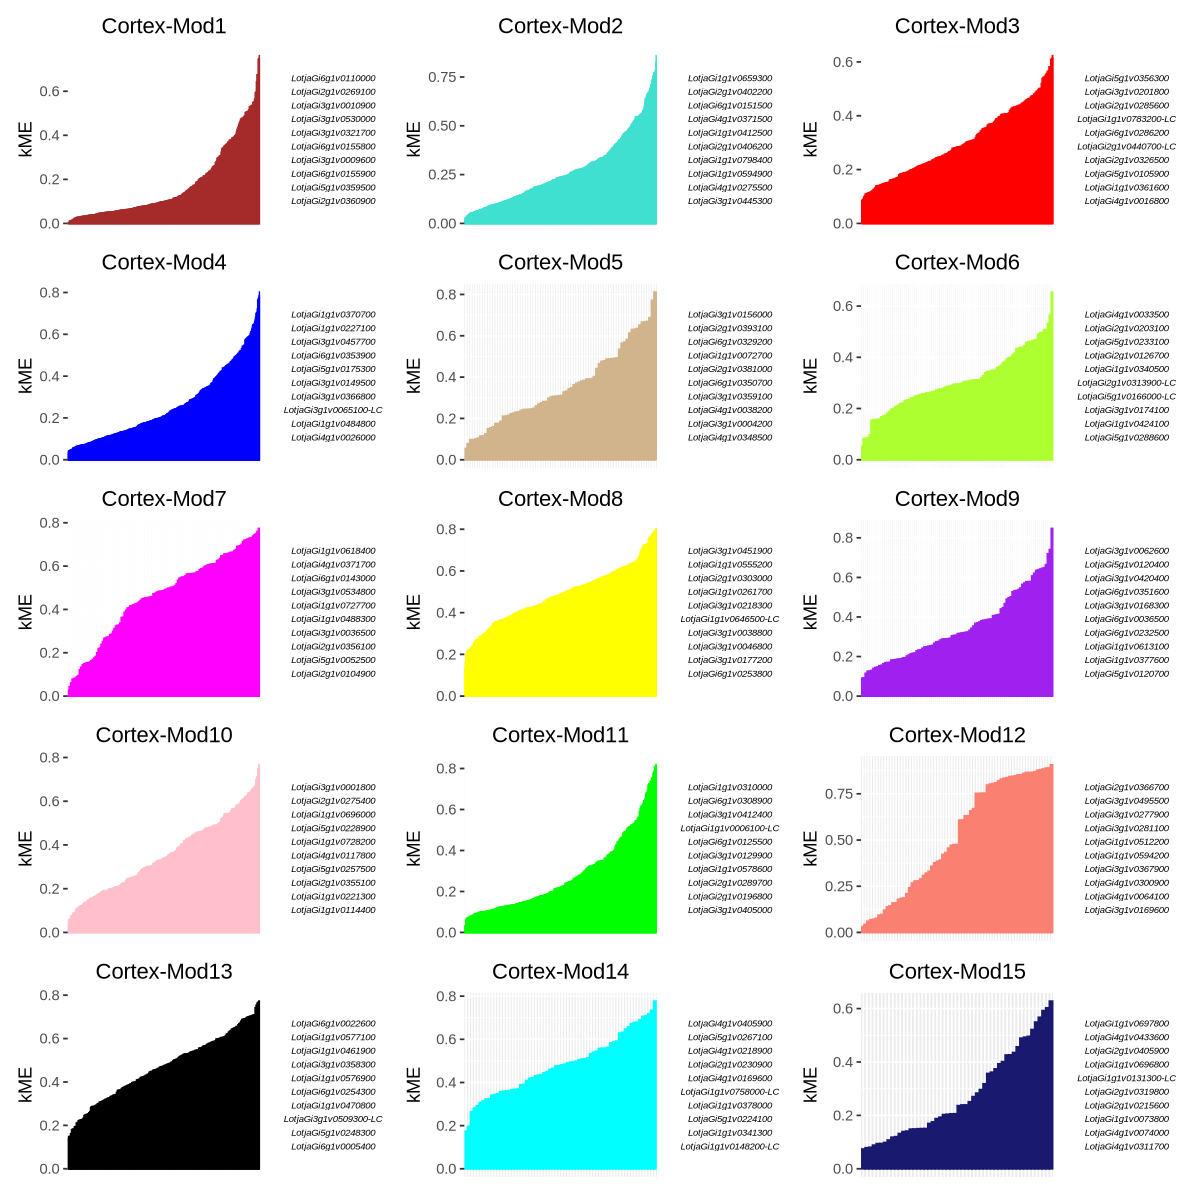

In [34]:
#| label: fig-kme
#| fig-cap: "KMEs for each module, where the genes on the right of each plot gives the top genes based on the module's KMEs"

options(repr.plot.width=10, repr.plot.height=10)
p <- PlotKMEs(seurat.clustered, ncol=3)
p

### Getting the module assignment table

The plots of @fig-kme are a bit hard to read, though fancy to plot. `hdWGCNA` allows for easy access of the module assignment table using the `GetModules` function. This table consists of three columns: `gene_name` stores the gene’s symbol or ID, module stores the gene’s module assignment, and color stores a color mapping for each module (which is used in plotting steps). If `ModuleConnectivity` has been used on this hdWGCNA experiment, as it is our case, this table has additional columns with the connectivities plotted in @fig-kme

In [35]:
# get the module assignment table:
modules <- GetModules(seurat.clustered)

# show the first 6 columns:
head(modules[,1:6])

gene_name          module      color     kME_Cortex-Mod1
LotjaGi3g1v0222100 LotjaGi3g1v0222100 Cortex-Mod1 brown      0.02693354    
LotjaGi2g1v0360900 LotjaGi2g1v0360900 Cortex-Mod1 brown      0.76096105    
LotjaGi3g1v0321700 LotjaGi3g1v0321700 Cortex-Mod1 brown      0.64214971    
LotjaGi3g1v0445300 LotjaGi3g1v0445300 Cortex-Mod2 turquoise -0.18442638    
LotjaGi5g1v0248500 LotjaGi5g1v0248500 Cortex-Mod1 brown      0.08701019    
LotjaGi3g1v0506700 LotjaGi3g1v0506700 Cortex-Mod3 red        0.34708655    
                   kME_Cortex-Mod2 kME_Cortex-Mod3
LotjaGi3g1v0222100 -0.05852407      0.009733141   
LotjaGi2g1v0360900 -0.06176182      0.295524737   
LotjaGi3g1v0321700 -0.03607290      0.135574388   
LotjaGi3g1v0445300  0.85870279     -0.401960430   
LotjaGi5g1v0248500 -0.07736695      0.066002155   
LotjaGi3g1v0506700 -0.10358792      0.250488544

A table of the top N hub genes sorted by kME can be extracted using the `GetHubGenes` function. Here we choose the top 10 genes, but you can change the value if you want

In [36]:
# get hub genes
hub_df <- GetHubGenes(seurat.clustered, n_hubs = 10)

head( hub_df )

gene_name          module      kME      
1 LotjaGi6g1v0110000 Cortex-Mod1 0.5525548
2 LotjaGi2g1v0269100 Cortex-Mod1 0.5642416
3 LotjaGi3g1v0010900 Cortex-Mod1 0.5932224
4 LotjaGi3g1v0530000 Cortex-Mod1 0.5953070
5 LotjaGi3g1v0321700 Cortex-Mod1 0.6421497
6 LotjaGi6g1v0155800 Cortex-Mod1 0.6743838

Again, we can assign GO terms to better check associated functions

In [37]:
go_table <- read.table("./LJ_GO_terms.gaf", skip=6, sep='\t', fill=TRUE, quote = "\"")

In [38]:
goterms_vector <- c()

for(j in hub_df$gene_name){
    goterms <- go_table[ grepl(j, go_table[,2]), ]$V2
    if(length(goterms)>0){  
        split_goterms <- sapply( goterms, function(x) strsplit(x, split = '\\|')[[1]][1] )
        unique_goterms <- unique( unlist(split_goterms) )
        goterms_vector <- c(goterms_vector, paste(unique_goterms, collapse=' '))
        }
    else{
            goterms_vector <- c(goterms_vector, 'Undefined')
        }
    }
hub_df$GO <- goterms_vector

Now it is easy to look at each module and relevant GO terms.

In [46]:
hub_filtered <- hub_df %>% filter(module == "Cortex-Mod3")

In [47]:
hub_filtered

gene_name             module      kME      
1  LotjaGi5g1v0356300    Cortex-Mod3 0.5465160
2  LotjaGi3g1v0201800    Cortex-Mod3 0.5528249
3  LotjaGi2g1v0285600    Cortex-Mod3 0.5568963
4  LotjaGi1g1v0783200-LC Cortex-Mod3 0.5640544
5  LotjaGi6g1v0286200    Cortex-Mod3 0.5650992
6  LotjaGi2g1v0440700-LC Cortex-Mod3 0.5814596
7  LotjaGi2g1v0326500    Cortex-Mod3 0.5814706
8  LotjaGi5g1v0105900    Cortex-Mod3 0.6085309
9  LotjaGi1g1v0361600    Cortex-Mod3 0.6127339
10 LotjaGi4g1v0016800    Cortex-Mod3 0.6228785
   GO                                                                                                                                                                            
1  Undefined                                                                                                                                                                     
2  WRKY transcription factor; TAIR: AT2G38470.1 WRKY DNA-binding protein 33; Swiss-Prot: sp                                                                                      
3  Undefined                                                                                                                                                                     
4  Undefined                                                                                                                                                                     
5  Cysteine proteinase inhibitor; TAIR: AT5G47550.1 Cystatin/monellin superfamily protein; Swiss-Prot: sp                                                                        
6  Undefined                                                                                                                                                                     
7  Mitochondrial carrier protein; TAIR: AT2G22500.1 uncoupling protein 5; Swiss-Prot: sp Mitochondrial carrier protein; TAIR: AT4G24570.1 dicarboxylate carrier 2; Swiss-Prot: sp
8  U-box domain-containing family protein; TAIR: AT2G35930.1 plant U-box 23; Swiss-Prot: sp                                                                                      
9  Undefined                                                                                                                                                                     
10 Glutamate decarboxylase; TAIR: AT5G17330.1 glutamate decarboxylase; Swiss-Prot: sp Glutamate decarboxylase; TAIR: AT2G02010.1 glutamate decarboxylase 4; Swiss-Prot: sp

We save the table for later use

In [40]:
write.csv(hub_df, "top_genes_networks.csv")

We can also plot the modules to see where they are most relevant on the UMAP plot. First we calculate the scores of a specific module we want to look at. For example, module 11. We can see how it is more expressed around the meristem cluster.

In [48]:
genes_mod11 <- hub_df %>% filter(module == "Cortex-Mod11")
genes_mod11 <- genes_mod11$gene_name

In [49]:
features_list <- list(
    'Mod11_scoring' = genes_mod11
    )
seurat.network <- AddModuleScore(
  object = seurat.network,
  features = features_list,
  ctrl = 5,
  name = 'mod11_scores'
)
L <- length(names(seurat.network@meta.data))
F <- length(names(features_list))-1
newnames <- names(seurat.network@meta.data)
newnames[(L-F):L] <- names(features_list)
names(seurat.network@meta.data) <- newnames
for(N in names(seurat.network@meta.data)[(L-F):L])
    seurat.network@meta.data[N] <- seurat.network@meta.data[N] / max(seurat.network@meta.data[N])

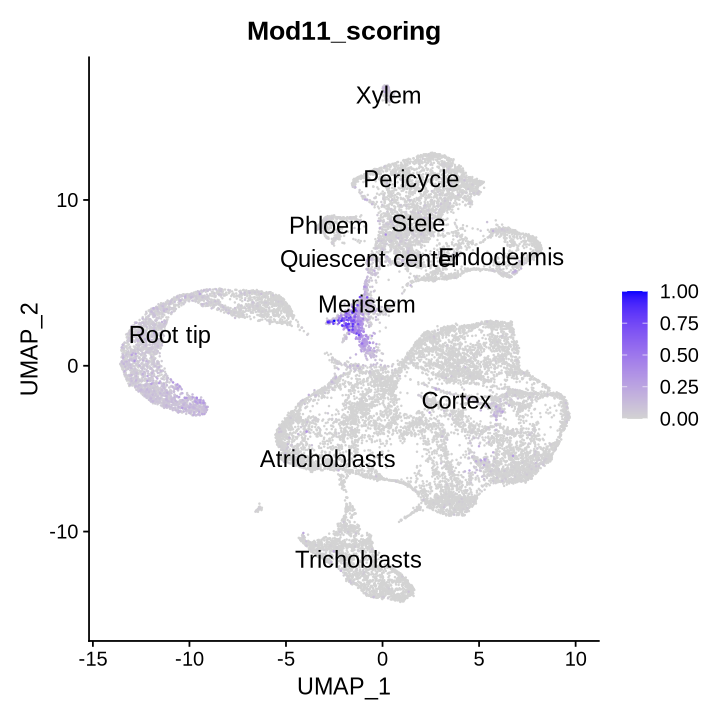

In [52]:
options(repr.plot.width=6, repr.plot.height=6)

FeaturePlot(seurat.network,
            reduction = "umap", 
            features = names(features_list), 
            order = TRUE,
            label = TRUE, 
            min.cutoff=0,
            label.size = 5) + theme(legend.position = "right")

We save the seurat object and the network (because for some inscrutable error, it cannot load together with the Seurat object when it is needed again).

In [53]:
SaveH5Seurat(seurat.clustered, 'seurat.network.h5Seurat', overwrite = TRUE)

Warning message:
“Overwriting previous file seurat.network.h5Seurat”
Creating h5Seurat file for version 3.1.5.9900

Adding data for integrated

Adding scale.data for integrated

Adding variable features for integrated

No feature-level metadata found for integrated

Writing out SCTModel.list for integrated

Adding counts for RNA

Adding data for RNA

No variable features found for RNA

No feature-level metadata found for RNA

Adding counts for SCT

Adding data for SCT

Adding scale.data for SCT

No variable features found for SCT

No feature-level metadata found for SCT

Writing out SCTModel.list for SCT

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

No JackStraw data for pca

Adding cell embeddings for umap

No loadings for umap

No projected loadings for umap

No standard deviations for umap

No JackStraw data for umap

Adding counts for integrated

Adding data for integrated

No variable features found for

In [54]:
saveRDS(seurat.clustered@misc, "network_cortex.RDS")

## Differential module Expression (DME) analysis

Lastly, we can see which modules are most expressed in a specific cluster against the others, in a similar way to differential gene expression.

In [5]:
seurat.network <- LoadH5Seurat('seurat.network.h5Seurat', misc=F)

Validating h5Seurat file

Initializing RNA with data

Adding counts for RNA

Adding miscellaneous information for RNA

Initializing SCT with data

Adding counts for SCT

Adding scale.data for SCT

Adding miscellaneous information for SCT

Initializing integrated with data

Adding scale.data for integrated

Adding variable feature information for integrated

Adding miscellaneous information for integrated

Adding reduction pca

Adding cell embeddings for pca

Adding feature loadings for pca

Adding miscellaneous information for pca

Adding reduction umap

Adding cell embeddings for umap

Adding miscellaneous information for umap

Adding graph integrated_nn

Adding graph integrated_snn

Adding command information

Adding cell-level metadata

Adding tool-specific results

Adding data that was not associated with an assay

Warning message:
“Adding a command log without an assay associated with it”


In [6]:
seurat.network@misc <- readRDS("network_cortex.RDS")

Here we discuss how to perform **DME testing between two different groups**. We use the `hdWGCNA` function `FindDMEs`, which is similar to the Seurat function FindMarkers. We use the Mann-Whitney U test, also known as the Wilcoxon test, to compare two groups, but other tests can be used at the user’s discretion with the `test.use` parameter.

We are interested in defining our two groups both by condition

In [7]:
R7Agroup <- seurat.network@meta.data %>% subset(Condition == 'R7A' & predicted.id == 'Cortex') %>% rownames
WTgroup <- seurat.network@meta.data %>% subset(Condition == 'Control' & predicted.id == 'Cortex') %>% rownames

In [8]:
DMEs <- FindDMEs(
  seurat.network,
  barcodes1 = R7Agroup,
  barcodes2 = WTgroup,
  test.use='wilcox',
  wgcna_name='tutorial'
)


[1] 21369    15
 [1] "Cortex-Mod2"  "Cortex-Mod7"  "Cortex-Mod12" "Cortex-Mod11" "Cortex-Mod1" 
 [6] "Cortex-Mod3"  "Cortex-Mod5"  "Cortex-Mod15" "Cortex-Mod4"  "Cortex-Mod9" 
[11] "Cortex-Mod10" "Cortex-Mod13" "Cortex-Mod8"  "Cortex-Mod14" "Cortex-Mod6" 


The resulting table below is very similar to the one for differential gene expression. Now the p-values and fold changes are referred to the differential module expression in the inoculated cortex VS the wild type cortex.

In [9]:
DMEs

p_val        avg_log2FC  pct.1 pct.2 p_val_adj    module      
Cortex-Mod11 1.147164e-57  2.10323119 0.167 0.060 1.720745e-56 Cortex-Mod11
Cortex-Mod14 2.473047e-34  0.76254722 0.486 0.379 3.709571e-33 Cortex-Mod14
Cortex-Mod5  1.735152e-24  0.42975793 0.478 0.373 2.602727e-23 Cortex-Mod5 
Cortex-Mod1  3.222304e-13 -1.59689353 0.009 0.031 4.833456e-12 Cortex-Mod1 
Cortex-Mod7  7.515741e-13  1.39199848 0.136 0.092 1.127361e-11 Cortex-Mod7 
Cortex-Mod2  1.893600e-12 -0.50722764 0.464 0.494 2.840401e-11 Cortex-Mod2 
Cortex-Mod13 2.229632e-12  0.41327651 0.524 0.466 3.344448e-11 Cortex-Mod13
Cortex-Mod4  1.869053e-11  0.39537664 0.464 0.396 2.803580e-10 Cortex-Mod4 
Cortex-Mod3  3.783638e-05  0.27181123 0.156 0.125 5.675457e-04 Cortex-Mod3 
Cortex-Mod10 1.192309e-03  1.00176459 0.057 0.042 1.788464e-02 Cortex-Mod10
Cortex-Mod6  2.727342e-03  0.75606355 0.043 0.031 4.091013e-02 Cortex-Mod6 
Cortex-Mod15 1.840347e-02  0.83452175 0.240 0.232 2.760520e-01 Cortex-Mod15
Cortex-Mod8  1.115541e-01  0.01975496 0.511 0.489 1.000000e+00 Cortex-Mod8 
Cortex-Mod9  2.407930e-01 -0.22587120 0.361 0.337 1.000000e+00 Cortex-Mod9 
Cortex-Mod12 5.348957e-01 -0.53647363 0.170 0.164 1.000000e+00 Cortex-Mod12

We can also do a lollipop plot, where the size of each circle is the p-value, and the x-axis is the log-fold change. A cross on a circle means the p-value is not significant. Module 7, 11 and 1 are very interesting because of their over- and under-expression

[1] "Please be aware comparison group/groups are not provided, which may casue an ERROR. PlotDMEsLollipop function will automatically assume all values are within the same group."


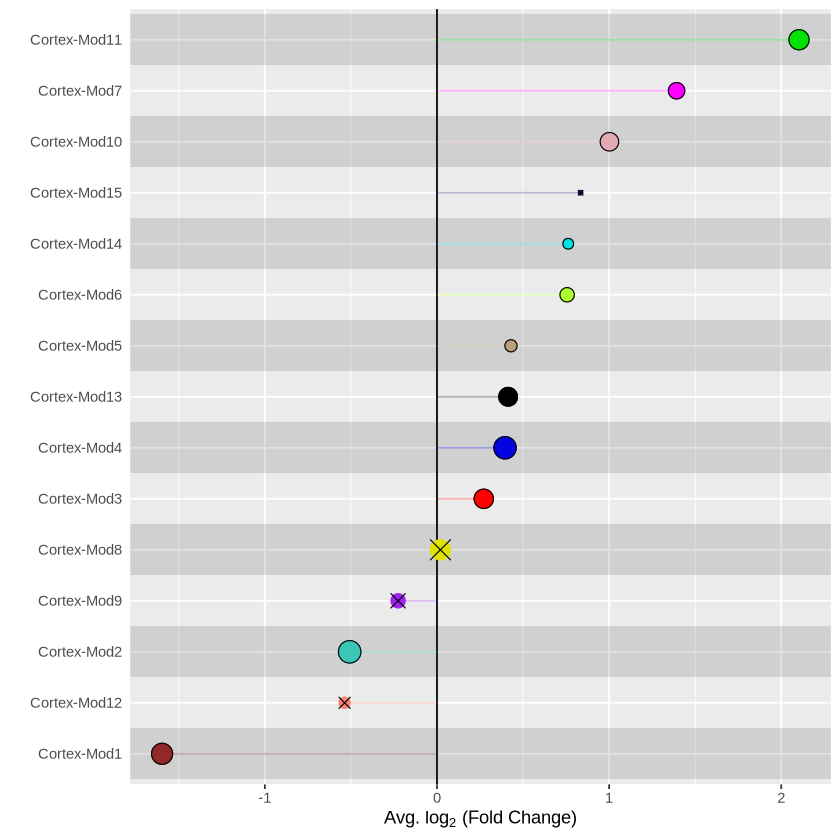

In [12]:
#| label: fig-lol
#| fig-cap: "Lollipop plot that shovs the average log-fold change of each module and the p-value (size of each circle). Crossed circles have a non-significant p-value"

PlotDMEsLollipop(
  seurat.network, 
  DMEs, 
  wgcna_name='tutorial', 
  pvalue = "p_val_adj",
)

### One-versus-all DME analysis

This is another case of DME analysis, where each cluster is tested against the rest of the data to see which modules are differentially expressed. We can test by cell type (`predicted.id`) or by condition (`Condition`).

In [11]:
DMEs_all <- FindAllDMEs(
  seurat.network,
  group.by = 'predicted.id',
  wgcna_name = 'tutorial'
)

[1] "Pericycle"
[1] "Cortex"
[1] "Trichoblasts"
[1] "Root tip"
[1] "Phloem"
[1] "Stele"
[1] "Endodermis"
[1] "Atrichoblasts"
[1] "Meristem"
[1] "Xylem"
[1] "Quiescent center"


In [13]:
head( DMEs_all )

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
Pericycle.Cortex-Mod6   0.000000e+00  1.7971133 0.980 0.193  0.000000e+00
Pericycle.Cortex-Mod13 5.315236e-120  1.1104842 0.640 0.328 7.972854e-119
Pericycle.Cortex-Mod14 5.643287e-111  0.7258917 0.596 0.281 8.464930e-110
Pericycle.Cortex-Mod2  1.239686e-102 -4.9000670 0.054 0.360 1.859529e-101
Pericycle.Cortex-Mod3   1.448747e-99 -7.6054198 0.014 0.307  2.173121e-98
Pericycle.Cortex-Mod11  3.571298e-64 -5.1718103 0.022 0.233  5.356946e-63
                       module       group    
Pericycle.Cortex-Mod6  Cortex-Mod6  Pericycle
Pericycle.Cortex-Mod13 Cortex-Mod13 Pericycle
Pericycle.Cortex-Mod14 Cortex-Mod14 Pericycle
Pericycle.Cortex-Mod2  Cortex-Mod2  Pericycle
Pericycle.Cortex-Mod3  Cortex-Mod3  Pericycle
Pericycle.Cortex-Mod11 Cortex-Mod11 Pericycle

The table is usually big, but you can choose to filter by various parameters as below, and to look only at one cluster of interest

In [19]:
DMEs_all_filter <- DMEs_all %>% filter(p_val_adj < .001 & abs(avg_log2FC)>1 
                                       & is.finite(avg_log2FC)
                                       & group=='Cortex')

In [20]:
DMEs_all_filter

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
Cortex.Cortex-Mod2   0.000000e+00  2.167331  0.479 0.253  0.000000e+00
Cortex.Cortex-Mod1   0.000000e+00 -5.839450  0.020 0.289  0.000000e+00
Cortex.Cortex-Mod3   0.000000e+00 -2.702089  0.141 0.392  0.000000e+00
Cortex.Cortex-Mod4   0.000000e+00  2.049920  0.430 0.184  0.000000e+00
Cortex.Cortex-Mod8   0.000000e+00  2.262900  0.500 0.250  0.000000e+00
Cortex.Cortex-Mod6   0.000000e+00 -4.312895  0.037 0.368  0.000000e+00
Cortex.Cortex-Mod14 2.845815e-287  1.723108  0.433 0.208 4.268722e-286
Cortex.Cortex-Mod11 5.786557e-203 -1.021877  0.113 0.295 8.679835e-202
Cortex.Cortex-Mod10 4.303483e-149 -3.285082  0.049 0.164 6.455224e-148
                    module       group 
Cortex.Cortex-Mod2  Cortex-Mod2  Cortex
Cortex.Cortex-Mod1  Cortex-Mod1  Cortex
Cortex.Cortex-Mod3  Cortex-Mod3  Cortex
Cortex.Cortex-Mod4  Cortex-Mod4  Cortex
Cortex.Cortex-Mod8  Cortex-Mod8  Cortex
Cortex.Cortex-Mod6  Cortex-Mod6  Cortex
Cortex.Cortex-Mod14 Cortex-Mod14 Cortex
Cortex.Cortex-Mod11 Cortex-Mod11 Cortex
Cortex.Cortex-Mod10 Cortex-Mod10 Cortex

Print module on UMAP

In [42]:
features_list <- list(
    'Mod8_scoring' = genes_phloem
    )

In [43]:
seurat.network <- AddModuleScore(
  object = seurat.network,
  features = features_list,
  ctrl = 5,
  name = 'mod_scores'
)

In [44]:
L <- length(names(seurat.network@meta.data))
F <- length(names(features_list))-1
newnames <- names(seurat.network@meta.data)
newnames[(L-F):L] <- names(features_list)
names(seurat.network@meta.data) <- newnames
for(N in names(seurat.network@meta.data)[(L-F):L])
    seurat.network@meta.data[N] <- seurat.network@meta.data[N] / max(seurat.network@meta.data[N])

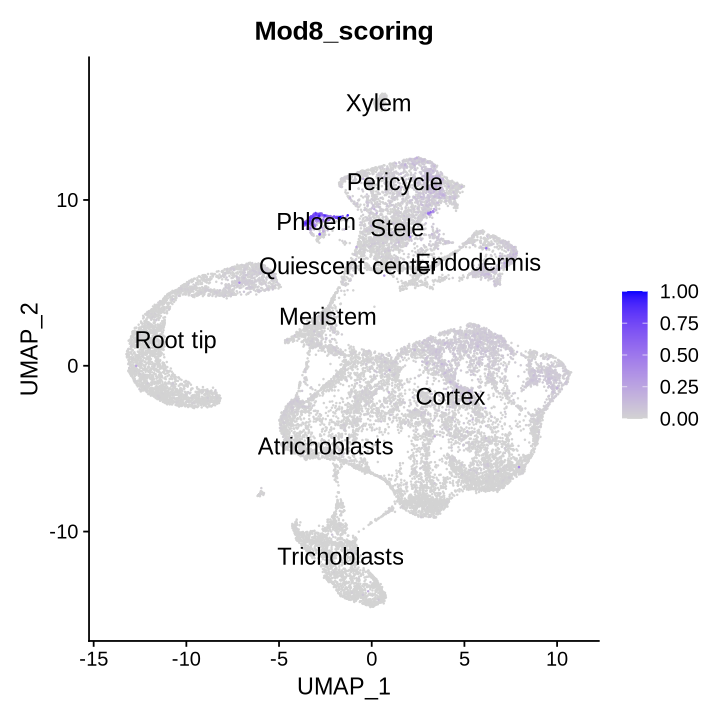

In [51]:
options(repr.plot.width=6, repr.plot.height=6)

FeaturePlot(seurat.network,
            reduction = "umap", 
            features = names(features_list), 
            order = TRUE,
            label = TRUE, 
            min.cutoff=0,
            label.size = 5) + theme(legend.position = "right")

We do that for the R7A condition

In [ ]:
gotable_r7a <- data.frame()
for(j in fc.r7a@module_list[['LotjaGi3g1v0222100']])
    gotable_r7a <- rbind(gotable_r7a, gotable[ grepl(j, gotable[,2]), ])        
gotable_r7a$'Representative' <- rep('LotjaGi3g1v0222100', nrow(gotable_r7a))

In [ ]:
gotable_r7a

and for the control condition:

In [ ]:
gotable_control <- data.frame()
for(j in fc.control@module_list[['LotjaGi2g1v0386600']])
    gotable_control <- rbind(gotable_control, gotable[ grepl(j, gotable[,2]), ])        
gotable_control$'Representative' <- rep('LotjaGi2g1v0386600', nrow(gotable_control))

In [ ]:
gotable_control

The tables can again be saved in csv format.

In [ ]:
write.csv(gotable_r7a, "network_goterms_r7a.csv")

In [ ]:
write.csv(gotable_control, "network_goterms_control.csv")